In [1]:
#IMPORTING LIBRARIES

import scipy.special as sp # UNUSED?
import numpy as np # NumPy offers comprehensive mathematical functions, random number generators, linear algebra routines, Fourier transforms, and more
import matplotlib.pyplot as plt # Provides a MATLAB-like way of plotting
import pandas as pd # Data analysis and manipulation tool. Used to read in bathymetry data (M77T file), Directions data (excel file), and organises Vmean into a labelled data structure
# M77T data files are created from raw data collected by marine researchers using InfoBank
from scipy.interpolate import CubicSpline as SP # Used to create a spline about the velocity, shape parameter and proability data
from scipy.optimize import minimize,least_squares,Bounds,basinhopping # Optimizing and route finding
from scipy.special import gamma # Gamma function used for weibull distribution
import matplotlib.cm as cm # UNUSED?
from Boruvka_Mod import Graph # imports class graph from Boruvka_Mod python file
import utm # Used to help convert latitude and longitude in bathymetry data to centred eastings and northings
import scipy.interpolate as spline # Used to smooth the bathymetry data
from matplotlib.colors import ListedColormap # UNUSED?
import math # Provides access to the mathematical functions
from time import perf_counter # Returns the float value of time in seconds. Used to record run time for clustering and optimization algorithms
from minmax_kmeans import minsize_kmeans # imports minsize_kmeans function from minmax_kmeans python file
import pulp #Used in the clustering algorithm to generate MPS and LP files

In [2]:
#READING IN BATHYMETRY DATA

data = pd.read_csv("nsea86.m77t", sep='\t') # Reads in all data from file including depth data, lattitude, longitude etc.
mindepth = min(data['CORR_DEPTH']) # Retrieves minimum depth value from data file 'nsea86.m77t'
print('Shallowest depth:', mindepth, 'm') #Prints out the result for the smallest depth value

Shallowest depth: 17.2 m


In [3]:
# KEY COSTING PARAMETERS USED THROUGHOUT MODEL

USDtoGBP = 1/1.38  #28th october 2021            #1/1.2821
EURtoGBP = 1/1.1816 #28th october 2021           #1/1.1511

CableCostperMeter = 300 # in GBP
CostperTurbineUSD = 3000000 # USD
CostperTurbine = CostperTurbineUSD*USDtoGBP # GBP

OperatingandMaintenanceCostPerMWh = 15 # euros (between 15 and 26)
LifeTimeTurbineOperatingTime = 120000 # hours
MaintenanceCostperMW = OperatingandMaintenanceCostPerMWh*LifeTimeTurbineOperatingTime*EURtoGBP # in GBP
MaintenanceCostperTurbine = 2*MaintenanceCostperMW # in GBP

LandCostperHectare = 17245 # in GBP
LandCostpermSquared = LandCostperHectare/10000 #  in GBP
FixedCost = 600000 # Costs  associated with the purchase and installation of electrical substations as well as thebuildings required for housing the staff and additional equipment required for the running of the wind farm.


In [4]:
#USER DEFINED VALUES

maximumturbinespertree = 10 # number of turbines allowed along a single cable from the substation.
budget = 300000000 # Budget in £ to build the wind farm, accounting for construction costs.

In [5]:
###CALCULATES THE INITIAL NUMBER OF TURBINES THE OPTIMISATION SHOULD START WITH.

maxnodespertree = maximumturbinespertree # As above

a = 350 # minimum distances turbines can be from one another in m.
b = 3000 # distance that turbines have negligible affect on eachother in m. If model changes this value could change
minareaperturbine = (1/2)*(math.sqrt(3))*(a**2) # Area per turbine assuming 350m between each turbine
LandCostperTurbine=minareaperturbine*(LandCostpermSquared) # Cost with minimum area
MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(mindepth)**2) - 0.0002*(float(mindepth)) + 0.9459)-CostperTurbine # Uses shallowest depth from before
print('Min depth cost per turbine = £',MinDepthCostPerTurbine) # prints result

MinCostperTurbTot = CostperTurbine+LandCostperTurbine+MaintenanceCostperTurbine+MinDepthCostPerTurbine # Total costs
nturb = (budget-FixedCost)/(MinCostperTurbTot)   #need to include depth cost
nturb = math.floor(nturb) # rounds down as cannot have fraction of a turbine
minarea = minareaperturbine*nturb # Overall minimum area considering the amount of turbines
maxarea = nturb*(1/2)*(math.sqrt(3))*(b**2) # Careful this isn't bigger than the entire size of the scaled nsea86 sea floor.

print('Min area per turbine =', minareaperturbine, 'm^2') # prints results
print('Min area =', minarea, 'm^2')
print('Max number of turbines =', nturb)
print('Max area =', maxarea, 'm^2')

Min depth cost per turbine = £ 3539.13043478271
Min area per turbine = 106088.11196359372 m^2
Min area = 5834846.157997655 m^2
Max number of turbines = 55
Max area = 428682574.8732971 m^2


[[    0.             0.        ]
 [  350.             0.        ]
 [  525.           303.10889132]
 [  175.           303.10889132]
 [ -175.           303.10889132]
 [ -350.             0.        ]
 [ -525.          -303.10889132]
 [ -175.          -303.10889132]
 [  175.          -303.10889132]
 [  525.          -303.10889132]
 [  700.             0.        ]
 [  875.           303.10889132]
 [ 1050.           606.21778265]
 [  700.           606.21778265]
 [  350.           606.21778265]
 [    0.           606.21778265]
 [ -350.           606.21778265]
 [ -525.           303.10889132]
 [ -700.             0.        ]
 [ -875.          -303.10889132]
 [-1050.          -606.21778265]
 [ -700.          -606.21778265]
 [ -350.          -606.21778265]
 [    0.          -606.21778265]
 [  350.          -606.21778265]
 [  700.          -606.21778265]
 [  875.          -303.10889132]
 [ 1050.             0.        ]
 [ 1225.           303.10889132]
 [ 1400.           606.21778265]
 [ 1575.  

Text(0, 0.5, 'y distance [m]')

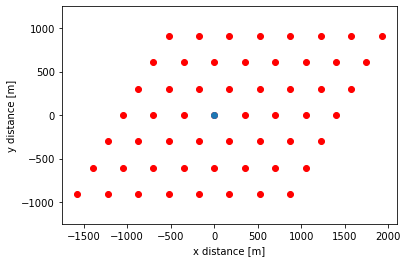

In [6]:
#PRE-OPTIMISATION TURBINE POSITIONING

# places substation at (0,0).
# places 1st turbine at vector (a,0) from substation. a=350m from before
# places 2nd turbine at vector (0.5a,0.5aroot3) from prev. 
# places 3rd turbine at vector (-a,0) from prev
# places 4th turbine at vector (-a,0) from prev, continues in this spiralling fashion

positionlist = np.empty((nturb+1,2)) # Creates an empty list of size (number of turbines + 1 (since 0 position is substation),2)
turbineposition = np.array([[0,0]]) # Creates [0,0] array for introducing [x,y] coordinates for each turbine
positionlist[0,:] = turbineposition # 

oddcounter = 0
evencounter = 0
i = 0
k = 0

while k<nturb+1: # Loops for number of turbines 
    i += 1
    if (i%2)!= 0: # i is odd
        oddcounter+=1 
        for j in range(oddcounter):
            k += 1
            if k == nturb+1:
                break
            if (oddcounter%2)!= 0: #oddcounter is odd
                shift = np.array([[a, 0]])
            else:
                shift = np.array([[-a, 0]])
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
            
    else:
        evencounter+=1
        for j in range(evencounter):
            k += 1
            if k == nturb+1:
                break
            if (evencounter%2)!= 0: #evencounter is odd
                shift = np.array([[0.5*a,0.5*a*math.sqrt(3)]])
            else:
                shift = np.array([[-0.5*a,-0.5*a*math.sqrt(3)]]) 
            turbineposition = np.add(turbineposition, shift) 
            positionlist[k,:] = turbineposition
                
print(positionlist) # prints positions data        
print(len(positionlist)) # prints length of positions list (should be the number of turbines + 1 for the subsation)

fig, ax = plt.subplots() #subplot ax created
ax.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax.scatter(0,0) # Substation
plt.axis('equal') # Sets equal scaling for plot
ax.set_xlabel('x distance [m]') # x axis label
ax.set_ylabel('y distance [m]') # y axis label

C:\Users\Matthew Oxley\Documents\python anaconda\lib\site-packages\pulp\pulp.py:1313: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Function run time: 1.0592341000000012
[[   0    1    9   10   25   26   27   49   50   51 -100]
 [   0    2    3   13   14   15   32   33   34   35 -100]
 [   0   19   20   21   39   40   41   42   43   44 -100]
 [   0    4    5    6   16   17   18   36   37   38 -100]
 [   0   11   12   28   29   30   31   52   53   54   55]
 [   0    7    8   22   23   24   45   46   47   48 -100]]


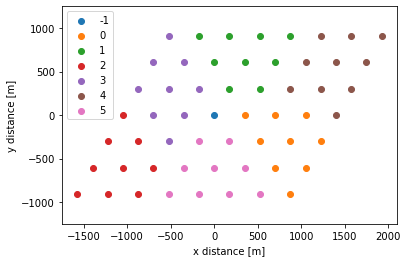

In [7]:
#CLUSTERING ALGORITHM

#Uses an adapted version of kmeans with a cap on the number of points per cluster. Used to radially cluster turbines
#into segments which MST algorithm can then use to determine cabling for a given radial array. Initially unnecessary
#for the initially structured turbine layout as seen above, but increasingly important as turbine layout becomes
#non-uniform through optimisation when the below function is repeatedly called.
# minsize_kmeans imported from external python file

def clustering_algorithm(positionlist,nturb,maxnodespertree):
    k = math.ceil(nturb/maxnodespertree) #number of clusters. math.ceil rounds a number upwards to its nearest integer
    [turbines, centres] = minsize_kmeans(positionlist[1:,:] ,k ,min_size = 1, max_size = maxnodespertree) 
    #turbines exists as an array containing the cluster value for each turbine
    #Assigns each turbine to a cluster. excludes substation, executes external python file, 
    #limits for how many turbines are in each cluster between 1 and max nodes per tree 
    label = np.concatenate((np.array([-1]),turbines)) # Adds -1 (substation label) to the other turbine labels
    u_labels = np.unique(label) 
    # finds unique elements of label. Finds the unique cluster labels 
    # each turbine is assigned a cluster/label and this returns a single label for each cluster
    
    a = 0
    indiceslist = np.empty((k,maxnodespertree), dtype=np.int8) # empty array of no.clusters by max nodes per tree
# indiceslist basically tells us what turbines belong to each cluster
# each row of indiceslist represents a cluster and each point on that row a indidual turbine within that cluster
# Each row starts with a 0 which represents the subsation which belongs to all clusters
# As seen before in the initial layout numbers are assigned starting at 1 which is the turbine (a,0) from the substation
# The numbering then continues in a cyclic motion traveling anticlockwise up until the total number of turbines
    
    for i in range(k): # loops for number of clusters
        indices = [i for i, x in enumerate(label) if x == a] # enumerate exists as a counter in the loop (starts at x=a=0)

        if len(indices) < maxnodespertree:
            noofemptys = maxnodespertree - len(indices)
            for l in range(noofemptys): # For the empty spaces in the matrix replaces these with -100 as fillers
                indices.append(int(-100))
    
        indiceslist[i,:] = (indices)
        a += 1
    
    arr = np.zeros((k,1),dtype=np.int8)   # zero array of number of clusters by 1 (Substation array)
    indiceslist = np.concatenate((arr,indiceslist),axis=1) # Adds substation zero array to turbine cluster matrix
    return indiceslist,u_labels,label

t1_start = perf_counter() # Starts timer
indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) #Executes clustering algorithm
t1_stop = perf_counter() # Ends timer
print('Function run time:', t1_stop-t1_start) # Prints algorithm run time

fig,ax = plt.subplots()
print(indiceslist)
for i in u_labels: # loops for number of turbines
    ax.scatter(positionlist[label == i , 0] , positionlist[label == i, 1] , label = i)
ax.legend() # prints legend
plt.axis('equal') # Sets equal scaling for plot
ax.set_xlabel('x distance [m]') # x axis label
ax.set_ylabel('y distance [m]') # y axis label
plt.show() #shows plot

In [8]:
#CREATES INPUT NEEDED FOR MST ONCE CLUSTERS ARE DEFINED.

def geom_analysis(positionlist,indiceslist):
    
    #Arrays for pairwise distances and angles
    #Angle 0: x directıon. Angle pi/2: y directıon
    distance = [None] * math.ceil(nturb/maxnodespertree) # null array with size based on number of clusters
    angle = [None] * math.ceil(nturb/maxnodespertree) 
    distance_global = np.zeros((nturb,nturb)) #zero array nturb by nturb. This will be for storing the distance between each pair of turbines for cabling
    angle_global = np.zeros((nturb,nturb)) # Like above this will be for storing the angle data between each pair of turbines for cabling
    coords = positionlist[1:,:] # Coordinates of each turbine

    for i in range(0,nturb): # loops for number of turbines
        distance_global[i,:]=np.sqrt(np.square(coords[i,0]-coords[:,0])+np.square(coords[i,1]-coords[:,1])) # Pythagoras for hypotenuse
        angle_global[i,:]=np.arctan2(coords[:,1]-coords[i,1],coords[:,0]-coords[i,0]) #Pythagoras for angle
        distance_global[i,i]=1e10
        #Rotate angles so that north=0 and convert to degrees
    angle_global=-np.rad2deg(angle_global)+270
    
    for x in range(0,math.ceil(nturb/maxnodespertree)): # loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1)
        distance[x]=np.zeros((nturbintree,nturbintree))
        angle[x]=np.zeros((nturbintree,nturbintree))
    
        for i in range(0,nturbintree):
            for j in range(0,nturbintree):
                distance[x][i,j] = np.sqrt(np.square(positionlist[(indiceslist[x,i]),0]-positionlist[(indiceslist[x,j]),0]) + np.square(positionlist[(indiceslist[x,i]),1]-positionlist[(indiceslist[x,j]),1]))
                angle[x][i,j]=np.arctan2(positionlist[(indiceslist[x,j]),1]-positionlist[(indiceslist[x,i]),1],positionlist[(indiceslist[x,j]),0]-positionlist[(indiceslist[x,i]),0])
                distance[x][i,i]=1e10
        
        #Rotate angles so that north=0 and convert to degrees
        angle[x]=-np.rad2deg(angle[x])+270
      
    return distance,angle,distance_global,angle_global

In [9]:
# DETERMINES MINIMUM LENGTH OF CABLING REQUIRED TO CREATE COMPLETE CABLING NETWORK SUCH THAT ALL TURINES ARE CONNECTED
# IN ACCORDANCE WITH USER'S CONDITIONS.

def Minimum_Spanning_Tree(distance,indiceslist):

    MSTweight = [None] * math.ceil(nturb/maxnodespertree) # null array with sized based on number of clusters
   
    for x in range(0,math.ceil(nturb/maxnodespertree)): #loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1)
        g=Graph(nturbintree) #Graph is part of the external python script titled Boruvka_Mod
        
        for i in range(0,nturbintree):
            for j in range(i+1,nturbintree):
                g.addEdge(i,j ,(distance[x][i,j]*1000))
           
        MSTweight[x]=g.boruvkaMST()

    return MSTweight

Each tree weight tree 1 3150000.0
Each tree weight tree 2 3150000.0
Each tree weight tree 3 3726012.958872607
Each tree weight tree 4 3150000.0
Each tree weight tree 5 4076012.958872607
Each tree weight tree 6 3150000.0
MST total weight 20402025.917745214 m


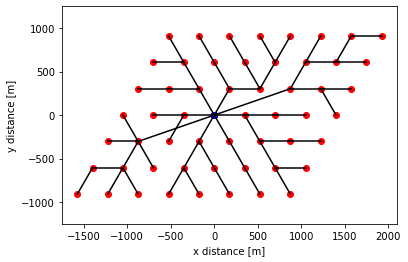

In [10]:
#PLOTTING PRE-OPTIMISED MST

# the Boruvka_mod code requires graphs with vertices 0....n, which is provided by the index value on indices list.
# When this is plotted, the values within the correct indiceslist row are then used to reference the index within
# positionlist to be plotted.

#

MSTweight=Minimum_Spanning_Tree(geom_analysis(positionlist, indiceslist)[0],indiceslist)

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
ax.scatter(positionlist[:,0],positionlist[:,1],c='red')

links = [None] * math.ceil(nturb/maxnodespertree)
MSTWeightSum = 0 #MST weight is simply the total length of cabling used

for a in range(0,math.ceil(nturb/maxnodespertree)):
    MSTWeightSum += MSTweight[a][0]
    print('Each tree weight', 'tree',a+1 ,MSTweight[a][0])
    links[a] = MSTweight[a][1]
    
    for b in links[a]:
        u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
        v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
        ax.plot(u,v, c='black')
        ax.scatter(0,0,c='blue')
        
print('MST total weight', MSTWeightSum, 'm')

In [11]:
#DISPLAYS RAW BATHYMETRY DATA

print(data) # Prints out bathymetry data - Read in using pandas in previous section

      SURVEY_ID  TIMEZONE      DATE     TIME       LAT      LON  POS_TYPE  \
0        NSEA86         0  19860424  149.733  54.50260  4.42565       NaN   
1        NSEA86         0  19860424  150.700  54.50254  4.42011       NaN   
2        NSEA86         0  19860424  151.717  54.50247  4.41424       NaN   
3        NSEA86         0  19860424  152.683  54.50240  4.40861       NaN   
4        NSEA86         0  19860424  153.667  54.50234  4.40282       NaN   
...         ...       ...       ...      ...       ...      ...       ...   
18132    NSEA86         0  19860513  555.800  52.81589  4.07220       NaN   
18133    NSEA86         0  19860513  556.900  52.81516  4.07883       NaN   
18134    NSEA86         0  19860513  557.733  52.81459  4.08396       NaN   
18135    NSEA86         0  19860513  558.700  52.81396  4.08972       NaN   
18136    NSEA86         0  19860513  559.750  52.81325  4.09609       NaN   

       NAV_QUALCO  BAT_TTIME  CORR_DEPTH  ...  MAG_RESSEN  MAG_DICORR  \
0 

In [12]:
#CONVERTS LATITUDE AND LONGITUDE IN BATHYMETRY DATA TO CENTERED EASTINGS AND NORTHINGS

data['easting'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[0], axis=1) #Converts lon/lat to easting and adds this onto the 'data' file
data['northing'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[1], axis=1) #Converts lon/lat to northing and adds this onto the 'data' file

zero_east = min(data['easting']) + (max(data['easting']) - min(data['easting']))/2 +30000 # Determines centre of bathymrtry data in easting direction (+30,000 is simply to get a more interesting result from the current bathymetry data)
zero_north = min(data['northing']) + (max(data['northing']) - min(data['northing']))/2 # Determines centre of bathymetry data in northing direction   

data['centered_easting'] = data['easting'] - zero_east # Centres the data about (0,0) and adds this onto the 'data' file
data['centered_northing'] = data['northing'] - zero_north # Centres the data about (0,0) and adds this onto the 'data' file

print(data) 

      SURVEY_ID  TIMEZONE      DATE     TIME       LAT      LON  POS_TYPE  \
0        NSEA86         0  19860424  149.733  54.50260  4.42565       NaN   
1        NSEA86         0  19860424  150.700  54.50254  4.42011       NaN   
2        NSEA86         0  19860424  151.717  54.50247  4.41424       NaN   
3        NSEA86         0  19860424  152.683  54.50240  4.40861       NaN   
4        NSEA86         0  19860424  153.667  54.50234  4.40282       NaN   
...         ...       ...       ...      ...       ...      ...       ...   
18132    NSEA86         0  19860513  555.800  52.81589  4.07220       NaN   
18133    NSEA86         0  19860513  556.900  52.81516  4.07883       NaN   
18134    NSEA86         0  19860513  557.733  52.81459  4.08396       NaN   
18135    NSEA86         0  19860513  558.700  52.81396  4.08972       NaN   
18136    NSEA86         0  19860513  559.750  52.81325  4.09609       NaN   

       NAV_QUALCO  BAT_TTIME  CORR_DEPTH  ...   GRA_OBS  EOTVOS  FREEAIR  \

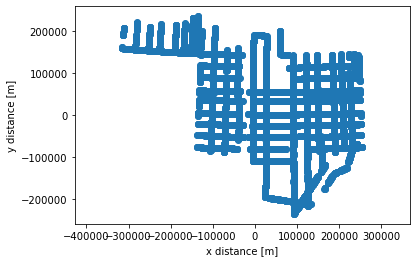

In [13]:
#PLOTS CENTERED BATHYMETRY DATA

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

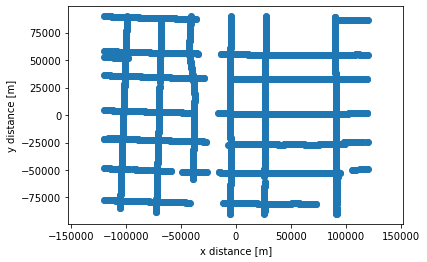

In [14]:
# SAMPLING AND PLOTTING CENTRAL BATHYMETRY DATA
# Takes sample between +/-120000 in easting direction, +/-90000 in the northing direction, and +/-1000 for the depth values

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data = data[(data['centered_easting'] >=-120000) & (data['centered_easting'] <= 120000) & (data['centered_northing']>=-90000) & (data['centered_northing']<= 90000) & (data['CORR_DEPTH']<=1000) & (data['CORR_DEPTH']>=-1000)]
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

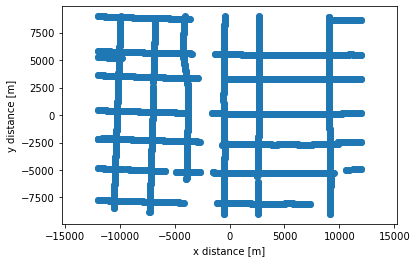

In [15]:
#FURTHER BATHYMETRY DATA PROCESSING
#Further decreases the area considered to be more applicable to the size of the wind farm (Sample from before divided by 10 in northing and easting directions)

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data['centered_easting'] = data['centered_easting']/10 
data['centered_northing'] = data['centered_northing']/10
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

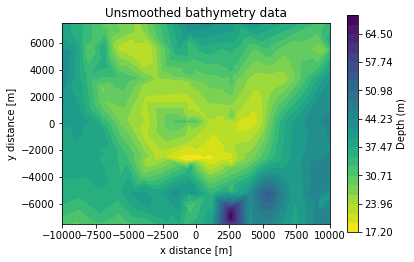

In [16]:
#UNSMOOTHED BATHYMETRY DATA CONTOUR PLOTTING

fig, ax = plt.subplots()
plt.xlim([-10000, 10000]) # x Limits of plot between +/-10000
plt.ylim([-7500, 7500]) # y Limits of plot between +/-7500
ax.set_aspect(aspect=1) # Sets the aspect of the axis scaling, i.e. the ratio of y-unit to x-unit.
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')

maxdepth = max(data['CORR_DEPTH'])
levels = np.linspace(mindepth,maxdepth,24) # Creates 24 even spaces or levels between the min and max depth

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], levels=levels, cmap = 'viridis_r') # (x,y,colour bar factor,level values,colour scale)
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Unsmoothed bathymetry data');

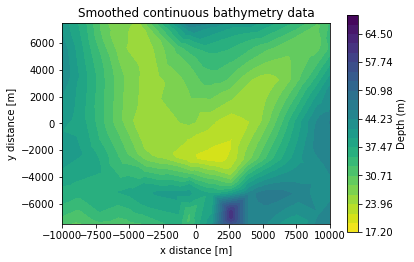

In [17]:
#SMOOTHING BATHYMETRY DATA

smooth = spline.SmoothBivariateSpline(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], s = 25000)

fig, ax = plt.subplots()
plt.xlim([-10000, 10000])
plt.ylim([-7500, 7500])
ax.set_aspect(aspect=1)
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
levels = np.linspace(mindepth,maxdepth,24)

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Smoothed continuous bathymetry data');

In [18]:
# DETERMINING DEPTH AND ASSOCIATED COST FOR EACH TURBINE

def depthvalues(positionlist):
    DepthPerTurbine = [None] * (len(positionlist)-1) # none defines a null/no value. Get a null list the size of the np. turbines
    DepthCostPerTurbine = [None] * (len(positionlist)-1) # Get a null list the size of the number of turbines
    DepthCostAllTurbines = 0 # Assigns initial value to variable

    for i in range(0,len(positionlist)-1): # loops for amount of turbines
        DepthPerTurbine[i] = spline.SmoothBivariateSpline.ev(smooth, positionlist[i+1,0], positionlist[i+1,1]) # Acquires depth assigned to each turbines position (x,y)
        DepthCostPerTurbine[i] = MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(DepthPerTurbine[i])**2) - 0.0002*(float(DepthPerTurbine[i])) + 0.9459)-CostperTurbine #Formula for depth cost
        DepthCostAllTurbines += DepthCostPerTurbine[i] # Sums up all turbines depth costs
        
    mindepth=float(min(DepthPerTurbine))
    maxdepth=float(max(DepthPerTurbine))
    return DepthCostAllTurbines, mindepth, maxdepth # returns respective values to user

depthvalues(positionlist)

(8250576.695096217, 22.346369891446553, 27.392063228618998)

In [19]:
#SETTING MODEL PARAMETERS

v0=8.0  #Incoming wind speed
nwind = 33
wind=np.arange(254,287)

#b=np.array((1,5,1000))
#b=np.array(( 1.40002561e-01,   8.51478121e+00,   2.62606729e+03))

# 3 model parameters below:

# 0th: how much power the turbine removes at the centre of the peak of the power distribution.
# 1st: how wide the angle of effect is. UNITS: degrees
# 2nd: up to how far back the effect takes place (approx. 2.6km) UNITS: [m]

model=np.array((1.39998719e-01, 8.51483871e+00, 2.62613638e+03))

ws=2.0 #weibull scale factor
wei_gamma=gamma(1.+1./ws)

Pr = 2*10**6 #Rated Power for Horns Rev 1 Turbines. Max power output [Watts]
Vc = 4.0 #Cut-in Velocity. Starts producing energy at wind speed of 4m/s [m/s]
Vr = 15.0 #Rated Velocity. Starts producing max energy at 15m/s
Vf = 25.0 #Cut-off Velocity. Turbines cut out at wind speeds of 25m/s to prevent damage to the turbines.
k = 2.0 #Weibull shape parameter
(Pr,Vc,Vr,k)

#interpolation parameters
dvel=1.5 #[m/s]
dang=5. #[degrees]

In [20]:
#DETERMINING WIND DIRECTION AND VELOCITY AT HORNS REV 1

v=np.loadtxt('hornsrev_data_all.txt') # assigns data to variable v.
vxref=v[:,3] # (INDEXING STARTS FROM 0). Third column of data is velocity of wind in x direction.
vyref=v[:,4] # (INDEXING STARTS FROM 0). Fourth column of data is velocity of wind in y direction.
angles=v[:,0] # Zeroth column of data is wind angle.
vmean=np.sqrt(np.square(vxref)+np.square(vyref)) # Uses pythagoras to find the wind magnitude + direction for each location.

vmean=pd.DataFrame(vmean) # organises vmean into labelled data structure
vref=pd.DataFrame()

vmean['angle']=angles # add another column to vmean (angle)
vref=vref.append(vmean) # add empty pandas data frame

vref=vref.groupby('angle')
vref.groups
vref.describe()
vref.get_group(260).iat[50,0] # data manipulation to group by angle etc.

6.512913707119303

In [21]:
#Arrays for pairwise distances and angles
#Angle 0: x direction. Angle pi/2: y directıon

# calculates distance and angle between each pair of turbines:

distance=np.zeros((nturb,nturb)) # 2x2 matrix of distances between turbines i and j where distance i-i and distance j-j = 0
# as they're distances to themselves: i-i i-j
                                 #    j-i j-j

angle=np.zeros((nturb,nturb)) # same as above but for angles between turbines.

for i in range(0,nturb):
   
    # 80x80 matrices as there's 80 turbines at Horns Rev 1.
    # squares y distance and x distance then sqrt to find overall distance between 2 turbines.
    distance[i,:]=np.sqrt(np.square(positionlist[i+1,0]-positionlist[1:,0])+np.square(positionlist[i+1,1]-positionlist[1:,1]))
    # same as above using arctan2 whilst giving correct quadrant (between 2 turbines).
    angle[i,:]=np.arctan2(positionlist[1:,1]-positionlist[i+1,1],positionlist[1:,0]-positionlist[i+1,0])
# Rotate angles so that north=0 and convert to degrees (and clockwise instead of anticlockwise)
angle=-np.rad2deg(angle)+270

# Rotating angles to wind direction
windangle=5 # degrees
rotangles=np.mod(angle-windangle+180,360)-180

In [22]:
# IMPORTING WIND DIRECTION DATA

#meteorological data where north = 0 degrees)
directiondata = pd.read_csv ('Directiondata.csv')
print (directiondata)
# velocity is the mean velocity with which wind from this direction blows
# c determines how wide the distribution is
# frequency/100 determines how often the wind is blowing at this angle

    Angle  Velocity     c  frequency
0       0      8.89  2.09       4.82
1      30      9.27  2.13       4.06
2      60      8.23  2.29       3.59
3      90      9.78  2.30       5.27
4     120     11.64  2.67       9.12
5     150     11.03  2.45       6.97
6     180     11.50  2.51       9.17
7     210     11.92  2.40      11.84
8     240     11.49  2.35      12.41
9     270     11.08  2.27      11.34
10    300     11.34  2.24      11.70
11    330     10.79  2.19       9.69
12    360      8.89  2.09       4.82


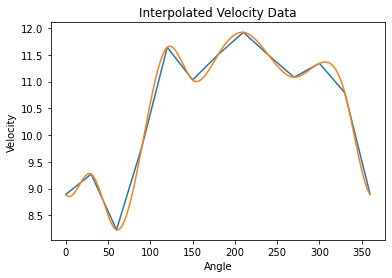

In [23]:
# interpolate 'velocity'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['Velocity']
wbvel = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360,0.10)
plt.plot(x,y, label='Line')
plt.plot(xs, wbvel(xs), label="Interpolated line ")
plt.title('Interpolated Velocity Data')
plt.xlabel('Angle')
plt.ylabel('Velocity')
plt.show()
# blue lines shows linear interpolation, orange shows smooth interpolation including across the
# periodic boundary.

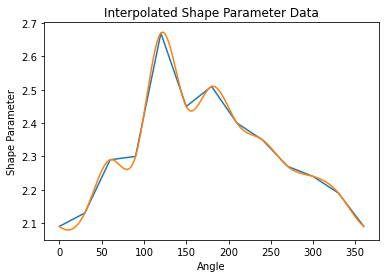

In [24]:
#interpolate 'c'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['c']
wbshape = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, wbshape(xs), label="S")
plt.title('Interpolated Shape Parameter Data')
plt.xlabel('Angle')
plt.ylabel('Shape Parameter')
plt.show()

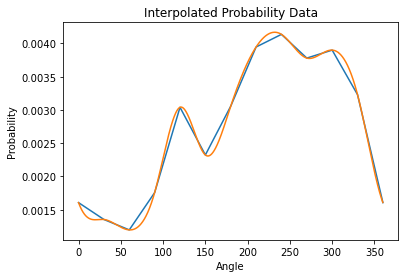

In [25]:
#interpolate 'frequency'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['frequency']/(100.*30.) #Data is in percent per 30 degrees, changing to probability per degree


windfreq = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, windfreq(xs), label="S")
plt.title('Interpolated Probability Data')
plt.xlabel('Angle')
plt.ylabel('Probability')
plt.show()
# plot shows wind direction is predominantly 200-320deg.

In [26]:
# Simple Attenuation fn
# Determines how much wind there is AFTER a turbine.
def att(dist, ang, model): 
        # 'Model' parameters are defined in 2ND CELL.

    # angular part
    angular=np.where(2.*model[1]*np.abs(ang)<np.pi,np.square(np.cos(model[1]*ang)),0.)
    # angular = np.cos(model[1]*ang WHEN 2.*model[1]*np.abs(ang) is less than pi, else angular = 0.
    
    # radial part (distance) (Gaussian Function)
    radial=np.exp(-np.square(dist/model[2])) # decreasing exponential of square, scaled by 2nd parameter
    penalty=np.exp(-np.square(dist/200))
    #penalty = 0
    return 1.0-1*model[0]*angular*radial-2*model[0]*penalty # OUTCOME

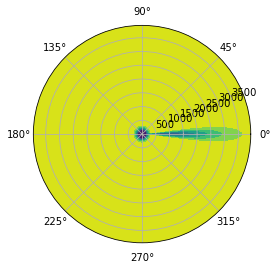

0.580003843


In [27]:
azimuths = np.radians(np.linspace(0, 360, 360)) # angles theta from 0 to 360 degress in 1 degree increments. Grid
zeniths = np.arange(0, 4000, 50) # distance from 0 to 4000 broken up into increments of 50.

r, theta = np.meshgrid(zeniths, azimuths)
values = att(r,np.mod(theta+np.pi,np.pi*2)-np.pi,model) # gets angles from -pi to pi, not from 0 to 2pi.

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta, r, np.maximum(values,0.85*np.ones(np.shape(values))))

plt.show()
print(np.min(values))

## Cell description:
# Polar plot is for 1 turbine, blue area shows where wind speed is affected. (Numbers label distance from turbine).
# Across the curve the distribution is the hump of cosine^2 function.
# Radially the distribution shown is Gaussian.
# Wake is currently too narrow close to the turbine as it treats the turbine as a point rather than accommodating
# for the blades' diameter.

In [28]:
# # isn't useful for continuing code, just rotates the windfarm.
# def rotate(angle,coords):
#     angle = np.pi*angle/180.
#     rotcoordx = []
#     rotcoordy = []
#     for coord in coords:
#         rotcoordx+=[coord[0]*np.cos(angle)-coord[1]*np.sin(angle)]
#         rotcoordy+=[coord[0]*np.sin(angle)+coord[1]*np.cos(angle)]
#     rotcoords=[rotcoordx,rotcoordy]
#     rotcoords=np.array(rotcoords).T   
#     return rotcoords 
# #print rotate(254,coords)[:,0]
# plt.scatter(rotate(0,coords)[:,0],rotate(0,coords)[:,1])

In [29]:
# returning total deviation between model and training set (between CFD data and the attenuation model)
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation(b):
    total_att=np.ones((nturb,nwind))
    deviation=0
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]*att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,b)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            deviation=deviation+np.square(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return deviation

In [30]:
# returning deviation for each turbine.
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation_sq(model):
    total_att=np.ones((nturb,nwind))
    dev_vec=np.zeros((nturb*nwind))
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,model)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            dev_vec[nturb*k+j]=(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return dev_vec

In [31]:
# USEFUL OUTPUT USED IN TARGET FN
# Calculates the % of wind that arrives at a turbine for a certain angle.
# Starts with assumption that there's zero wake so all turbines get full wind.
#talked about
#Total att
def windspeedreduction(distance,angle,direction,model): # vectors
    ndir=np.size(direction)
    total_att=np.ones((nturb,ndir)) # as many rows as there are turbines, as many columns as there are wind directions.
 #   power_vec=np.zeros((nturb,ndir))
    for j in range(0,nturb):
        for i in range(0,nturb):
            if (i!=j):
                # compounding wind speed reductions
                total_att[j,:] = total_att[j,:]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-direction[:])+np.pi,np.pi*2)-np.pi,model)
  #      power_vec[j,:]=(v0*total_att[j,:])**3
    return total_att # matrix output that's needed. n turbine rows, n direction columns.
                     # Tells how much of 100% of wind arrives at a certain turbine from a certain direction.

In [32]:
# USEFUL OUTPUT USED IN TARGET FN
# Calculates the power produced by turbines when it sees a certain wind speed at a certain angle. 3D matrix
def power(wsr,v): # wind speed reduction, velocity
    nvel=np.size(v)
    nangle=np.size(wsr,1)
    power_vec=np.zeros((nturb,nangle,nvel))
    power_vec=POvec(np.outer(wsr,v)).reshape(nturb,nangle,nvel) # np.outer takes every wsr element and individually multiplies it with every element of v.
    return power_vec

In [33]:
#GIVES PROBABILITY OF WIND SPEED V AT A GIVEN ANGLE
def windspeedprobability(angles,v,d_angle,d_vel):
    nvel=np.size(v) 
    nangle=np.size(angles)
    wsprob=np.zeros((nangle,nvel))
    for i in range(angles.shape[0]):
        # Get Weibull parameters for angle and evaluate probability
        wsprob[i,:]=(wei(v[:],wbvel(angles[i]),wbshape(angles[i])))*windfreq(angles[i])*d_angle*d_vel
    return wsprob

In [34]:
# DEFINES WEIBULL DISTRIBUTION (shows the probability of any given wind speed occuring).

def wei(x,n,k): # convention to have in this order, scale parameter comes first (x) 
    u=n/gamma(1+1/k) #scaled wind speed
    return (k / u) * (x / u)**(k - 1) * np.exp(-(x / u)**k)
# k = Weibull shape parameter
# n = scale parameter
# x= value we are valuating

In [35]:
def wind_dist(v,vm):
    return wei(v,vm,k)

In [36]:
wind_dist(1.0,v0)

0.024244336764100854

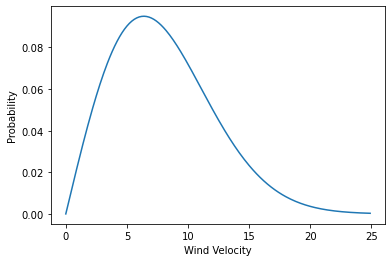

In [37]:
# PLOTS WEIBULL DISTRIBUTION

x=np.arange(0,25,0.1)
y=wind_dist(x,v0)

plt.xlabel('Wind Velocity')
plt.ylabel('Probability')
plt.plot(x,y)

In [38]:
 velocities=np.arange(Vc,Vf,dvel) # 1D array ranging from Vc to Vf in dvel intervals. 4 to 25 in steps of 1.5
angles=np.arange(0,360,dang) # 0 to 360 with intervals of dang.
wsp=windspeedprobability(angles,velocities,dang,dvel) # tells probability of getting wind from a certain direction with a certain velocity.
# sum of all numbers would add up to 1.
print(wsp,np.shape(wsp),np.sum(wsp)) # wsp array, shape of wsp (rows,columns), sum of wsp elements
print(np.shape(velocities)) # shape of velocities array (rows, columns)
#plt.plot(x,y)

[[7.95303494e-04 9.80036676e-04 1.05789271e-03 ... 6.39190809e-05
  3.40253887e-05 1.70630457e-05]
 [7.34767202e-04 9.01764403e-04 9.69915308e-04 ... 5.75583274e-05
  3.06371248e-05 1.53701909e-05]
 [6.87320078e-04 8.44491359e-04 9.10294073e-04 ... 5.77144043e-05
  3.11157981e-05 1.58295009e-05]
 ...
 [9.80182139e-04 1.25683306e-03 1.41621103e-03 ... 1.55577912e-04
  9.05953796e-05 4.99151675e-05]
 [9.27369324e-04 1.17045619e-03 1.29626789e-03 ... 1.10756647e-04
  6.20462178e-05 3.28196113e-05]
 [8.63068120e-04 1.07416013e-03 1.17166708e-03 ... 8.08008629e-05
  4.38237311e-05 2.24068824e-05]] (72, 14) 0.9458659589195532
(14,)


In [39]:
# CALCULATES THE POWER CURVE OF A TURBINE

# Plots the power curve of a turbine.
# No power output from 0-4m/s, then cubic rise up to 15m/s and stays
# constant until cut-off velocity of 25m/s.

#cubic Based Power output
a=Pr/(Vr**3-Vc**3)
b=Vc**3/(Vr**3-Vc**3)

def q(v): # q is power output

    if (v<Vc): # below cut in velocity power is 0.
        q=0
    elif (v<Vr):
        q=a*v**3-b*Pr # cubic power output between cut in and max.
    elif (v<Vf):
        q=Pr # max power between max and cut off velocity.
    else: 
        q=0 # no power above cut off velocity.
    return q

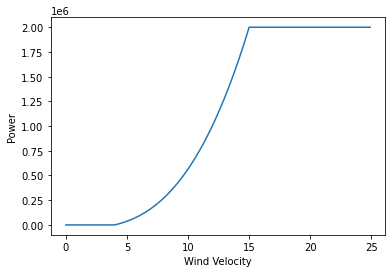

In [40]:
#PLOTS TURBINE POWER CURVE

x=np.arange(0,25,0.1)
POvec=np.vectorize(q) # vectorises power output function q (from cell above).
y=POvec(x)

plt.xlabel('Wind Velocity')
plt.ylabel('Power')
plt.plot(x,y)

In [41]:
wsr=windspeedreduction(distance,angle,angles,model)
powout=power(wsr,velocities)

In [42]:
# EXPECTED TURBINE OUTPUT (Watts) for the given wind distribution and positions.
# Can be seen that top left (NW) produces most energy for Horns Rev 1 Wind Farm.

# EXPECTED POWER FROM WIND FARM CALCULATIONS
# multiply the power that you'd get for each wind angle and speed condition by the probability of this occuring, for all angles and speed
# values and sum to find the expected power.
# Sum up this value for all turbines to find total wind farm expected power output.
output=np.zeros((nturb)) 
output=np.tensordot(powout,wsp,2)
print(output,np.shape(output),np.sum(output))
# last output is total power output in Watts.

[502026.36290166 468522.19922277 497294.04305023 517002.62184078
 543009.95969223 564042.27423936 550545.64350203 531467.56023143
 504924.83336875 478145.93162594 470400.09719016 475960.86123059
 468314.23390123 470727.21089221 487631.7075571  514308.68897549
 536323.27831969 562003.52948463 599335.87540887 642833.79673191
 610926.54085738 579501.21775468 554047.2476407  538216.13602898
 532955.26373556 501880.38699143 482690.2104955  483038.28876854
 496055.53926237 554736.61050473 529617.27865357 515880.04807505
 510560.91139873 521458.88389056 543097.34583871 591545.68870019
 589258.93050703 609508.88108205 635170.37250684 669842.90931136
 708352.78442336 779523.56019905 722459.15766114 695390.4966218
 666178.99902451 639360.36581727 617892.47113249 603626.55139115
 615149.41706765 564110.06111852 541127.22479492 530215.79078043
 537916.32443519 557292.06269233 619170.87135375] (55,) 30832575.53988459


In [43]:
# TURBINE OUTPUT (Watts) WITH NO INTERFERENCE

#Reference output:
# Same calculations as cell above except each turbine sees the full amount of wind every time
# (i.e. no wind reduction from other turbines).
refpowout=power(np.ones((nturb,np.size(angles))),velocities)
refoutput=np.zeros((nturb))
refoutput=np.tensordot(refpowout,wsp,axes=2)
print(refoutput,np.shape(refoutput),np.sum(refoutput))

# last output is total power output in Watts.

[867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078] (55,) 47693836.304443024


In [44]:
# # assigns smaller interpolation intervals to dvel and dang to compare to coarser interpolations.
# dvel=0.1
# dang=0.1
# velocities=np.arange(Vc,Vf+dvel,dvel)
# angles=np.arange(0,360,dang)
# wsp=windspeedprobability(angles,velocities,dang,dvel)
# wsr=windspeedreduction(distance,angle,angles,model)
# powout=power(wsr,velocities)
# output=np.zeros((nturb)) 
# output=np.tensordot(powout,wsp,2)
# print (dvel,dang,np.sum(output))
# fineout=output

In [45]:
# # Calculates RMS error from changing interpolation value.
# velarray=np.array([1.5])
# angarray=np.array([5])
# rmserror=np.zeros((np.size(velarray),np.size(angarray)))
# i=0
# for dvel in velarray:
#     j=0
#     for dang in angarray:
#         velocities=np.arange(Vc,Vf+dvel,dvel)
#         angles=np.arange(0,360,dang)
#         wsp=windspeedprobability(angles,velocities,dang,dvel)
#         wsr=windspeedreduction(distance,angle,angles,model)
#         powout=power(wsr,velocities)
#         output=np.zeros((nturb)) 
#         output=np.tensordot(powout,wsp,2)
#         rmserror[i,j]=np.sqrt(np.sum(np.square(output-fineout))/np.size(output))
#         print (dvel,dang,np.sum(output),rmserror[i,j])
#         j+=1
#     i+=1
# print(rmserror)

In [46]:
distance,angle,distance_global, angle_global = geom_analysis(positionlist,indiceslist)
wsr=windspeedreduction(distance_global,angle_global,angles,model)
powout=power(wsr,velocities) # total output power
output=np.tensordot(powout,wsp,axes=2)

In [47]:
#PLOTTING FUNCTION

def plotting_function(positionlist,indiceslist,MSTweight,data):

    mindepth = (depthvalues(positionlist))[1]
    maxdepth = (depthvalues(positionlist))[2]

    nturb=np.size(positionlist,0)-1 # -1 due to the substation ar positonlist[0,:]
    links = [None] * math.ceil(nturb/maxnodespertree) # math.ceil rounds a number upwards to its nearest integer
    MSTWeightSum = 0

    fig, ax = plt.subplots()
    plt.axis('equal')
    ax.set_xlabel('x distance [m]')
    ax.set_ylabel('y distance [m]')
    ax.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100])
    ax.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100])

    for a in range(0,len(MSTweight)):
        MSTWeightSum += MSTweight[a][0]
        links[a] = MSTweight[a][1]
        for b in links[a]:
            u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
            v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
            plt.plot(u,v,c='black')

    CableCost=(MSTWeightSum/1000)*CableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal =(nturb)*CostperTurbine
    MaintenanceCosts=(nturb)*MaintenanceCostperTurbine # 1563720 lifetime maintenace cost per MW (*2 cus 2MW turbines)
    # FixedCost=600000###
    LandCost = (max(positionlist[:,0])-min(positionlist[:,0])) * (max(positionlist[:,1])-min(positionlist[:,1])) * (LandCostpermSquared)
    TotalCost=TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost### 
    
    print('Maximum turbines per MST:', maximumturbinespertree)
    print('Number of turbines:', nturb)
    print()
    print('Cabling Cost: £', CableCost)
    print('Depth Cost: £', DepthCostAll)
    print('Turbine Cost: £', TurbineCostTotal)
    print('Land Cost: £', LandCost)
    print('Maintenance Cost: £', MaintenanceCosts)
    print('Fixed Cost: £', FixedCost) 
    print()
    print('\033[1m'+'Budget: £'+'\033[0m', budget)
    print('\033[1m'+'Total Cost: £'+'\033[0m', TotalCost)
        
    levels = np.linspace(mindepth-3,maxdepth+3,24) # Change to min(smooth) and max(smooth) somehow

    tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
    cbar = plt.colorbar(tcf)
    cbar.set_label('Depth (m)')
    ax.set_title('Plot showing sea floor topography and turbines with cables');
    ax.scatter(positionlist[:,0],positionlist[:,1],c='red')
    ax.scatter(0,0,c='blue')
                                                                                                  
    return TotalCost

PRE-OPTIMISED LAYOUT INFORMATION

Maximum turbines per MST: 10
Number of turbines: 55

Cabling Cost: £ 6120607.775323564
Depth Cost: £ 8250576.695096217
Turbine Cost: £ 119565217.39130437
Land Cost: £ 10976936.944873042
Maintenance Cost: £ 167569397.42721733
Fixed Cost: £ 600000

Budget: £ 300000000
Total Cost: £ 313082736.23381454
Total Power Output: 30832575.53988459 W
Cost per Watt 10.15428425136963 £/W


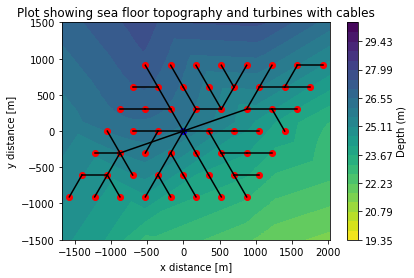

In [48]:
#DISPLAYING PRE-OPTIMISED LAYOUT AND ASSOCIATED INFO

print('\033[1m'+'\033[4m'+'PRE-OPTIMISED LAYOUT INFORMATION'+'\033[0m'+'\033[0m')
print()
MSTweight = Minimum_Spanning_Tree(distance,indiceslist)
TotalCost = plotting_function(positionlist,indiceslist,MSTweight,data)
TPO = np.sum(output)
print('\033[1m'+'Total Power Output:'+'\033[0m', TPO, 'W')
print('\033[1m'+'Cost per Watt'+'\033[0m',TotalCost/TPO,'£/W')

In [49]:
#REDUCING NO. OF TURBINES PRE-OPTIMISATION

overspend = TotalCost - budget
if overspend > 0:
    nturbstoremove = math.floor(overspend/(MinCostperTurbTot))
    ### It can be safely assumed that this many turbines at minimum can be removed.
    print('Number of removed turbines:', nturbstoremove)
    for amount in range(0,nturbstoremove):
        nturb = nturb - 1
        positionlist = np.delete(positionlist, len(positionlist)-1, 0)
    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)
    print('new number of turbines:', nturb)

Number of removed turbines: 2


C:\Users\Matthew Oxley\Documents\python anaconda\lib\site-packages\pulp\pulp.py:1313: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


new number of turbines: 53


In [50]:
#TARGET FUNCTION

# analyses the coordinates to collate the distances and angles between all of them
# calculates the minimum spanning tree length and adds the assumption of cabling costs,
# turbines costs, maintenance costs and fixed costs.

smallestindiceslist = []
smallestTotalCost = None
smallestCostPerWatt = 10000000000000.0
smallestpositionlist = []

def targetfunction(coord_flat):
    
    #Global variables are used instead of res.x as res.x only holds the coordinates, not the other associated parameters,
    #inc. the optimal clustering, which will not necessarily be the same if the clustering algorithm is run again as the
    #start position is random for clustering. Additionally, res.x only provides an approximate minimization, whereas
    #storing values as global variables and finding the minimum guarantees that the minimum value found is returned.
    
    global smallestindiceslist
    global smallestTotalCost
    global smallestCostPerWatt
    global smallestpositionlist
    
    arr1 = np.zeros((1,2),dtype=float)
    arr2=np.reshape(coord_flat,(-1,2)) # undoes the coordinate flattening
    positionlist = np.concatenate((arr1,arr2),axis=0)
    
    nturb=np.size(positionlist,0)-1
    print('nturb', nturb)

    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)
    distance,angle,distance_global,angle_global = geom_analysis(positionlist,indiceslist)
    
    MSTweight=Minimum_Spanning_Tree(distance,indiceslist)
    MSTWeightSum=0
    
    for a in range(0,math.ceil(nturb/maxnodespertree)):
        MSTWeightSum += MSTweight[a][0]
    
    CableCost=(MSTWeightSum/1000)*CableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal=(nturb)*CostperTurbine
    MaintenanceCosts=(nturb)*MaintenanceCostperTurbine
    # FixedCost=600000
    LandCost = (max(positionlist[:,0])-min(positionlist[:,0])) * (max(positionlist[:,1])-min(positionlist[:,1])) * (LandCostpermSquared)
    TotalCost=TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost
    
    wsr=windspeedreduction(distance_global,angle_global,angles,model)
    powout=power(wsr,velocities) # total output power
    output=np.tensordot(powout,wsp,axes=2)
    
    print('Total power output in Watts', np.sum(output),'Total Cost in £', TotalCost, '£/W', (TotalCost/(np.sum(output))))###

    CostperWatt = TotalCost/(np.sum(output))
    
    if CostperWatt < smallestCostPerWatt:
        smallestCostPerWatt = CostperWatt
        smallestindiceslist = indiceslist
        smallestTotalCost = TotalCost
        smallestpositionlist = positionlist
    print('smallest cost per watt',smallestCostPerWatt)
    
    return CostperWatt

In [51]:
# OPTIMIZATION

t1_start = perf_counter() # timer starts

while True:  
    
    flat_coords=positionlist[1:,:].flatten() # turns 2D coords into single list of data without any more structure.
    dvel=1.5
    dang=5
    velocities=np.arange(Vc,Vf,dvel)
    angles=np.arange(0,360,dang)

## COULD USE BASINHOPPING AND SET THE STEP SIZE

    res = minimize(targetfunction, flat_coords, method='L-BFGS-B', jac=False, hess=None, options={'disp': 2, 'eps': 50})
     
    if smallestTotalCost<=budget:
        if not res.success:
            print(res.status, res.message)
        break
    else:
        nturb = nturb - 1
        smallestindiceslist = []
        smallestTotalCost = None
        smallestCostPerWatt = 10000000000000.0
        smallestpositionlist = []
        positionlist = np.delete(positionlist, len(positionlist)-1, 0)

        # CANNOT USE CALLBACK as this only returns targetfunction output and not the other variables that are needed too.
        
t1_stop = perf_counter() # timer ends
totaltime = t1_stop - t1_start # total run time in seconds
print('Total function time:', totaltime)

nturb 53
Total power output in Watts 29832660.149007462 Total Cost in £ 301226375.2188449 £/W 10.09720131273197
smallest cost per watt 10.09720131273197
nturb 53
Total power output in Watts 29781092.816862416 Total Cost in £ 301045203.976767 £/W 10.108601649645024
smallest cost per watt 10.09720131273197
nturb 53
Total power output in Watts 29797677.65509806 Total Cost in £ 301053262.44529676 £/W 10.103245827742882
smallest cost per watt 10.09720131273197
nturb 53
Total power output in Watts 29803100.82319666 Total Cost in £ 301052458.59505486 £/W 10.101380402697446
smallest cost per watt 10.09720131273197
nturb 53
Total power output in Watts 29801262.268209364 Total Cost in £ 301107340.7572627 £/W 10.103845201163521
smallest cost per watt 10.09720131273197
nturb 53
Total power output in Watts 29788794.0873371 Total Cost in £ 301124736.7190406 £/W 10.108658169786253
smallest cost per watt 10.09720131273197
nturb 53
Total power output in Watts 29782107.24832195 Total Cost in £ 301039275

Total power output in Watts 29804063.170849025 Total Cost in £ 301157743.68411535 £/W 10.104586812803225
smallest cost per watt 10.08854827525826
nturb 53
Total power output in Watts 29807635.922343496 Total Cost in £ 300993017.44254595 £/W 10.09784936405925
smallest cost per watt 10.08854827525826
nturb 53
Total power output in Watts 29803762.18685401 Total Cost in £ 301107602.58377415 £/W 10.103006482738216
smallest cost per watt 10.08854827525826
nturb 53
Total power output in Watts 29849520.609413575 Total Cost in £ 301056826.8865182 £/W 10.085817820188863
smallest cost per watt 10.085817820188863
nturb 53
Total power output in Watts 29809658.70978106 Total Cost in £ 301039921.6163631 £/W 10.098737612101099
smallest cost per watt 10.085817820188863
nturb 53
Total power output in Watts 29868554.694209184 Total Cost in £ 301293927.8871435 £/W 10.087328662928487
smallest cost per watt 10.085817820188863
nturb 53
Total power output in Watts 29856575.90297086 Total Cost in £ 301434030.8

Total power output in Watts 29837232.237967968 Total Cost in £ 301093699.7903508 £/W 10.091207434689876
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29785708.82752625 Total Cost in £ 301033252.35980135 £/W 10.10663382573604
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29802284.407170378 Total Cost in £ 301068785.40967447 £/W 10.102204961752458
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29807628.125115015 Total Cost in £ 301127311.45049745 £/W 10.102357362569771
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29805857.82590197 Total Cost in £ 301110128.62201023 £/W 10.102380893742929
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29793434.448874775 Total Cost in £ 301033440.0114097 £/W 10.104019411658632
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29786723.82359625 Total Cost in £ 301119055.094

Total power output in Watts 29808608.94021026 Total Cost in £ 301070639.0254372 £/W 10.100123747113491
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29812292.74693706 Total Cost in £ 300958624.02915376 £/W 10.095118365563296
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29808344.346438203 Total Cost in £ 301097138.0989177 £/W 10.101102382591598
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29853996.34541429 Total Cost in £ 301239051.1588812 £/W 10.090409594531652
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29814273.082584493 Total Cost in £ 300946873.2312883 £/W 10.094053690246817
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29873077.381204545 Total Cost in £ 301228722.6929802 £/W 10.083618732983512
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29861125.59970445 Total Cost in £ 301408178.811771

Total power output in Watts 29803997.85854583 Total Cost in £ 301198510.9133675 £/W 10.105976800256801
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29820539.089594696 Total Cost in £ 301057918.382507 £/W 10.095656469455156
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29825575.358127166 Total Cost in £ 300998382.21234554 £/W 10.091955598446706
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29824075.457692374 Total Cost in £ 301155523.4212172 £/W 10.097732077174639
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29811832.0653652 Total Cost in £ 301150211.1313721 £/W 10.101700910936048
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29805027.75313125 Total Cost in £ 301081737.6857886 £/W 10.101709690713426
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29838694.29220521 Total Cost in £ 301207508.40248984

Total power output in Watts 29830765.289580602 Total Cost in £ 301084578.64994717 £/W 10.09308932329373
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29826512.53753187 Total Cost in £ 301045416.3617588 £/W 10.093215423122015
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29871736.749292657 Total Cost in £ 301157397.20392877 £/W 10.081683556985015
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29832567.530922312 Total Cost in £ 301159666.2010927 £/W 10.094996546607398
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29890997.244553022 Total Cost in £ 301353451.75420666 £/W 10.081746329461179
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29879152.8433723 Total Cost in £ 301377052.98802507 £/W 10.086532726274251
smallest cost per watt 10.08059704753372
nturb 53
Total power output in Watts 29838201.485559255 Total Cost in £ 301044530.027

Total power output in Watts 29890986.788564928 Total Cost in £ 301166840.663775 £/W 10.075506800564684
smallest cost per watt 10.06857827279825
nturb 53
Total power output in Watts 29894810.751143277 Total Cost in £ 301088195.89461 £/W 10.071587286535854
smallest cost per watt 10.06857827279825
nturb 53
Total power output in Watts 29894384.55209542 Total Cost in £ 301039237.94615626 £/W 10.070093178253947
smallest cost per watt 10.06857827279825
nturb 53
Total power output in Watts 29882902.33730174 Total Cost in £ 301163124.1601113 £/W 10.078108235965432
smallest cost per watt 10.06857827279825
nturb 53
Total power output in Watts 29875731.05165709 Total Cost in £ 301144434.5868441 £/W 10.07990177934544
smallest cost per watt 10.06857827279825
nturb 53
Total power output in Watts 29907791.72871155 Total Cost in £ 301160760.24498177 £/W 10.069642151341677
smallest cost per watt 10.06857827279825
nturb 53
Total power output in Watts 29875854.074949585 Total Cost in £ 301083818.609531 £/

Total power output in Watts 29896648.195097648 Total Cost in £ 301168907.9128323 £/W 10.073667989384074
smallest cost per watt 10.062226444129747
nturb 53
Total power output in Watts 29940182.779647704 Total Cost in £ 301175726.38691247 £/W 10.059248088212783
smallest cost per watt 10.059248088212783
nturb 53
Total power output in Watts 29903103.01537684 Total Cost in £ 301161982.52424824 £/W 10.071261914503792
smallest cost per watt 10.059248088212783
nturb 53
Total power output in Watts 29960123.793590885 Total Cost in £ 301308819.1898918 £/W 10.056995133456299
smallest cost per watt 10.056995133456299
nturb 53
Total power output in Watts 29948696.169707052 Total Cost in £ 301539118.6837861 £/W 10.068522414968813
smallest cost per watt 10.056995133456299
nturb 53
Total power output in Watts 29909263.27377239 Total Cost in £ 301180124.2961023 £/W 10.069794148363693
smallest cost per watt 10.056995133456299
nturb 53
Total power output in Watts 29962240.372525755 Total Cost in £ 3014965

Total power output in Watts 31032771.290239967 Total Cost in £ 302188467.60312015 £/W 9.737720965261024
smallest cost per watt 9.735102236185702
nturb 53
Total power output in Watts 31008261.688858263 Total Cost in £ 302090272.4333627 £/W 9.742251128572883
smallest cost per watt 9.735102236185702
nturb 53
Total power output in Watts 31008832.489941552 Total Cost in £ 302157525.523352 £/W 9.744240632773387
smallest cost per watt 9.735102236185702
nturb 53
Total power output in Watts 31035454.11477376 Total Cost in £ 302059039.2005749 £/W 9.732708858826916
smallest cost per watt 9.732708858826916
nturb 53
Total power output in Watts 31021268.139895517 Total Cost in £ 302094038.3887801 £/W 9.738287842600029
smallest cost per watt 9.732708858826916
nturb 53
Total power output in Watts 31008920.83389659 Total Cost in £ 302149526.6127165 £/W 9.743954916432617
smallest cost per watt 9.732708858826916
nturb 53
Total power output in Watts 31037207.446417227 Total Cost in £ 302216636.74661875 £/

Total power output in Watts 31031100.44059377 Total Cost in £ 302172653.30078727 £/W 9.737735659077558
smallest cost per watt 9.727089377711245
nturb 53
Total power output in Watts 31038879.58445028 Total Cost in £ 302173581.8975499 £/W 9.735325048553992
smallest cost per watt 9.727089377711245
nturb 53
Total power output in Watts 31037106.204594687 Total Cost in £ 302111213.5142365 £/W 9.733871821771594
smallest cost per watt 9.727089377711245
nturb 53
Total power output in Watts 31070886.157991327 Total Cost in £ 302349415.29849446 £/W 9.730955652860619
smallest cost per watt 9.727089377711245
nturb 53
Total power output in Watts 31067535.798957992 Total Cost in £ 302271775.232535 £/W 9.729505976546529
smallest cost per watt 9.727089377711245
nturb 53
Total power output in Watts 31056322.91206691 Total Cost in £ 302381000.60315317 £/W 9.736535824260871
smallest cost per watt 9.727089377711245
nturb 53
Total power output in Watts 31068049.88849211 Total Cost in £ 302332716.16168946 £/

Total power output in Watts 32275003.526472095 Total Cost in £ 304525320.4450065 £/W 9.435330353883106
smallest cost per watt 9.429782692847482
nturb 53
Total power output in Watts 32312116.723448236 Total Cost in £ 304380993.6136735 £/W 9.420026432152323
smallest cost per watt 9.420026432152323
nturb 53
Total power output in Watts 32238182.602570474 Total Cost in £ 304428202.2346085 £/W 9.443094419669155
smallest cost per watt 9.420026432152323
nturb 53
Total power output in Watts 32308969.004335728 Total Cost in £ 304488313.44179684 £/W 9.424265856361304
smallest cost per watt 9.420026432152323
nturb 53
Total power output in Watts 32265864.67113487 Total Cost in £ 304392749.6084841 £/W 9.433894076943634
smallest cost per watt 9.420026432152323
nturb 53
Total power output in Watts 32297175.91377395 Total Cost in £ 304423160.60298437 £/W 9.425689769771957
smallest cost per watt 9.420026432152323
nturb 53
Total power output in Watts 32241143.373316236 Total Cost in £ 304368741.02432126 

Total power output in Watts 32283512.112728346 Total Cost in £ 304528173.39877236 £/W 9.43293196649155
smallest cost per watt 9.417336939446503
nturb 53
Total power output in Watts 32286438.757244136 Total Cost in £ 304427550.96337575 £/W 9.428960352435
smallest cost per watt 9.417336939446503
nturb 53
Total power output in Watts 32298130.13208303 Total Cost in £ 304469599.65989697 £/W 9.426849121443569
smallest cost per watt 9.417336939446503
nturb 53
Total power output in Watts 32298187.352739662 Total Cost in £ 304384716.6390599 £/W 9.424204315702589
smallest cost per watt 9.417336939446503
nturb 53
Total power output in Watts 32313092.61827466 Total Cost in £ 304482352.40506536 £/W 9.4228787074644
smallest cost per watt 9.417336939446503
nturb 53
Total power output in Watts 32296126.284580547 Total Cost in £ 304622293.2710357 £/W 9.432161943721233
smallest cost per watt 9.417336939446503
nturb 53
Total power output in Watts 32259686.53823194 Total Cost in £ 304390206.6436895 £/W 9.

Total power output in Watts 33608538.144495174 Total Cost in £ 307701506.4317905 £/W 9.155456423271705
smallest cost per watt 9.122128149344677
nturb 53
Total power output in Watts 33656387.18738388 Total Cost in £ 307533260.4845112 £/W 9.13744124621285
smallest cost per watt 9.122128149344677
nturb 53
Total power output in Watts 33621285.21419343 Total Cost in £ 307534537.50670564 £/W 9.147019084710005
smallest cost per watt 9.122128149344677
nturb 53
Total power output in Watts 33549677.14490224 Total Cost in £ 307725405.8734505 £/W 9.172231510436706
smallest cost per watt 9.122128149344677
nturb 53
Total power output in Watts 33652465.493895486 Total Cost in £ 307440173.3575335 £/W 9.135739947888894
smallest cost per watt 9.122128149344677
nturb 53
Total power output in Watts 33611406.47811715 Total Cost in £ 307749247.6083556 £/W 9.156095500160548
smallest cost per watt 9.122128149344677
nturb 53
Total power output in Watts 33575844.4113575 Total Cost in £ 307436033.9826616 £/W 9.1

Total power output in Watts 33629199.42436634 Total Cost in £ 307711774.7235996 £/W 9.150136785612691
smallest cost per watt 9.122128149344677
nturb 53
Total power output in Watts 33627812.14790688 Total Cost in £ 307678736.0541845 £/W 9.149531783420992
smallest cost per watt 9.122128149344677
nturb 53
Total power output in Watts 33627827.75400581 Total Cost in £ 307989929.2143756 £/W 9.158781574218313
smallest cost per watt 9.122128149344677
nturb 53
Total power output in Watts 33631608.40013509 Total Cost in £ 307689207.5542604 £/W 9.148810365936125
smallest cost per watt 9.122128149344677
nturb 53
Total power output in Watts 33629374.500975475 Total Cost in £ 307768617.8381379 £/W 9.151779431080724
smallest cost per watt 9.122128149344677
nturb 53
Total power output in Watts 33639943.336872526 Total Cost in £ 307556673.58010876 £/W 9.142603793954608
smallest cost per watt 9.122128149344677
nturb 53
Total power output in Watts 33630563.10137549 Total Cost in £ 307877695.6179853 £/W 9

Total power output in Watts 34812314.33478779 Total Cost in £ 310048426.93570155 £/W 8.906285975531121
smallest cost per watt 8.899755362546609
nturb 53
Total power output in Watts 34836784.36194772 Total Cost in £ 310298845.6720193 £/W 8.907218371479752
smallest cost per watt 8.899755362546609
nturb 53
Total power output in Watts 34844127.307027854 Total Cost in £ 310020400.3625842 £/W 8.897350122471137
smallest cost per watt 8.897350122471137
nturb 53
Total power output in Watts 34838103.06465213 Total Cost in £ 310121854.50263196 £/W 8.901800822137519
smallest cost per watt 8.897350122471137
nturb 53
Total power output in Watts 34840883.143820874 Total Cost in £ 310014919.324959 £/W 8.898021271310425
smallest cost per watt 8.897350122471137
nturb 53
Total power output in Watts 34823031.059955716 Total Cost in £ 310051531.18933266 £/W 8.903634225737239
smallest cost per watt 8.897350122471137
nturb 53
Total power output in Watts 34827706.54866081 Total Cost in £ 310260388.5846383 £/W

Total power output in Watts 34843464.980054446 Total Cost in £ 310195063.0496024 £/W 8.902532030817495
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 34843503.57994643 Total Cost in £ 310322841.8499153 £/W 8.906189388730594
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 34846015.40297812 Total Cost in £ 310079354.41849196 £/W 8.898559873562787
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 34844649.667820424 Total Cost in £ 310200887.12193173 £/W 8.902396496424158
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 34841516.25270517 Total Cost in £ 310263236.6279865 £/W 8.90498663656456
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 34843626.598714195 Total Cost in £ 310174883.3057968 £/W 8.90191158566838
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 34839239.38753703 Total Cost in £ 310108656.1297875 £/W 8

Total power output in Watts 40043697.41673617 Total Cost in £ 396681055.9368038 £/W 9.906204509751687
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 39983782.47698501 Total Cost in £ 396659332.4728205 £/W 9.920505462461959
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 39985952.07463771 Total Cost in £ 397006069.0961225 £/W 9.928638646769537
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 39984449.032886624 Total Cost in £ 396891000.88921064 £/W 9.926134046833397
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 39984839.79578196 Total Cost in £ 397128043.8080003 £/W 9.931965360778905
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 39982367.114488326 Total Cost in £ 396568947.7908698 £/W 9.918596031478234
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 39974959.97160255 Total Cost in £ 396812067.4592124 £/W 9

Total power output in Watts 39985869.10617493 Total Cost in £ 396977938.8148443 £/W 9.927955742583569
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 39985525.23708006 Total Cost in £ 396888364.23056847 £/W 9.925800946151362
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 39986318.94924725 Total Cost in £ 398057934.1777251 £/W 9.954853175731461
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 39985675.62849953 Total Cost in £ 396793917.10904986 £/W 9.923401589999335
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 39986976.208907105 Total Cost in £ 397475609.7085573 £/W 9.94012669605209
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 40016430.45904693 Total Cost in £ 396583319.51515055 £/W 9.910512131286083
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 40023729.919061184 Total Cost in £ 396585301.152266 £/W 9

Total power output in Watts 37919193.94311324 Total Cost in £ 345799967.19235665 £/W 9.119391295899625
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 37923073.58973262 Total Cost in £ 345543047.9181757 £/W 9.111683606038959
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 37919690.99604504 Total Cost in £ 345448442.8260273 £/W 9.110001525646846
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 37922058.69181449 Total Cost in £ 345689267.7024469 £/W 9.115783257227651
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 37922727.794559136 Total Cost in £ 345711890.1516494 £/W 9.116218960421131
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 37884135.53817562 Total Cost in £ 345458338.5597818 £/W 9.118812760335139
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 37887822.75429626 Total Cost in £ 345471308.24504197 £/W 9

Total power output in Watts 37923719.433321424 Total Cost in £ 345407939.47627664 £/W 9.107965796540153
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 37924529.11377734 Total Cost in £ 346169884.2634093 £/W 9.127862424471124
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 37923178.32578377 Total Cost in £ 345312753.44313353 £/W 9.10558578388872
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 37924547.20517832 Total Cost in £ 345490089.2877941 £/W 9.109933136937228
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 37959415.407903284 Total Cost in £ 345636890.4563875 £/W 9.105432387254961
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 37945964.68355575 Total Cost in £ 345706137.3267888 £/W 9.11048487526274
smallest cost per watt 8.891934536407247
nturb 53
Total power output in Watts 37860113.82194968 Total Cost in £ 345381796.49478984 £/W 9

Total power output in Watts 35905711.83610955 Total Cost in £ 316798487.4072773 £/W 8.823066615509356
smallest cost per watt 8.821108354147064
nturb 53
Total power output in Watts 35853952.30112109 Total Cost in £ 316604265.9713455 £/W 8.830386767749612
smallest cost per watt 8.821108354147064
nturb 53
Total power output in Watts 35856298.518949755 Total Cost in £ 316526066.40285134 £/W 8.827628045197415
smallest cost per watt 8.821108354147064
nturb 53
Total power output in Watts 35863791.39953683 Total Cost in £ 316598126.7898602 £/W 8.827793003333968
smallest cost per watt 8.821108354147064
nturb 53
Total power output in Watts 35826735.54424841 Total Cost in £ 316634379.36738956 £/W 8.837935540521825
smallest cost per watt 8.821108354147064
nturb 53
Total power output in Watts 35791780.88233418 Total Cost in £ 316594431.5610007 £/W 8.845450652534108
smallest cost per watt 8.821108354147064
nturb 53
Total power output in Watts 35869886.73017147 Total Cost in £ 316349630.83171743 £/W 

Total power output in Watts 35861816.084434696 Total Cost in £ 316974757.1833995 £/W 8.838781517285675
smallest cost per watt 8.819365202110443
nturb 53
Total power output in Watts 35859165.603071876 Total Cost in £ 316501691.8820002 £/W 8.826242511757917
smallest cost per watt 8.819365202110443
nturb 53
Total power output in Watts 35861022.89666158 Total Cost in £ 316687787.3446643 £/W 8.830974739823882
smallest cost per watt 8.819365202110443
nturb 53
Total power output in Watts 35873410.92828157 Total Cost in £ 316519803.0423582 £/W 8.823242475468735
smallest cost per watt 8.819365202110443
nturb 53
Total power output in Watts 35864201.52985849 Total Cost in £ 316585765.4562498 £/W 8.827347381278752
smallest cost per watt 8.819365202110443
nturb 53
Total power output in Watts 35823425.0096262 Total Cost in £ 316559772.0321008 £/W 8.83666963577707
smallest cost per watt 8.819365202110443
nturb 53
Total power output in Watts 35862624.5534746 Total Cost in £ 316634532.2286074 £/W 8.829

Total power output in Watts 35361386.274755135 Total Cost in £ 313083323.6711404 £/W 8.85381928294632
smallest cost per watt 8.818006909942879
nturb 53
Total power output in Watts 35358788.058021404 Total Cost in £ 312771626.63832957 £/W 8.845654611382388
smallest cost per watt 8.818006909942879
nturb 53
Total power output in Watts 35361214.91542781 Total Cost in £ 312748065.3147921 £/W 8.844381225667183
smallest cost per watt 8.818006909942879
nturb 53
Total power output in Watts 35335347.195526704 Total Cost in £ 312825196.17088294 £/W 8.853038699177837
smallest cost per watt 8.818006909942879
nturb 53
Total power output in Watts 35292266.79619798 Total Cost in £ 312666530.5795437 £/W 8.859349624241963
smallest cost per watt 8.818006909942879
nturb 53
Total power output in Watts 35374078.225267984 Total Cost in £ 313056374.1860998 £/W 8.849880757104257
smallest cost per watt 8.818006909942879
nturb 53
Total power output in Watts 35408082.49692283 Total Cost in £ 312889299.3219595 £/W

Total power output in Watts 35364234.16166662 Total Cost in £ 312975396.04705715 £/W 8.850054397227968
smallest cost per watt 8.818006909942879
nturb 53
Total power output in Watts 35366678.72667089 Total Cost in £ 313041339.81510407 £/W 8.851307249810592
smallest cost per watt 8.818006909942879
nturb 53
Total power output in Watts 35372861.29742299 Total Cost in £ 312785238.27585536 £/W 8.84252013558888
smallest cost per watt 8.818006909942879
nturb 53
Total power output in Watts 35367841.342888795 Total Cost in £ 312864399.2628799 £/W 8.846013423032552
smallest cost per watt 8.818006909942879
nturb 53
Total power output in Watts 35334957.99946918 Total Cost in £ 312819290.05512255 £/W 8.852969064228741
smallest cost per watt 8.818006909942879
nturb 53
Total power output in Watts 35368310.64876928 Total Cost in £ 312612229.3441991 £/W 8.838766217833962
smallest cost per watt 8.818006909942879
nturb 53
Total power output in Watts 35373215.75363056 Total Cost in £ 313109957.30794966 £/W

Total power output in Watts 37017617.951715894 Total Cost in £ 323582873.7733885 £/W 8.741320800151305
smallest cost per watt 8.73383460602568
nturb 53
Total power output in Watts 37017467.28546629 Total Cost in £ 323397635.1634505 £/W 8.736352292000864
smallest cost per watt 8.73383460602568
nturb 53
Total power output in Watts 37010810.77760843 Total Cost in £ 323481928.1984961 £/W 8.740201076443396
smallest cost per watt 8.73383460602568
nturb 53
Total power output in Watts 37002974.81817141 Total Cost in £ 323491476.73353314 £/W 8.742309998672676
smallest cost per watt 8.73383460602568
nturb 53
Total power output in Watts 37028211.72118288 Total Cost in £ 323400834.55276465 £/W 8.733903678306868
smallest cost per watt 8.73383460602568
nturb 53
Total power output in Watts 37031018.2965548 Total Cost in £ 323643504.02998686 £/W 8.739794877855067
smallest cost per watt 8.73383460602568
nturb 53
Total power output in Watts 37045604.573677704 Total Cost in £ 323308228.0934287 £/W 8.7273

Total power output in Watts 37023601.95055199 Total Cost in £ 323453515.67589504 £/W 8.736414034158356
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 37033443.984108046 Total Cost in £ 323567367.44118947 £/W 8.737166534660943
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 37024254.641192794 Total Cost in £ 323655129.1742886 £/W 8.741705466075564
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36986912.76167532 Total Cost in £ 323551665.80471843 £/W 8.7477337697666
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 37022671.04557067 Total Cost in £ 324027059.7301771 £/W 8.752125402603633
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 37043250.53977858 Total Cost in £ 323229050.40132535 £/W 8.725720494054066
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 37037773.359871514 Total Cost in £ 323385849.701194 £/W 

Total power output in Watts 35953895.046129465 Total Cost in £ 315787130.92755383 £/W 8.783113221040265
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 35934471.67790398 Total Cost in £ 315799985.0401293 £/W 8.788218395717056
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 35903321.77213221 Total Cost in £ 315951667.56021315 £/W 8.800067847912935
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 35964090.09755142 Total Cost in £ 315844522.74064195 £/W 8.782219204876975
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 35987402.24294053 Total Cost in £ 315724657.378101 £/W 8.77319944481503
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 35975512.906847775 Total Cost in £ 316068735.56416076 £/W 8.78566308095634
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 35954405.79948337 Total Cost in £ 316068894.1120875 £/W 8

Total power output in Watts 35967276.430063404 Total Cost in £ 315975321.6187058 £/W 8.78507779795627
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 35959351.468400925 Total Cost in £ 315922949.2117833 £/W 8.785557478404437
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 35924866.97309015 Total Cost in £ 315795549.24447274 £/W 8.790444498542536
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 35958643.16291056 Total Cost in £ 315870748.98593056 £/W 8.784278860436386
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 35968610.025547996 Total Cost in £ 315875619.1360246 £/W 8.781980146346012
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 35969030.459415086 Total Cost in £ 316123826.27187514 £/W 8.788778074754251
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 35938475.20275383 Total Cost in £ 315840668.8670669 £/

Total power output in Watts 36606659.591780744 Total Cost in £ 320058602.7895362 £/W 8.743179693494858
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36588394.59700722 Total Cost in £ 320008047.08324957 £/W 8.746162563509275
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36626988.09825484 Total Cost in £ 320195770.5643895 £/W 8.742072094637939
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36637555.38770518 Total Cost in £ 320113666.4768065 £/W 8.737309656425117
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36642799.88045689 Total Cost in £ 319938613.58569044 £/W 8.731281851535774
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36619565.8116366 Total Cost in £ 320182776.6654958 £/W 8.74348915856756
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36614210.90016708 Total Cost in £ 320165216.0357755 £/W 8.7

Total power output in Watts 36622580.09684238 Total Cost in £ 320218376.9565383 £/W 8.74374159629861
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36587158.84707962 Total Cost in £ 320133800.07972765 £/W 8.749895049729467
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36622331.81205821 Total Cost in £ 320177279.9908807 £/W 8.742678692170543
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36638768.44617603 Total Cost in £ 320285288.55479825 £/W 8.741704542425095
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36635511.3792097 Total Cost in £ 320109250.4375575 £/W 8.737676598100292
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36604631.83632085 Total Cost in £ 320033449.7193345 £/W 8.742976876543317
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36637429.31811571 Total Cost in £ 320389153.56451917 £/W 8.7

Total power output in Watts 36839169.58800865 Total Cost in £ 322170631.6849466 £/W 8.745328282041811
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36869880.86503029 Total Cost in £ 322106132.53257346 £/W 8.736294367527483
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36875334.44072027 Total Cost in £ 322053837.06263006 £/W 8.733584168039332
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36886779.99844572 Total Cost in £ 322088095.9552165 £/W 8.731802991987596
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36861888.469337344 Total Cost in £ 322204858.6818903 £/W 8.740866842725882
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36856543.493853025 Total Cost in £ 322051295.69430286 £/W 8.737967947211732
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36862587.84663723 Total Cost in £ 321964065.68156844 £/

Total power output in Watts 36828948.34390804 Total Cost in £ 322053271.1822809 £/W 8.744568760827852
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36864581.11377798 Total Cost in £ 322103801.1252955 £/W 8.737487078210977
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36883539.924216054 Total Cost in £ 321968471.31824285 £/W 8.729326739781097
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36878883.90534054 Total Cost in £ 322215414.15826446 £/W 8.737124881146512
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36848528.45792971 Total Cost in £ 321967658.16080236 £/W 8.737598803393077
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36880942.96923383 Total Cost in £ 322956705.8030402 £/W 8.756736672173796
smallest cost per watt 8.717312881767809
nturb 53
Total power output in Watts 36812814.23298238 Total Cost in £ 322090318.4683751 £/W 

Total power output in Watts 36968656.5769928 Total Cost in £ 319862327.00710803 £/W 8.652257253139467
smallest cost per watt 8.645934196969765
nturb 53
Total power output in Watts 36967440.82018648 Total Cost in £ 319862037.65802205 £/W 8.65253397479865
smallest cost per watt 8.645934196969765
nturb 53
Total power output in Watts 36965042.27676951 Total Cost in £ 319722747.1140036 £/W 8.64932724058946
smallest cost per watt 8.645934196969765
nturb 53
Total power output in Watts 36967693.912366636 Total Cost in £ 319738843.71552926 £/W 8.64914226117222
smallest cost per watt 8.645934196969765
nturb 53
Total power output in Watts 36963251.62853588 Total Cost in £ 319839494.7622269 £/W 8.652904727551313
smallest cost per watt 8.645934196969765
nturb 53
Total power output in Watts 36969749.272219494 Total Cost in £ 319726605.23393816 £/W 8.648330365448087
smallest cost per watt 8.645934196969765
nturb 53
Total power output in Watts 36966084.58640593 Total Cost in £ 319594461.4857292 £/W 8.

Total power output in Watts 36969797.60976102 Total Cost in £ 320107204.4071038 £/W 8.658613925508396
smallest cost per watt 8.645613000714127
nturb 53
Total power output in Watts 36966691.19168509 Total Cost in £ 319695143.0172641 £/W 8.648194704782588
smallest cost per watt 8.645613000714127
nturb 53
Total power output in Watts 36972517.007656485 Total Cost in £ 319754526.55693644 £/W 8.648438149091115
smallest cost per watt 8.645613000714127
nturb 53
Total power output in Watts 36961366.97791144 Total Cost in £ 319751100.1273364 £/W 8.650954395664627
smallest cost per watt 8.645613000714127
nturb 53
Total power output in Watts 37002042.735536255 Total Cost in £ 319943418.66009074 £/W 8.646642050192042
smallest cost per watt 8.645613000714127
nturb 53
Total power output in Watts 36910992.44265819 Total Cost in £ 319866598.02649176 £/W 8.665889938435265
smallest cost per watt 8.645613000714127
nturb 53
Total power output in Watts 36963706.99644331 Total Cost in £ 319794092.6949517 £/W

Total power output in Watts 37335167.834961295 Total Cost in £ 325329500.5524407 £/W 8.713754870221758
smallest cost per watt 8.64426726553712
nturb 53
Total power output in Watts 37339198.19145362 Total Cost in £ 325724260.4909665 £/W 8.723386582133942
smallest cost per watt 8.64426726553712
nturb 53
Total power output in Watts 37335357.51034192 Total Cost in £ 325454268.9118222 £/W 8.717052430036894
smallest cost per watt 8.64426726553712
nturb 53
Total power output in Watts 37340601.43701114 Total Cost in £ 325421964.8247844 £/W 8.714963131317797
smallest cost per watt 8.64426726553712
nturb 53
Total power output in Watts 37337054.20462625 Total Cost in £ 325456497.2647952 £/W 8.716715986245896
smallest cost per watt 8.64426726553712
nturb 53
Total power output in Watts 37340540.22612017 Total Cost in £ 325530484.03709114 £/W 8.717883621013565
smallest cost per watt 8.64426726553712
nturb 53
Total power output in Watts 37339807.05094749 Total Cost in £ 325332207.78607416 £/W 8.71274

Total power output in Watts 37353557.755364776 Total Cost in £ 325323208.1838445 £/W 8.709296456162093
smallest cost per watt 8.64426726553712
nturb 53
Total power output in Watts 37399890.63242761 Total Cost in £ 325774201.53922117 £/W 8.710565620123988
smallest cost per watt 8.64426726553712
nturb 53
Total power output in Watts 37271407.38677436 Total Cost in £ 325333145.5385111 £/W 8.728759345265683
smallest cost per watt 8.64426726553712
nturb 53
Total power output in Watts 37345024.393168494 Total Cost in £ 325613368.1397251 £/W 8.719056244592771
smallest cost per watt 8.64426726553712
nturb 53
Total power output in Watts 37330216.98466211 Total Cost in £ 325601627.1217449 £/W 8.72220022871887
smallest cost per watt 8.64426726553712
nturb 53
Total power output in Watts 37339006.31082915 Total Cost in £ 325292189.53977466 £/W 8.711859839864903
smallest cost per watt 8.64426726553712
nturb 53
Total power output in Watts 37334658.20787143 Total Cost in £ 325481943.3059179 £/W 8.71795

Total power output in Watts 37159274.44466109 Total Cost in £ 321508818.3315943 £/W 8.652182345766644
smallest cost per watt 8.64426726553712
nturb 53
Total power output in Watts 37155301.15281409 Total Cost in £ 321614967.758519 £/W 8.655964499810286
smallest cost per watt 8.64426726553712
nturb 53
Total power output in Watts 37158915.99082435 Total Cost in £ 321556655.6533674 £/W 8.653553180420262
smallest cost per watt 8.64426726553712
nturb 53
Total power output in Watts 37157724.99173405 Total Cost in £ 321493456.07077885 £/W 8.652129702297353
smallest cost per watt 8.64426726553712
nturb 53
Total power output in Watts 37143602.960921206 Total Cost in £ 321598394.59707975 £/W 8.658244460975784
smallest cost per watt 8.64426726553712
nturb 53
Total power output in Watts 37137149.79680673 Total Cost in £ 321511081.5500664 £/W 8.657397870035568
smallest cost per watt 8.64426726553712
nturb 53
Total power output in Watts 37158740.13794462 Total Cost in £ 321478762.8168481 £/W 8.651497

Total power output in Watts 37097731.744012974 Total Cost in £ 321175614.1566523 £/W 8.657553954319196
smallest cost per watt 8.641720849368241
nturb 53
Total power output in Watts 37156046.114922136 Total Cost in £ 321469543.55052495 £/W 8.651877074224549
smallest cost per watt 8.641720849368241
nturb 53
Total power output in Watts 37142372.26916976 Total Cost in £ 321571225.45279765 £/W 8.657799860557633
smallest cost per watt 8.641720849368241
nturb 53
Total power output in Watts 37159259.09572899 Total Cost in £ 321525606.66528684 £/W 8.652637713711636
smallest cost per watt 8.641720849368241
nturb 53
Total power output in Watts 37153862.41029936 Total Cost in £ 321833908.912562 £/W 8.662192516042342
smallest cost per watt 8.641720849368241
nturb 53
Total power output in Watts 37159775.864468254 Total Cost in £ 321476371.60158205 £/W 8.651192428449871
smallest cost per watt 8.641720849368241
nturb 53
Total power output in Watts 37148210.761785604 Total Cost in £ 321430543.21703875 

Total power output in Watts 37029383.8008819 Total Cost in £ 320277325.84531504 £/W 8.649275061328114
smallest cost per watt 8.641720849368241
nturb 53
Total power output in Watts 37032436.85030626 Total Cost in £ 320310381.3358814 £/W 8.649454601938583
smallest cost per watt 8.641720849368241
nturb 53
Total power output in Watts 37031092.86820116 Total Cost in £ 320391268.7542471 £/W 8.651952830411041
smallest cost per watt 8.641720849368241
nturb 53
Total power output in Watts 37022987.610548794 Total Cost in £ 320432505.3297918 £/W 8.654960769251707
smallest cost per watt 8.641720849368241
nturb 53
Total power output in Watts 37018272.2526831 Total Cost in £ 320427001.84960276 £/W 8.655914561933075
smallest cost per watt 8.641720849368241
nturb 53
Total power output in Watts 37032010.49842073 Total Cost in £ 320462510.54918784 £/W 8.653662229947097
smallest cost per watt 8.641720849368241
nturb 53
Total power output in Watts 37034501.83774421 Total Cost in £ 320353915.2857923 £/W 8.

Total power output in Watts 37028512.240459576 Total Cost in £ 320446035.6250818 £/W 8.654034856818882
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 37014336.26264267 Total Cost in £ 320284818.1663004 £/W 8.652993691245875
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 37033541.271958254 Total Cost in £ 320397865.8585888 £/W 8.65155896125963
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 37027495.34594661 Total Cost in £ 320615422.3102316 £/W 8.658847143581623
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 37033993.14087338 Total Cost in £ 320340950.7940133 £/W 8.649916566530386
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 37021049.78418592 Total Cost in £ 320447231.4508275 £/W 8.655811580678384
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 37025238.97372112 Total Cost in £ 320588734.99551076 £/W 8.

Total power output in Watts 36988051.0691437 Total Cost in £ 320103226.25728947 £/W 8.654233380907357
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36986665.11106063 Total Cost in £ 319815678.1928386 £/W 8.64678329967088
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36979804.36440804 Total Cost in £ 319992792.8902844 £/W 8.65317700810413
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36975704.575654484 Total Cost in £ 320000565.6091386 £/W 8.654346665778835
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36987629.71508507 Total Cost in £ 319955944.39336574 £/W 8.65035004562281
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36990192.42473098 Total Cost in £ 320043005.93580997 £/W 8.652104381101704
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36985798.63157265 Total Cost in £ 320171385.11623716 £/W 8.6

Total power output in Watts 36969540.97886327 Total Cost in £ 320140750.0322357 £/W 8.659581416368434
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36988948.07193096 Total Cost in £ 320041971.61202586 £/W 8.652367485272974
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36983077.02864387 Total Cost in £ 320001085.1973491 £/W 8.65263550000191
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36990051.10438976 Total Cost in £ 320030199.5351233 £/W 8.651791224401526
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36976503.00576158 Total Cost in £ 320110693.8256852 £/W 8.657138122980598
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36980704.102736324 Total Cost in £ 320130134.37920535 £/W 8.656680345778431
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36980121.40436951 Total Cost in £ 320027979.5803961 £/W 8.

Total power output in Watts 36972237.81210511 Total Cost in £ 319780303.0899355 £/W 8.64920064387436
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36965679.49508634 Total Cost in £ 319766852.51693845 £/W 8.650371287221798
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36961803.980553724 Total Cost in £ 319782871.0857747 £/W 8.651711676573424
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36973209.28471159 Total Cost in £ 319883376.91420865 £/W 8.651761183373397
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36975787.674513966 Total Cost in £ 319802057.4713623 £/W 8.64895861817678
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36971418.89147916 Total Cost in £ 319875372.03802687 £/W 8.651963641886324
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36972123.87290157 Total Cost in £ 319839627.3106243 £/W 8

Total power output in Watts 36974374.32144154 Total Cost in £ 319923786.32626766 £/W 8.652581475617913
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36968701.65759913 Total Cost in £ 319984929.5309362 £/W 8.655563089410295
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36975810.706625454 Total Cost in £ 319723096.76577437 £/W 8.646817761550398
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36962070.537872694 Total Cost in £ 319949940.2129586 £/W 8.656169298879675
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36966349.83837064 Total Cost in £ 319970292.71519667 £/W 8.655717811312579
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36965775.13263413 Total Cost in £ 319690663.6827983 £/W 8.648287842896305
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36965194.18721887 Total Cost in £ 319865966.385868 £/W 

Total power output in Watts 36961599.90184864 Total Cost in £ 319760203.56907064 £/W 8.651146173818027
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36957789.11811768 Total Cost in £ 319848902.849608 £/W 8.654438224845263
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36969059.248703845 Total Cost in £ 319847208.11079955 £/W 8.651754050842221
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36971643.78255359 Total Cost in £ 319905576.2307697 £/W 8.652727969366856
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36967269.435160436 Total Cost in £ 319839595.6009221 £/W 8.651967009949487
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36967950.526807405 Total Cost in £ 319996520.4438779 £/W 8.656052496386879
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36980736.8680582 Total Cost in £ 319673772.10737425 £/W 

Total power output in Watts 36964555.91033442 Total Cost in £ 319748249.35542953 £/W 8.650130956017666
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36971709.77288866 Total Cost in £ 319835158.3904079 £/W 8.65080788405796
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36957921.41982176 Total Cost in £ 319783805.7778118 £/W 8.652645860281016
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36962204.92115479 Total Cost in £ 319820546.2259337 £/W 8.652637116972667
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36961631.7984139 Total Cost in £ 320069889.89141047 £/W 8.659517297208327
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36961019.39034757 Total Cost in £ 319641006.48074484 £/W 8.648057108625624
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36961974.49725492 Total Cost in £ 319697575.47427005 £/W 8.

Total power output in Watts 36958093.727711916 Total Cost in £ 319753574.3823077 £/W 8.651787528276929
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36969373.52603562 Total Cost in £ 319948888.7376234 £/W 8.654430903793918
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36971957.469415255 Total Cost in £ 319565594.094454 £/W 8.643458879850005
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36967584.17126602 Total Cost in £ 319845309.4897691 £/W 8.652047913327722
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36968267.02132509 Total Cost in £ 319707541.4196601 £/W 8.64816144168287
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36981046.44723229 Total Cost in £ 319785573.7336286 £/W 8.647282985621455
smallest cost per watt 8.641518061348316
nturb 53
Total power output in Watts 36978519.0787975 Total Cost in £ 319978481.2684866 £/W 8.653

Total power output in Watts 36972020.81647856 Total Cost in £ 319702724.2842124 £/W 8.647153096422574
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36958235.71541352 Total Cost in £ 320042364.197004 £/W 8.659568239712526
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36962519.87168322 Total Cost in £ 319690823.5955334 £/W 8.649053817362889
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36961945.613316655 Total Cost in £ 319913923.12630135 £/W 8.65522411815472
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36961336.00680417 Total Cost in £ 319726555.5005047 £/W 8.650297582361379
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36962290.043108605 Total Cost in £ 319699645.42444944 £/W 8.649346267549662
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36964719.67710147 Total Cost in £ 319749352.09623486 £/W 8

Total power output in Watts 36969082.47085222 Total Cost in £ 319520151.2970532 £/W 8.642901850457735
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36971666.90152137 Total Cost in £ 319868805.4873192 £/W 8.65172799320435
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36967292.53989863 Total Cost in £ 319915727.68033266 £/W 8.654021046714446
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36967973.59598619 Total Cost in £ 319882941.2205044 £/W 8.652974726622176
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36980759.63215374 Total Cost in £ 319871360.0925076 £/W 8.649669808685822
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36978233.022407085 Total Cost in £ 319855755.7163246 £/W 8.649838826060373
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36984682.910640754 Total Cost in £ 319725794.17345846 £/W 8

Total power output in Watts 36957944.349297315 Total Cost in £ 319781970.2490597 £/W 8.652590826663218
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36962227.96269061 Total Cost in £ 319807312.3867595 £/W 8.652273686249936
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36961654.85389774 Total Cost in £ 319820295.62505615 £/W 8.652759106410246
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36961042.71505239 Total Cost in £ 319969694.748349 £/W 8.656944481115554
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36961997.48879575 Total Cost in £ 319470641.41761184 £/W 8.643219066135499
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36964423.901972055 Total Cost in £ 319853483.5557184 £/W 8.653008752522563
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36943193.060044914 Total Cost in £ 319846162.23868513 £/W

Total power output in Watts 36971643.78255359 Total Cost in £ 319981879.4809147 £/W 8.65479180105889
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36967269.435160436 Total Cost in £ 319920972.6828023 £/W 8.654168337857218
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36967950.526807405 Total Cost in £ 319750659.8900418 £/W 8.649401855755402
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36980736.8680582 Total Cost in £ 320031555.4292639 £/W 8.65400699210211
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36978210.270071045 Total Cost in £ 319746146.86242014 £/W 8.64688000114522
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36984660.074918434 Total Cost in £ 319653775.01704854 £/W 8.642874488221276
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36928549.43427593 Total Cost in £ 319892082.0608505 £/W 8.

Total power output in Watts 36962204.92115479 Total Cost in £ 319864894.3644853 £/W 8.653836940918403
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36961631.7984139 Total Cost in £ 319878136.9701807 £/W 8.654329406092598
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36961019.39034757 Total Cost in £ 319903489.11991715 £/W 8.655158715764763
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36961974.49725492 Total Cost in £ 319743379.60743105 £/W 8.650603328325374
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36964400.309445746 Total Cost in £ 319926140.81422853 £/W 8.654979876204722
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36943168.80613357 Total Cost in £ 320020396.5558537 £/W 8.662505326362844
smallest cost per watt 8.638606463099128
nturb 53
Total power output in Watts 36960534.62611399 Total Cost in £ 319798546.7997196 £/W 8

Total power output in Watts 29396515.016460758 Total Cost in £ 295588931.18819785 £/W 10.055237194704237
smallest cost per watt 10.045895225162262
nturb 52
Total power output in Watts 29394087.815751962 Total Cost in £ 295512391.7491011 £/W 10.05346359449669
smallest cost per watt 10.045895225162262
nturb 52
Total power output in Watts 29393789.45023801 Total Cost in £ 295651235.99160755 £/W 10.058289234606107
smallest cost per watt 10.045895225162262
nturb 52
Total power output in Watts 29393995.910132356 Total Cost in £ 295569829.82573813 £/W 10.055449103599171
smallest cost per watt 10.045895225162262
nturb 52
Total power output in Watts 29391780.380684774 Total Cost in £ 295689048.5100834 £/W 10.060263266814543
smallest cost per watt 10.045895225162262
nturb 52
Total power output in Watts 29396731.67206774 Total Cost in £ 295665414.65236586 £/W 10.057764854631849
smallest cost per watt 10.045895225162262
nturb 52
Total power output in Watts 29389470.434843633 Total Cost in £ 295680

Total power output in Watts 29421136.746415593 Total Cost in £ 295601323.7178524 £/W 10.047243458527
smallest cost per watt 10.036052476664377
nturb 52
Total power output in Watts 29353918.76153063 Total Cost in £ 295517055.39932024 £/W 10.067380025136746
smallest cost per watt 10.036052476664377
nturb 52
Total power output in Watts 29421417.79673394 Total Cost in £ 295629610.4395568 £/W 10.04810891446484
smallest cost per watt 10.036052476664377
nturb 52
Total power output in Watts 29358158.16768554 Total Cost in £ 295425446.82405484 £/W 10.062805886413848
smallest cost per watt 10.036052476664377
nturb 52
Total power output in Watts 29384127.855691966 Total Cost in £ 295524732.72766703 £/W 10.057291275719155
smallest cost per watt 10.036052476664377
nturb 52
Total power output in Watts 29391035.11007434 Total Cost in £ 295591056.9881478 £/W 10.057184304027057
smallest cost per watt 10.036052476664377
nturb 52
Total power output in Watts 29348222.781470396 Total Cost in £ 295617400.54

Total power output in Watts 29397747.75159665 Total Cost in £ 295644403.2995039 £/W 10.056702499716051
smallest cost per watt 10.0298188332604
nturb 52
Total power output in Watts 29398002.582885794 Total Cost in £ 295667996.40325505 £/W 10.057417866048484
smallest cost per watt 10.0298188332604
nturb 52
Total power output in Watts 29395721.463646535 Total Cost in £ 295577172.0290425 £/W 10.05510861145492
smallest cost per watt 10.0298188332604
nturb 52
Total power output in Watts 29400762.237514645 Total Cost in £ 295571667.751557 £/W 10.05319744310625
smallest cost per watt 10.0298188332604
nturb 52
Total power output in Watts 29393386.3922893 Total Cost in £ 295573156.86260396 £/W 10.055770809046384
smallest cost per watt 10.0298188332604
nturb 52
Total power output in Watts 29396248.118166246 Total Cost in £ 295446155.20569044 £/W 10.050471543785587
smallest cost per watt 10.0298188332604
nturb 52
Total power output in Watts 29392244.93303079 Total Cost in £ 295573993.9984486 £/W 1

Total power output in Watts 29362163.794366922 Total Cost in £ 295368851.16746616 £/W 10.059505601699971
smallest cost per watt 10.0298188332604
nturb 52
Total power output in Watts 29388114.3423836 Total Cost in £ 295498737.99893165 £/W 10.055042475888381
smallest cost per watt 10.0298188332604
nturb 52
Total power output in Watts 29394950.473101288 Total Cost in £ 295679130.4019105 £/W 10.058840911212977
smallest cost per watt 10.0298188332604
nturb 52
Total power output in Watts 29352327.956007194 Total Cost in £ 295745247.7746454 £/W 10.075699897394976
smallest cost per watt 10.0298188332604
nturb 52
Total power output in Watts 29394550.589796145 Total Cost in £ 295592721.60513616 £/W 10.056038132038886
smallest cost per watt 10.0298188332604
nturb 52
Total power output in Watts 29351234.989723414 Total Cost in £ 295552141.688333 £/W 10.06949594426991
smallest cost per watt 10.0298188332604
nturb 52
Total power output in Watts 29395760.315953888 Total Cost in £ 295487201.52737963 £

Total power output in Watts 29416726.410546195 Total Cost in £ 295571155.6042463 £/W 10.047724259973437
smallest cost per watt 10.029229458552708
nturb 52
Total power output in Watts 29408890.306021053 Total Cost in £ 295607576.7339477 £/W 10.05163995165864
smallest cost per watt 10.029229458552708
nturb 52
Total power output in Watts 29411872.9410173 Total Cost in £ 295667191.52181584 £/W 10.052647518053275
smallest cost per watt 10.029229458552708
nturb 52
Total power output in Watts 29407848.978836946 Total Cost in £ 295847484.8102037 £/W 10.060153839306889
smallest cost per watt 10.029229458552708
nturb 52
Total power output in Watts 29410751.09013125 Total Cost in £ 295667415.3884862 £/W 10.053038580429085
smallest cost per watt 10.029229458552708
nturb 52
Total power output in Watts 29405835.72555171 Total Cost in £ 295669378.18326217 £/W 10.054785755548012
smallest cost per watt 10.029229458552708
nturb 52
Total power output in Watts 29407891.520044807 Total Cost in £ 295612689.

Total power output in Watts 29368586.242158156 Total Cost in £ 295591383.8741357 £/W 10.064882982001318
smallest cost per watt 10.029229458552708
nturb 52
Total power output in Watts 29410196.856588133 Total Cost in £ 295610483.05250376 £/W 10.051292226773535
smallest cost per watt 10.029229458552708
nturb 52
Total power output in Watts 29367141.062676862 Total Cost in £ 295593927.36874616 £/W 10.0654648928159
smallest cost per watt 10.029229458552708
nturb 52
Total power output in Watts 29411605.97307646 Total Cost in £ 295591980.85067976 £/W 10.050181588902905
smallest cost per watt 10.029229458552708
nturb 52
Total power output in Watts 29368782.231125373 Total Cost in £ 295604495.9445947 £/W 10.065262278097103
smallest cost per watt 10.029229458552708
nturb 52
Total power output in Watts 29412643.64325363 Total Cost in £ 295591517.1043181 £/W 10.049811254287503
smallest cost per watt 10.029229458552708
nturb 52
Total power output in Watts 29369723.31316738 Total Cost in £ 295668558

Total power output in Watts 29468137.81971284 Total Cost in £ 295636559.4760942 £/W 10.032414035960114
smallest cost per watt 10.01858287979157
nturb 52
Total power output in Watts 29472872.608187363 Total Cost in £ 295605819.48963296 £/W 10.029759345803154
smallest cost per watt 10.01858287979157
nturb 52
Total power output in Watts 29464741.409760173 Total Cost in £ 295635449.22632486 £/W 10.033532794840543
smallest cost per watt 10.01858287979157
nturb 52
Total power output in Watts 29468906.889169388 Total Cost in £ 295724157.6339378 £/W 10.035124775619835
smallest cost per watt 10.01858287979157
nturb 52
Total power output in Watts 29464883.519257896 Total Cost in £ 295555110.82479316 £/W 10.03075782164969
smallest cost per watt 10.01858287979157
nturb 52
Total power output in Watts 29466106.96588373 Total Cost in £ 295627786.10081923 £/W 10.032807742234194
smallest cost per watt 10.01858287979157
nturb 52
Total power output in Watts 29468067.016159344 Total Cost in £ 295622807.56

Total power output in Watts 29472841.43989498 Total Cost in £ 295657250.8190171 £/W 10.031514993963562
smallest cost per watt 10.010639223784313
nturb 52
Total power output in Watts 29430543.528126147 Total Cost in £ 295798022.9330828 £/W 10.050715599268322
smallest cost per watt 10.010639223784313
nturb 52
Total power output in Watts 29472359.43827403 Total Cost in £ 295683250.6386385 £/W 10.032561229375208
smallest cost per watt 10.010639223784313
nturb 52
Total power output in Watts 29431533.342832256 Total Cost in £ 295560320.86861265 £/W 10.04230114094933
smallest cost per watt 10.010639223784313
nturb 52
Total power output in Watts 29476871.397324763 Total Cost in £ 295730588.88791376 £/W 10.032631513083626
smallest cost per watt 10.010639223784313
nturb 52
Total power output in Watts 29431319.15904064 Total Cost in £ 295628471.1643095 £/W 10.044689793440641
smallest cost per watt 10.010639223784313
nturb 52
Total power output in Watts 29482892.62781919 Total Cost in £ 295636739.

Total power output in Watts 30470231.905848753 Total Cost in £ 296563381.6863384 £/W 9.732888893090871
smallest cost per watt 9.72225965100401
nturb 52
Total power output in Watts 30433202.691329174 Total Cost in £ 296621498.3044473 £/W 9.746640907726702
smallest cost per watt 9.72225965100401
nturb 52
Total power output in Watts 30450489.18916911 Total Cost in £ 296495159.52900696 £/W 9.736958828052815
smallest cost per watt 9.72225965100401
nturb 52
Total power output in Watts 30447734.34141181 Total Cost in £ 296600865.9424164 £/W 9.741311541168141
smallest cost per watt 9.72225965100401
nturb 52
Total power output in Watts 30432732.00601634 Total Cost in £ 296525667.0861177 £/W 9.743642701138254
smallest cost per watt 9.72225965100401
nturb 52
Total power output in Watts 30470294.84164978 Total Cost in £ 296700177.9758262 £/W 9.737358286742516
smallest cost per watt 9.72225965100401
nturb 52
Total power output in Watts 30442749.654036332 Total Cost in £ 296426545.64221 £/W 9.737180

Total power output in Watts 30439661.93594223 Total Cost in £ 296623633.2178123 £/W 9.744642822973278
smallest cost per watt 9.720547639870064
nturb 52
Total power output in Watts 30466348.86701631 Total Cost in £ 296574239.98127675 £/W 9.734485785474478
smallest cost per watt 9.720547639870064
nturb 52
Total power output in Watts 30438287.609599896 Total Cost in £ 296487241.8615222 £/W 9.740601891415647
smallest cost per watt 9.720547639870064
nturb 52
Total power output in Watts 30485988.52022065 Total Cost in £ 296481409.88863456 £/W 9.725169636273574
smallest cost per watt 9.720547639870064
nturb 52
Total power output in Watts 30441537.468723696 Total Cost in £ 296483633.4376897 £/W 9.739443473980364
smallest cost per watt 9.720547639870064
nturb 52
Total power output in Watts 30488939.26642993 Total Cost in £ 296517201.27407986 £/W 9.725402339613773
smallest cost per watt 9.720547639870064
nturb 52
Total power output in Watts 30440482.705681693 Total Cost in £ 296363719.37000865 £

Total power output in Watts 31659045.51211971 Total Cost in £ 298361310.84292316 £/W 9.424204236628187
smallest cost per watt 9.401286427945303
nturb 52
Total power output in Watts 31675013.909147885 Total Cost in £ 298304914.4602935 £/W 9.417672721972876
smallest cost per watt 9.401286427945303
nturb 52
Total power output in Watts 31673732.197340917 Total Cost in £ 298344080.9962181 £/W 9.419290380350716
smallest cost per watt 9.401286427945303
nturb 52
Total power output in Watts 31641488.734550826 Total Cost in £ 298436781.3945469 £/W 9.431818581553333
smallest cost per watt 9.401286427945303
nturb 52
Total power output in Watts 31673014.947282724 Total Cost in £ 298400088.433487 £/W 9.421271985952421
smallest cost per watt 9.401286427945303
nturb 52
Total power output in Watts 31668214.83849205 Total Cost in £ 298298321.65683794 £/W 9.419486484418522
smallest cost per watt 9.401286427945303
nturb 52
Total power output in Watts 31686510.86328218 Total Cost in £ 298204523.71253014 £/

Total power output in Watts 31685325.297297407 Total Cost in £ 298220345.08973 £/W 9.411938879957361
smallest cost per watt 9.401286427945303
nturb 52
Total power output in Watts 31665039.457714602 Total Cost in £ 298158770.83602655 £/W 9.416023979195948
smallest cost per watt 9.401286427945303
nturb 52
Total power output in Watts 31690699.52450807 Total Cost in £ 298230381.4350871 £/W 9.41065946507271
smallest cost per watt 9.401286427945303
nturb 52
Total power output in Watts 31656415.52318004 Total Cost in £ 298396288.0045406 £/W 9.426092091381712
smallest cost per watt 9.401286427945303
nturb 52
Total power output in Watts 31695603.271601316 Total Cost in £ 298271352.53535473 £/W 9.410496149243528
smallest cost per watt 9.401286427945303
nturb 52
Total power output in Watts 31663816.140088975 Total Cost in £ 298379890.4067743 £/W 9.423371115050184
smallest cost per watt 9.401286427945303
nturb 52
Total power output in Watts 31697955.438974082 Total Cost in £ 298173419.554036 £/W 9

Total power output in Watts 33591828.63504187 Total Cost in £ 303654617.16066253 £/W 9.03953817041982
smallest cost per watt 9.011341470832283
nturb 52
Total power output in Watts 33633993.47472449 Total Cost in £ 303347755.09938216 £/W 9.019082296229382
smallest cost per watt 9.011341470832283
nturb 52
Total power output in Watts 33602944.83814448 Total Cost in £ 303282478.1578439 £/W 9.025473202383498
smallest cost per watt 9.011341470832283
nturb 52
Total power output in Watts 33608947.24202211 Total Cost in £ 303357448.8650735 £/W 9.02609197130037
smallest cost per watt 9.011341470832283
nturb 52
Total power output in Watts 33580302.246214256 Total Cost in £ 303405160.72947395 £/W 9.035212324918218
smallest cost per watt 9.011341470832283
nturb 52
Total power output in Watts 33629125.02452541 Total Cost in £ 303376055.4977319 £/W 9.021229522816386
smallest cost per watt 9.011341470832283
nturb 52
Total power output in Watts 33633116.71103546 Total Cost in £ 303490639.8138314 £/W 9.

Total power output in Watts 33606770.748008676 Total Cost in £ 303466218.82403284 £/W 9.029913082083745
smallest cost per watt 9.011341470832283
nturb 52
Total power output in Watts 33621507.05527725 Total Cost in £ 303484101.2339147 £/W 9.026487145116823
smallest cost per watt 9.011341470832283
nturb 52
Total power output in Watts 33611358.38601578 Total Cost in £ 303562769.46148247 £/W 9.031553142695408
smallest cost per watt 9.011341470832283
nturb 52
Total power output in Watts 33620928.85359553 Total Cost in £ 303446613.9181372 £/W 9.025527380267057
smallest cost per watt 9.011341470832283
nturb 52
Total power output in Watts 33612788.92519353 Total Cost in £ 303326315.04854906 £/W 9.024134109300261
smallest cost per watt 9.011341470832283
nturb 52
Total power output in Watts 33623817.038766496 Total Cost in £ 303736427.67184895 £/W 9.033371414127576
smallest cost per watt 9.011341470832283
nturb 52
Total power output in Watts 33616493.65462655 Total Cost in £ 303316786.91231465 £

Total power output in Watts 34153983.83507307 Total Cost in £ 306714981.86609393 £/W 8.980357411515937
smallest cost per watt 8.941396050675626
nturb 52
Total power output in Watts 34140774.446005076 Total Cost in £ 306611416.0633484 £/W 8.980798503802717
smallest cost per watt 8.941396050675626
nturb 52
Total power output in Watts 34154154.08878023 Total Cost in £ 306911144.8134071 £/W 8.986056103618406
smallest cost per watt 8.941396050675626
nturb 52
Total power output in Watts 34147754.58303728 Total Cost in £ 306830388.2317809 £/W 8.985375231207655
smallest cost per watt 8.941396050675626
nturb 52
Total power output in Watts 34153274.68955271 Total Cost in £ 306793675.2358118 £/W 8.982847999921315
smallest cost per watt 8.941396050675626
nturb 52
Total power output in Watts 34147372.75208292 Total Cost in £ 306678315.0001624 £/W 8.981022265657485
smallest cost per watt 8.941396050675626
nturb 52
Total power output in Watts 34144967.73855079 Total Cost in £ 306604356.4865078 £/W 8.

Total power output in Watts 34158630.65557654 Total Cost in £ 306629435.48161 £/W 8.97663136948821
smallest cost per watt 8.941396050675626
nturb 52
Total power output in Watts 34144950.52914081 Total Cost in £ 306670056.19903004 £/W 8.981417499413398
smallest cost per watt 8.941396050675626
nturb 52
Total power output in Watts 34157784.2239496 Total Cost in £ 307081363.50084436 £/W 8.990084412019193
smallest cost per watt 8.941396050675626
nturb 52
Total power output in Watts 34151670.19861571 Total Cost in £ 306668848.7812972 £/W 8.97961496459191
smallest cost per watt 8.941396050675626
nturb 52
Total power output in Watts 35002316.84001108 Total Cost in £ 307550913.7602027 £/W 8.786587332660272
smallest cost per watt 8.786587332660272
nturb 52
Total power output in Watts 34973974.79616635 Total Cost in £ 307666814.5390347 £/W 8.797021680611476
smallest cost per watt 8.786587332660272
nturb 52
Total power output in Watts 34970366.96350173 Total Cost in £ 307436829.4863703 £/W 8.79135

Total power output in Watts 34999846.13634187 Total Cost in £ 307512811.885422 £/W 8.78611896428076
smallest cost per watt 8.77893926923818
nturb 52
Total power output in Watts 35006369.65557378 Total Cost in £ 307742633.1557889 £/W 8.791046777590934
smallest cost per watt 8.77893926923818
nturb 52
Total power output in Watts 35000351.384915054 Total Cost in £ 307488849.702898 £/W 8.78530750509619
smallest cost per watt 8.77893926923818
nturb 52
Total power output in Watts 34995462.538237475 Total Cost in £ 307523531.99348724 £/W 8.787525858744528
smallest cost per watt 8.77893926923818
nturb 52
Total power output in Watts 35002803.86391694 Total Cost in £ 307625299.94196975 £/W 8.788590226598647
smallest cost per watt 8.77893926923818
nturb 52
Total power output in Watts 35006483.39611114 Total Cost in £ 307568052.2213481 £/W 8.786031111468791
smallest cost per watt 8.77893926923818
nturb 52
Total power output in Watts 35004603.86995949 Total Cost in £ 307491921.3481452 £/W 8.78432798

Total power output in Watts 36373573.99428932 Total Cost in £ 315456502.34738046 £/W 8.672683701549573
smallest cost per watt 8.672683701549573
nturb 52
Total power output in Watts 36371709.92242487 Total Cost in £ 315722693.7089574 £/W 8.680446819309408
smallest cost per watt 8.672683701549573
nturb 52
Total power output in Watts 36368589.55466226 Total Cost in £ 315458333.7106425 £/W 8.673922678153529
smallest cost per watt 8.672683701549573
nturb 52
Total power output in Watts 36378983.73488449 Total Cost in £ 315622133.04520816 £/W 8.675946951826258
smallest cost per watt 8.672683701549573
nturb 52
Total power output in Watts 36374816.6688031 Total Cost in £ 315794659.10152775 £/W 8.68168386872914
smallest cost per watt 8.672683701549573
nturb 52
Total power output in Watts 36370997.504128516 Total Cost in £ 315897361.30389005 £/W 8.68541923459845
smallest cost per watt 8.672683701549573
nturb 52
Total power output in Watts 36374459.538609564 Total Cost in £ 315585993.67400897 £/W 

Total power output in Watts 36372535.32529111 Total Cost in £ 315588644.1920799 £/W 8.676564373906592
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36377133.380751796 Total Cost in £ 315584430.77496654 £/W 8.675351833576626
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36374367.44654883 Total Cost in £ 315657076.68025666 £/W 8.67800868686188
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36378041.76460725 Total Cost in £ 316047763.5816625 £/W 8.687871810877686
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36376150.278924085 Total Cost in £ 315645433.85380846 £/W 8.677263301188024
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36377746.03888335 Total Cost in £ 315569570.6723029 £/W 8.674797232764167
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36377816.21247517 Total Cost in £ 315542449.8639243 £/W 

Total power output in Watts 39309915.29103257 Total Cost in £ 368087783.7378568 £/W 9.363738919626355
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 39309359.24205431 Total Cost in £ 368090854.90888035 £/W 9.363949502262196
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 39303716.086413465 Total Cost in £ 368118901.23476666 £/W 9.366007540493563
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 39317765.96985135 Total Cost in £ 368077393.6293114 £/W 9.361604978053716
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 39302805.05883165 Total Cost in £ 367974006.8230019 £/W 9.362538024250137
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 39299602.21410131 Total Cost in £ 367771994.22906166 £/W 9.358160732148566
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 39248810.06517502 Total Cost in £ 367907648.6213179 £/W 

Total power output in Watts 39311233.73934265 Total Cost in £ 368446231.9416902 £/W 9.372543084877783
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 39310404.69197114 Total Cost in £ 367880693.6718897 £/W 9.358354271713377
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 39311302.53270603 Total Cost in £ 367913679.2096597 £/W 9.358979619247279
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 39310945.73984806 Total Cost in £ 367949690.39132166 £/W 9.359980622861093
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 39310631.30345363 Total Cost in £ 367938881.79628587 £/W 9.359780537636917
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 39311451.75702951 Total Cost in £ 368046822.5874203 £/W 9.362330978316201
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 39311198.66136915 Total Cost in £ 367910685.7214824 £/W 9.

Total power output in Watts 36938949.36698222 Total Cost in £ 322323063.76420313 £/W 8.725831927756742
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36933905.96538403 Total Cost in £ 322541044.28514713 £/W 8.732925366394928
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36922164.34815182 Total Cost in £ 322591257.0080763 £/W 8.737062485455947
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36968705.898380116 Total Cost in £ 322407859.5571369 £/W 8.721102124682814
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36939468.77922677 Total Cost in £ 322450999.3008039 £/W 8.729172615555775
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36935241.72651524 Total Cost in £ 322410941.7961333 £/W 8.729087092035448
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36934582.296536654 Total Cost in £ 322732336.1164952 £/W 

Total power output in Watts 36939286.64060543 Total Cost in £ 322383059.87970746 £/W 8.727376438432046
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36938593.30955358 Total Cost in £ 322517248.97762996 £/W 8.73117301124231
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36938519.77628628 Total Cost in £ 322580758.09932417 £/W 8.732909711948283
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36940026.686323285 Total Cost in £ 322659767.4818807 £/W 8.734692322280932
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36942042.17350506 Total Cost in £ 322375723.3289077 £/W 8.72652686104388
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36935403.058977105 Total Cost in £ 322457578.4889754 £/W 8.730311619290763
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36944828.95264742 Total Cost in £ 322418050.4890596 £/W 8

Total power output in Watts 36493262.44660687 Total Cost in £ 316412742.2813769 £/W 8.6704427356781
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36473144.39647477 Total Cost in £ 316503141.27025604 £/W 8.677703732635866
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36469019.18609669 Total Cost in £ 316668730.68491167 £/W 8.683225865466579
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36468312.84825267 Total Cost in £ 316510969.85769504 £/W 8.679068076845795
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36485463.35380131 Total Cost in £ 316459701.98701286 £/W 8.673583199925071
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36483208.81446207 Total Cost in £ 316416610.1476573 £/W 8.672938056430732
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36468908.12161626 Total Cost in £ 316539378.6632784 £/W 8.

Total power output in Watts 36474525.58267951 Total Cost in £ 316323876.64306414 £/W 8.672460342932476
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36475961.78414162 Total Cost in £ 316378354.69879323 £/W 8.673612407290728
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36470671.98378063 Total Cost in £ 316440111.7345029 £/W 8.676563784600166
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36478807.682082705 Total Cost in £ 316428146.8152554 £/W 8.67430069461057
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36464875.023944944 Total Cost in £ 316494247.0244459 £/W 8.67942771822521
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36473438.48918005 Total Cost in £ 316518466.07037085 £/W 8.678053925852561
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36467568.984910056 Total Cost in £ 316364500.11988705 £/W

Total power output in Watts 36547688.97703048 Total Cost in £ 317355135.9121349 £/W 8.683316094530259
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36569888.19166828 Total Cost in £ 316996712.9442915 £/W 8.668243973918216
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36567532.72384151 Total Cost in £ 317275075.6488137 £/W 8.676414622908231
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36548233.973007195 Total Cost in £ 317097930.0728189 £/W 8.676149176100068
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36545805.92316902 Total Cost in £ 317259122.54204017 £/W 8.681136303547948
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36553388.757954836 Total Cost in £ 317187421.59495586 £/W 8.677373900824142
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36549540.182442024 Total Cost in £ 317231964.6177923 £/W

Total power output in Watts 36557988.40666966 Total Cost in £ 317295885.4100295 £/W 8.67924902980006
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36544677.34520322 Total Cost in £ 317419053.8212525 £/W 8.68578071774702
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36552624.540040046 Total Cost in £ 317087630.3427983 £/W 8.674825250795818
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36546915.79603798 Total Cost in £ 317306270.3909301 £/W 8.682162734654863
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36557088.70119504 Total Cost in £ 317478443.8128301 £/W 8.684456423972618
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36543090.27334267 Total Cost in £ 317179644.6452429 £/W 8.679606521307752
smallest cost per watt 8.667429603087786
nturb 52
Total power output in Watts 36558684.59243689 Total Cost in £ 317233959.3428625 £/W 8.677

Total power output in Watts 37226185.22030682 Total Cost in £ 320497748.95701975 £/W 8.609470647080668
smallest cost per watt 8.606505640468221
nturb 52
Total power output in Watts 37216382.20410027 Total Cost in £ 320749640.57384115 £/W 8.618506732191259
smallest cost per watt 8.606505640468221
nturb 52
Total power output in Watts 37229384.46903271 Total Cost in £ 320564346.0153418 £/W 8.610519636229448
smallest cost per watt 8.606505640468221
nturb 52
Total power output in Watts 37224295.42347555 Total Cost in £ 320456844.7988277 £/W 8.60880887477406
smallest cost per watt 8.606505640468221
nturb 52
Total power output in Watts 37226137.78877196 Total Cost in £ 320348803.559279 £/W 8.605480519547793
smallest cost per watt 8.605480519547793
nturb 52
Total power output in Watts 37223813.982291706 Total Cost in £ 320834496.7370732 £/W 8.619065657530475
smallest cost per watt 8.605480519547793
nturb 52
Total power output in Watts 37229036.498376176 Total Cost in £ 320381608.45628196 £/W 8

Total power output in Watts 37239094.698542885 Total Cost in £ 320224618.8222856 £/W 8.5991515479783
smallest cost per watt 8.5991515479783
nturb 52
Total power output in Watts 37222181.577781975 Total Cost in £ 320764334.7604433 £/W 8.61755870193026
smallest cost per watt 8.5991515479783
nturb 52
Total power output in Watts 37233712.19877032 Total Cost in £ 320704477.3627713 £/W 8.613282383736179
smallest cost per watt 8.5991515479783
nturb 52
Total power output in Watts 37221386.91054115 Total Cost in £ 320638371.4662688 £/W 8.614358520194301
smallest cost per watt 8.5991515479783
nturb 52
Total power output in Watts 37229425.1111952 Total Cost in £ 320898804.5745441 £/W 8.619493951789417
smallest cost per watt 8.5991515479783
nturb 52
Total power output in Watts 37216108.563380286 Total Cost in £ 320659523.02509516 £/W 8.616148635717815
smallest cost per watt 8.5991515479783
nturb 52
Total power output in Watts 37226486.56178596 Total Cost in £ 320561637.8544507 £/W 8.61111717654054

Total power output in Watts 36986209.44412583 Total Cost in £ 317299129.7696929 £/W 8.57884964527195
smallest cost per watt 8.5703217715887
nturb 52
Total power output in Watts 36991612.28019975 Total Cost in £ 317353977.8321485 £/W 8.579079371515158
smallest cost per watt 8.5703217715887
nturb 52
Total power output in Watts 36988597.23738884 Total Cost in £ 317141584.00489396 £/W 8.57403653265122
smallest cost per watt 8.5703217715887
nturb 52
Total power output in Watts 36992760.18512606 Total Cost in £ 317211924.73285955 £/W 8.574973133808037
smallest cost per watt 8.5703217715887
nturb 52
Total power output in Watts 36990565.66623024 Total Cost in £ 317029849.0413935 £/W 8.57055963680002
smallest cost per watt 8.5703217715887
nturb 52
Total power output in Watts 36989366.039571606 Total Cost in £ 317273358.1153643 £/W 8.577420812671999
smallest cost per watt 8.5703217715887
nturb 52
Total power output in Watts 36985839.199839726 Total Cost in £ 317018722.75752884 £/W 8.571354053767

Total power output in Watts 36977409.86963615 Total Cost in £ 317312192.9117848 £/W 8.581244441686666
smallest cost per watt 8.567279051935486
nturb 52
Total power output in Watts 36983986.19194929 Total Cost in £ 317061251.85777164 £/W 8.57293343698008
smallest cost per watt 8.567279051935486
nturb 52
Total power output in Watts 36982669.214332424 Total Cost in £ 317210200.94689363 £/W 8.57726626243518
smallest cost per watt 8.567279051935486
nturb 52
Total power output in Watts 36988985.2187201 Total Cost in £ 317099468.09834164 £/W 8.572807991981835
smallest cost per watt 8.567279051935486
nturb 52
Total power output in Watts 36985490.76853853 Total Cost in £ 317042853.3093593 £/W 8.572087235328773
smallest cost per watt 8.567279051935486
nturb 52
Total power output in Watts 36990621.10975267 Total Cost in £ 317137893.396324 £/W 8.573467648876806
smallest cost per watt 8.567279051935486
nturb 52
Total power output in Watts 36977533.425649986 Total Cost in £ 316922781.3082614 £/W 8.5

Total power output in Watts 36985206.78855608 Total Cost in £ 316770303.41348183 £/W 8.564783893853923
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36982874.33406544 Total Cost in £ 316659974.17355585 £/W 8.562340809780595
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36981907.20972826 Total Cost in £ 316777879.73485345 £/W 8.565752921783426
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36985498.62852565 Total Cost in £ 316696964.6663439 £/W 8.562733406602943
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36985919.80646043 Total Cost in £ 316493244.77322 £/W 8.557127859178921
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36971728.16984439 Total Cost in £ 316587190.4101601 £/W 8.56295353454376
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36978542.76255989 Total Cost in £ 316702702.86000806 £/W 8.5644992

Total power output in Watts 36985277.616087265 Total Cost in £ 316813592.93475205 £/W 8.565937944912154
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36973918.33425312 Total Cost in £ 316926926.61523193 £/W 8.571634841353202
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36979807.07742415 Total Cost in £ 316790054.62264055 £/W 8.566568612956289
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36963401.7718619 Total Cost in £ 316328523.07847136 £/W 8.557884499669452
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36973370.48568944 Total Cost in £ 316694762.5631187 £/W 8.565482627170697
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36976357.098934434 Total Cost in £ 316702293.82599527 £/W 8.564994463316719
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36977245.49612359 Total Cost in £ 317055899.5419586 £/W 8.57

Total power output in Watts 35151168.175884746 Total Cost in £ 335751895.9155702 £/W 9.551656839271443
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 35143146.87407252 Total Cost in £ 335456426.29412967 £/W 9.545429369093254
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 35031663.74609994 Total Cost in £ 335725648.28955024 £/W 9.583491401458957
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 35050748.183468245 Total Cost in £ 335374872.8591062 £/W 9.56826573583061
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 35062786.892630875 Total Cost in £ 335554271.61260337 £/W 9.570096998853408
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 35124395.33501083 Total Cost in £ 335220509.0588481 £/W 9.543808679453948
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 35127174.92979875 Total Cost in £ 335355776.86419076 £/W 9.54

Total power output in Watts 35231598.102380775 Total Cost in £ 335729038.6571821 £/W 9.529202668626468
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 35106968.88044074 Total Cost in £ 335711821.07584697 £/W 9.562540765599481
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 35037722.55024094 Total Cost in £ 335960175.9020492 £/W 9.588527776607412
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 35061252.077213995 Total Cost in £ 335597440.604216 £/W 9.5717471773439
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 35122955.33812259 Total Cost in £ 336150356.7595319 £/W 9.570674037064103
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 35119866.13855379 Total Cost in £ 334858979.0697271 £/W 9.534745313340661
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 35125503.669935755 Total Cost in £ 335840654.97698164 £/W 9.561162

Total power output in Watts 37131819.745771974 Total Cost in £ 320138344.4355442 £/W 8.62167129506215
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37136260.63130876 Total Cost in £ 320037845.0641323 £/W 8.617934052151591
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37125451.01305595 Total Cost in £ 320037055.74404186 £/W 8.620422028852769
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37135301.94370262 Total Cost in £ 319989071.8973604 £/W 8.616843142475751
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37127600.788430184 Total Cost in £ 320244508.3576266 £/W 8.625510443901945
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37131329.78343974 Total Cost in £ 320108022.5893637 £/W 8.620968450532821
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37134928.25408527 Total Cost in £ 320013337.7680901 £/W 8.617583

Total power output in Watts 37130969.05601226 Total Cost in £ 319454933.8452151 £/W 8.60346341522398
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37134434.57809745 Total Cost in £ 320046439.76267374 £/W 8.618589279704365
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37131128.84963144 Total Cost in £ 319990013.15183675 £/W 8.617836921890753
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37137973.47687623 Total Cost in £ 320108807.5701497 £/W 8.619447363477274
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37131067.071841784 Total Cost in £ 320047380.32830924 £/W 8.619396251367526
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37138015.41685315 Total Cost in £ 319931574.44132906 £/W 8.614665346284088
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37131110.01254251 Total Cost in £ 319956000.67434084 £/W 8.616

Total power output in Watts 37035655.84605135 Total Cost in £ 317556712.6277212 £/W 8.574350996988711
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37038712.872831434 Total Cost in £ 317575763.858198 £/W 8.574157664402684
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37030245.31552142 Total Cost in £ 317523712.14796555 £/W 8.574712628621821
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37035571.79376094 Total Cost in £ 317228566.0809011 £/W 8.565510149200446
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37034101.96441441 Total Cost in £ 317686452.47008675 £/W 8.578214014082144
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37027239.51294271 Total Cost in £ 317569089.91627115 £/W 8.57663423181375
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37036105.5282518 Total Cost in £ 317119043.8558341 £/W 8.5624295

Total power output in Watts 37041002.48236638 Total Cost in £ 317563294.8587485 £/W 8.57329104442912
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37032977.14576848 Total Cost in £ 317357793.38166183 £/W 8.569599795676279
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37040323.539927885 Total Cost in £ 317532154.36735487 £/W 8.572607472639076
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37032684.52564657 Total Cost in £ 317375597.5035658 £/W 8.57014827763218
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37042878.2379996 Total Cost in £ 317630300.0792792 £/W 8.574665770799777
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37034655.19654427 Total Cost in £ 317398031.9273091 £/W 8.570298015274238
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37043200.12131412 Total Cost in £ 317361912.7945339 £/W 8.56734601

Total power output in Watts 36986181.5992132 Total Cost in £ 317230316.88557565 £/W 8.576995601306518
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36996095.42842736 Total Cost in £ 316776947.7768079 £/W 8.56244271478985
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37001396.860011235 Total Cost in £ 316978117.2010169 £/W 8.566652723956667
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36988723.64572578 Total Cost in £ 317009000.38448596 £/W 8.570422797519747
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37000559.519896924 Total Cost in £ 316846984.9588944 £/W 8.563302530290413
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36993761.93799501 Total Cost in £ 316823584.95781386 £/W 8.564243492966185
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37006562.240217395 Total Cost in £ 316670491.48789877 £/W 8.557

Total power output in Watts 36994275.281221196 Total Cost in £ 317032864.28317124 £/W 8.569781726312165
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37004148.8440231 Total Cost in £ 316953854.1952443 £/W 8.56535994196874
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36993614.959025584 Total Cost in £ 316930027.2217403 £/W 8.567154833956467
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 37002170.52144799 Total Cost in £ 317051347.7297639 £/W 8.568452695119273
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36998470.32069136 Total Cost in £ 317017015.2843684 £/W 8.5683816800144
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36985335.688848734 Total Cost in £ 317128918.44207656 £/W 8.574450185068688
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36986763.01396619 Total Cost in £ 316665964.5023183 £/W 8.5616025

Total power output in Watts 36981932.6416961 Total Cost in £ 316562855.6677152 £/W 8.559932730795127
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36995182.076938964 Total Cost in £ 316734665.5190852 £/W 8.561511195170533
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36986313.51343509 Total Cost in £ 316882521.09004146 £/W 8.567561646146094
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36982990.31847909 Total Cost in £ 316911782.702717 £/W 8.569122723004025
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36984384.54862325 Total Cost in £ 316765321.94172454 £/W 8.564839615629516
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36987617.14343111 Total Cost in £ 316779194.1923331 £/W 8.564466128324034
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36986646.34492424 Total Cost in £ 316815906.36750495 £/W 8.565683

Total power output in Watts 36983017.70118337 Total Cost in £ 316854242.62692344 £/W 8.567560527024945
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36984393.93578385 Total Cost in £ 316766223.6804027 £/W 8.564861823351903
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36983191.49657165 Total Cost in £ 316725196.5378698 £/W 8.564030948146547
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36986232.260874964 Total Cost in £ 316782723.46355224 £/W 8.564882230479409
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36984826.217360504 Total Cost in £ 316719305.0505811 £/W 8.563493125240495
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36976458.803253256 Total Cost in £ 316672200.0247922 £/W 8.564157041369542
smallest cost per watt 8.55552373168468
nturb 52
Total power output in Watts 36985768.79557694 Total Cost in £ 316804874.91092473 £/W 8.56

Total power output in Watts 36985308.27305909 Total Cost in £ 316750137.27593154 £/W 8.564215145576041
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36984335.42012954 Total Cost in £ 316692028.3080043 £/W 8.56286924478945
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36987637.41339708 Total Cost in £ 316992579.60736746 £/W 8.570230535799277
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36985204.34438549 Total Cost in £ 317006039.46547335 £/W 8.571158253275845
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36986511.17561798 Total Cost in £ 316950877.76878613 £/W 8.56936401121619
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36987031.49855915 Total Cost in £ 316824172.72953385 £/W 8.565817798648586
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36987744.19225664 Total Cost in £ 316579591.1202367 £/W 8

Total power output in Watts 36984751.067811415 Total Cost in £ 316603485.098018 £/W 8.560378965848022
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36976385.24885907 Total Cost in £ 317007532.8980313 £/W 8.573242916107187
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36985695.019869186 Total Cost in £ 316844697.1234127 £/W 8.566682252508699
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36982238.54491931 Total Cost in £ 316729172.6549332 £/W 8.56435913878572
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36982873.54435586 Total Cost in £ 316691871.79329985 £/W 8.56320348967669
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36980486.889883816 Total Cost in £ 316745310.84468 £/W 8.565201204295857
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36981610.42707435 Total Cost in £ 316723695.6564396 £/W 8.564

Total power output in Watts 36985129.108436756 Total Cost in £ 316721274.2906822 £/W 8.563476238303418
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36986436.197881825 Total Cost in £ 317031397.1217708 £/W 8.571558379553391
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36986955.788512275 Total Cost in £ 316767252.21214104 £/W 8.564296397448457
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36987668.31333668 Total Cost in £ 316629005.4112713 £/W 8.560393770404394
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36986886.52274479 Total Cost in £ 316845653.1529311 £/W 8.56643213150935
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36986751.91133344 Total Cost in £ 316786557.2416537 £/W 8.564865549726314
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36988316.23311233 Total Cost in £ 316538739.69728154 £/W 

Total power output in Watts 36982238.42383682 Total Cost in £ 316597539.67212903 £/W 8.560799809999246
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36982873.41620857 Total Cost in £ 316795863.63228756 £/W 8.56601541116177
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36980486.73819914 Total Cost in £ 316601756.03191715 £/W 8.56131933236244
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36981610.27367917 Total Cost in £ 316799937.1908734 £/W 8.566418142596365
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36982572.81284981 Total Cost in £ 316768815.65312976 £/W 8.565353666878108
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36981340.25330774 Total Cost in £ 316705437.83538085 £/W 8.563925365226687
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36982000.79624125 Total Cost in £ 316674996.14016557 £/W 

Total power output in Watts 36987668.18608572 Total Cost in £ 316588752.95483005 £/W 8.559305532916147
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36986886.4024033 Total Cost in £ 316678569.7729876 £/W 8.561914791303188
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36986751.77985585 Total Cost in £ 316548245.2873662 £/W 8.558422409500917
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36988316.10151778 Total Cost in £ 316659913.18635947 £/W 8.561079458639254
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36983272.91744495 Total Cost in £ 316789481.81097674 £/W 8.565750319559944
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36987606.2727577 Total Cost in £ 317154304.87613064 £/W 8.574610169075005
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36980958.78427069 Total Cost in £ 316603385.126924 £/W 8.5

Total power output in Watts 36981610.27367917 Total Cost in £ 316566099.67865 £/W 8.560095067140947
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36982572.81284981 Total Cost in £ 316601906.5691707 £/W 8.560840484823315
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36981340.25330774 Total Cost in £ 316764573.5766923 £/W 8.565524434944182
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36982000.79624125 Total Cost in £ 316752269.1938262 £/W 8.56503873165294
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36978833.305894904 Total Cost in £ 316816494.23973083 £/W 8.56750919151433
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36982820.54234462 Total Cost in £ 316778954.0080988 £/W 8.565570428718193
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36978405.28876897 Total Cost in £ 316733284.27220887 £/W 8.565

Total power output in Watts 36988316.10151778 Total Cost in £ 316864294.40000635 £/W 8.566605020091847
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36983272.91744495 Total Cost in £ 316584608.6144759 £/W 8.560210701772245
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36987606.2727577 Total Cost in £ 317139730.67661554 £/W 8.574216139804562
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36980958.78427069 Total Cost in £ 316561929.7315642 £/W 8.560133110075265
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36987875.776499964 Total Cost in £ 316973855.7461718 £/W 8.56966908998757
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36978613.56252076 Total Cost in £ 316775473.79295623 £/W 8.566450801552504
smallest cost per watt 8.553663837569607
nturb 52
Total power output in Watts 36994165.8848964 Total Cost in £ 317049008.5739962 £/W 8.5

Total power output in Watts 29030667.626617376 Total Cost in £ 290133431.13603854 £/W 9.994032340820974
smallest cost per watt 9.980903699816254
nturb 51
Total power output in Watts 29046842.116171576 Total Cost in £ 290214151.3637266 £/W 9.991246215441521
smallest cost per watt 9.980903699816254
nturb 51
Total power output in Watts 29003718.07045434 Total Cost in £ 290080074.4468296 £/W 10.001478904952187
smallest cost per watt 9.980903699816254
nturb 51
Total power output in Watts 29048631.182924177 Total Cost in £ 290072109.06810606 £/W 9.985741057520837
smallest cost per watt 9.980903699816254
nturb 51
Total power output in Watts 29016740.682618357 Total Cost in £ 290036876.50539607 £/W 9.99550155125225
smallest cost per watt 9.980903699816254
nturb 51
Total power output in Watts 29015457.68526882 Total Cost in £ 290139997.24360013 £/W 9.99949752269131
smallest cost per watt 9.980903699816254
nturb 51
Total power output in Watts 29016871.91363419 Total Cost in £ 290139488.9040329 £

Total power output in Watts 29025647.965940364 Total Cost in £ 290072769.31731904 £/W 9.993670758279016
smallest cost per watt 9.977816451530641
nturb 51
Total power output in Watts 29085866.756149426 Total Cost in £ 290341501.5586363 £/W 9.982219336724816
smallest cost per watt 9.977816451530641
nturb 51
Total power output in Watts 29022691.482207406 Total Cost in £ 290159221.14423686 £/W 9.997667560299199
smallest cost per watt 9.977816451530641
nturb 51
Total power output in Watts 29087822.156692885 Total Cost in £ 290437033.14012927 £/W 9.984832538358392
smallest cost per watt 9.977816451530641
nturb 51
Total power output in Watts 29000281.501551062 Total Cost in £ 290218611.14013 £/W 10.00744117344543
smallest cost per watt 9.977816451530641
nturb 51
Total power output in Watts 29088922.95602451 Total Cost in £ 290426661.9571502 £/W 9.984098152970663
smallest cost per watt 9.977816451530641
nturb 51
Total power output in Watts 28981748.081213497 Total Cost in £ 290212045.70773053 

Total power output in Watts 29019467.880741425 Total Cost in £ 290109242.2756636 £/W 9.99705588909825
smallest cost per watt 9.976249877060601
nturb 51
Total power output in Watts 29020939.53221114 Total Cost in £ 290088846.20932394 £/W 9.995846133353
smallest cost per watt 9.976249877060601
nturb 51
Total power output in Watts 29023102.087297004 Total Cost in £ 290149382.4634133 £/W 9.997187123233376
smallest cost per watt 9.976249877060601
nturb 51
Total power output in Watts 29023933.268242825 Total Cost in £ 290150699.2757206 £/W 9.996946195889837
smallest cost per watt 9.976249877060601
nturb 51
Total power output in Watts 29023402.720586747 Total Cost in £ 290218872.37188 £/W 9.99947784089504
smallest cost per watt 9.976249877060601
nturb 51
Total power output in Watts 29029067.35400455 Total Cost in £ 290116045.2159094 £/W 9.99398436325885
smallest cost per watt 9.976249877060601
nturb 51
Total power output in Watts 29028453.871409133 Total Cost in £ 290074465.3569482 £/W 9.9927

Total power output in Watts 29092888.880006507 Total Cost in £ 290379846.88031495 £/W 9.981127968349426
smallest cost per watt 9.976249877060601
nturb 51
Total power output in Watts 28985872.123726815 Total Cost in £ 290137425.3153631 £/W 10.009615169655937
smallest cost per watt 9.976249877060601
nturb 51
Total power output in Watts 29057008.06367542 Total Cost in £ 290179265.3629729 £/W 9.986550051095252
smallest cost per watt 9.976249877060601
nturb 51
Total power output in Watts 28984493.878921654 Total Cost in £ 290300120.0860396 £/W 10.015704303781343
smallest cost per watt 9.976249877060601
nturb 51
Total power output in Watts 29054168.894627336 Total Cost in £ 290211201.5087328 £/W 9.988625128506028
smallest cost per watt 9.976249877060601
nturb 51
Total power output in Watts 28983383.2726259 Total Cost in £ 290242405.0272531 £/W 10.014096777355181
smallest cost per watt 9.976249877060601
nturb 51
Total power output in Watts 29052029.405616514 Total Cost in £ 290134590.3781232 

Total power output in Watts 29025433.378298886 Total Cost in £ 290244934.47854036 £/W 9.999676170056585
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29024825.18086448 Total Cost in £ 290254491.7292189 £/W 10.00021498563851
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29021615.28847304 Total Cost in £ 290087221.524046 £/W 9.995557402322275
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29021381.74384965 Total Cost in £ 290238829.63037735 £/W 10.000861853928997
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29022142.38337012 Total Cost in £ 290136221.54088104 £/W 9.997064231451466
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29019760.340621576 Total Cost in £ 290072106.47415257 £/W 9.995675466282623
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29019197.787007917 Total Cost in £ 290134089.17607045 £/W 9.

Total power output in Watts 28979728.905104943 Total Cost in £ 290243130.84524935 £/W 10.01538460886435
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29048473.50447256 Total Cost in £ 290055869.4312261 £/W 9.98523620824917
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 28978697.48869175 Total Cost in £ 290298383.55971444 £/W 10.017647745313484
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29046534.0945635 Total Cost in £ 290272872.0823882 £/W 9.993373775245605
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 28979270.56605164 Total Cost in £ 290221443.6609796 £/W 10.014794644312596
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29046766.81326575 Total Cost in £ 290229001.0559981 £/W 9.991783351372849
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 28983511.15001173 Total Cost in £ 289985148.52063924 £/W 10.005

Total power output in Watts 29019345.39359487 Total Cost in £ 290157826.1705462 £/W 9.9987722753591
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29018790.21056915 Total Cost in £ 290142937.9813002 £/W 9.998450516921448
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29018574.136530634 Total Cost in £ 290148409.362233 £/W 9.998713513527656
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29016757.14737965 Total Cost in £ 290124482.5409432 £/W 9.99851503279176
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29021527.327711903 Total Cost in £ 290148055.91528267 £/W 9.997683879243247
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29014477.64059797 Total Cost in £ 290104000.7927515 £/W 9.99859464596491
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29016905.277468886 Total Cost in £ 290169857.8701904 £/W 10.00002774

Total power output in Watts 29046365.56045904 Total Cost in £ 290093176.8856221 £/W 9.987245264189863
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 28983096.658952914 Total Cost in £ 289984951.86004484 £/W 10.005312933684335
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29009036.2368658 Total Cost in £ 290198302.15645355 £/W 10.003720902235917
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29015984.676130775 Total Cost in £ 290141501.95871425 £/W 9.999367769083205
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 28973096.096679665 Total Cost in £ 290225638.4026881 £/W 10.017073682227151
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29015595.71273131 Total Cost in £ 290150136.8908117 £/W 9.999799410063504
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 28972000.298257377 Total Cost in £ 290152687.2210746 £/W 1

Total power output in Watts 29014483.475981124 Total Cost in £ 290304039.81494117 £/W 10.005487089069213
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29016911.05286198 Total Cost in £ 290148115.52803266 £/W 9.999276456389556
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29013212.142858393 Total Cost in £ 290211618.05653894 £/W 10.002740014706527
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29015886.30169696 Total Cost in £ 290216040.5415369 £/W 10.00197055929889
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29011706.70534064 Total Cost in £ 290242431.55147046 £/W 10.004321169358885
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29013063.643305916 Total Cost in £ 290071540.2361532 £/W 9.997963117662012
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29010474.519210264 Total Cost in £ 290226782.20019054 £/

Total power output in Watts 29015601.292810112 Total Cost in £ 290141078.46672004 £/W 9.999485295471551
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 28972006.364895925 Total Cost in £ 290140003.7609706 £/W 10.014494685204825
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29016840.149015635 Total Cost in £ 290217362.48248637 £/W 10.00168733025645
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 28973553.378541734 Total Cost in £ 290161951.3698415 £/W 10.01471747627407
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29018405.837441344 Total Cost in £ 290163996.03279144 £/W 9.99930863391551
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 28974387.90099901 Total Cost in £ 290177484.64174867 £/W 10.014965135182152
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29021705.674886577 Total Cost in £ 290110788.7596574 £/W

Total power output in Watts 29013268.68130122 Total Cost in £ 290079785.871706 £/W 9.998176663860688
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29010672.490770694 Total Cost in £ 290211882.56403625 £/W 10.003624792095486
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29010514.568026856 Total Cost in £ 290274289.18172336 £/W 10.005830420589685
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29013224.56982998 Total Cost in £ 290144927.9208522 £/W 10.000437118684339
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29009900.66089717 Total Cost in £ 290229432.8399074 £/W 10.004495921322182
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29014875.23535194 Total Cost in £ 290210608.6621207 £/W 10.0021318826326
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29012469.2269105 Total Cost in £ 290226003.2925361 £/W 10.00

Total power output in Watts 28974592.191185255 Total Cost in £ 290226318.55841094 £/W 10.016579927799796
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29021906.28610053 Total Cost in £ 290317537.23355013 £/W 10.00339310490407
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 28974247.834418386 Total Cost in £ 290315845.7156438 £/W 10.01978886129285
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29026099.668162357 Total Cost in £ 290293438.9035727 £/W 10.00111769139912
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 28974743.951634187 Total Cost in £ 290217114.34590375 £/W 10.016209800864708
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29067273.919223864 Total Cost in £ 290154902.65889966 £/W 9.982184895123705
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 28978009.692704283 Total Cost in £ 290149106.72474587 £

Total power output in Watts 29014672.697112266 Total Cost in £ 290219565.7869495 £/W 10.002510413148107
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29012268.791461624 Total Cost in £ 290139972.8554385 £/W 10.000595780390237
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29015327.82274468 Total Cost in £ 290037185.9175528 £/W 9.995998931647328
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29013243.606945958 Total Cost in £ 290121007.04849696 £/W 9.999606075724678
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29019377.140341245 Total Cost in £ 290237884.8979514 £/W 10.001520139261627
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29013797.46927832 Total Cost in £ 290142778.3213503 £/W 10.000165563593395
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29020753.465366177 Total Cost in £ 290209769.1422878 £/W 

Total power output in Watts 29067077.74946374 Total Cost in £ 290212596.4468009 £/W 9.984237113486753
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 28977803.211117446 Total Cost in £ 290072141.9311765 £/W 10.010149486414111
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29079560.445935212 Total Cost in £ 290240712.8088139 £/W 9.980918155500671
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 28998114.485460754 Total Cost in £ 290043975.7566282 £/W 10.002166723703784
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29094721.047838237 Total Cost in £ 290264701.2570679 £/W 9.976541819383927
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29031379.495202713 Total Cost in £ 290056692.73671407 £/W 9.99114398902899
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29048091.92209306 Total Cost in £ 290239876.02843994 £/W 9.

Total power output in Watts 29013796.425069537 Total Cost in £ 290301196.43979675 £/W 10.005626019660093
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29020752.50275381 Total Cost in £ 290113827.1383869 £/W 9.996771348739413
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29013905.371002793 Total Cost in £ 290044109.23873544 £/W 9.99672762180484
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29020963.87070603 Total Cost in £ 290295701.8856303 £/W 10.002965552038638
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29013783.596216224 Total Cost in £ 290098663.7837204 £/W 9.998649876934804
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29061270.56636668 Total Cost in £ 290231479.27726746 £/W 9.986881978008197
smallest cost per watt 9.97232111729472
nturb 51
Total power output in Watts 29018936.332673598 Total Cost in £ 290189963.02590775 £/W 1

Total power output in Watts 29031378.663377933 Total Cost in £ 290133558.05799407 £/W 9.993791938788886
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29050329.487824343 Total Cost in £ 290240965.1783048 £/W 9.990969820151314
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 28998308.373367127 Total Cost in £ 290053181.09521544 £/W 10.002417291403402
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29016116.49571914 Total Cost in £ 290185520.6857031 £/W 10.000839386225765
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29020240.45237318 Total Cost in £ 290125192.21880996 £/W 9.997339363708976
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29019598.131464716 Total Cost in £ 290170680.9094272 £/W 9.999128161420247
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29006263.161777765 Total Cost in £ 290255174.769711

Total power output in Watts 29063473.614474293 Total Cost in £ 290155711.5244753 £/W 9.983517984580168
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29021207.26595553 Total Cost in £ 290082456.7967376 £/W 9.9955337535882
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29079609.43812056 Total Cost in £ 290136722.0220142 £/W 9.977325267707103
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29006094.930230703 Total Cost in £ 290141301.66736 £/W 10.00277018899808
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29081252.287811466 Total Cost in £ 290155885.3699116 £/W 9.977420590361637
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29010186.21380501 Total Cost in £ 290150529.1614331 £/W 10.001677583970828
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29086306.741119333 Total Cost in £ 290490439.2352041 £/W 9.9

Total power output in Watts 29028444.729055643 Total Cost in £ 290231658.9021212 £/W 9.998181494429758
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29015335.19087263 Total Cost in £ 290150845.84028035 £/W 9.999913629519375
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29009009.301595386 Total Cost in £ 290145561.2865833 £/W 10.00191210496204
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29042833.35440739 Total Cost in £ 290234377.7574574 £/W 9.993321733308536
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29008077.794386383 Total Cost in £ 290086081.83530134 £/W 10.000182841878566
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29066827.100961268 Total Cost in £ 290385967.4176934 £/W 9.990287774068399
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29025221.597664617 Total Cost in £ 290235391.05441487

Total power output in Watts 29019404.076313134 Total Cost in £ 290078194.4900648 £/W 9.996007972018933
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29095137.5861663 Total Cost in £ 290168318.3316489 £/W 9.973086309432459
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29082838.06399408 Total Cost in £ 290520067.14308506 £/W 9.989398782327319
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29042280.581621744 Total Cost in £ 290145456.7772064 £/W 9.990450163229037
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29097273.523540422 Total Cost in £ 290424405.08826286 £/W 9.981155273991643
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29040382.53748262 Total Cost in £ 290077890.7423992 £/W 9.988776503477311
smallest cost per watt 9.969979891895282
nturb 51
Total power output in Watts 29096316.333035633 Total Cost in £ 290375892.95531154 £/

Total power output in Watts 29168690.136263207 Total Cost in £ 290207692.7652654 £/W 9.949287794876751
smallest cost per watt 9.949287794876751
nturb 51
Total power output in Watts 29130555.036114756 Total Cost in £ 290218756.9033651 £/W 9.962692318892135
smallest cost per watt 9.949287794876751
nturb 51
Total power output in Watts 29129052.952265337 Total Cost in £ 290284316.97758234 £/W 9.96545673672536
smallest cost per watt 9.949287794876751
nturb 51
Total power output in Watts 29127715.028259728 Total Cost in £ 290190377.79012644 £/W 9.962689401093892
smallest cost per watt 9.949287794876751
nturb 51
Total power output in Watts 29145319.51942918 Total Cost in £ 290184687.0646547 £/W 9.956476437707554
smallest cost per watt 9.949287794876751
nturb 51
Total power output in Watts 29158517.74447667 Total Cost in £ 290226851.569581 £/W 9.953415811904808
smallest cost per watt 9.949287794876751
nturb 51
Total power output in Watts 29118668.133184385 Total Cost in £ 290146418.1981327 £/W

Total power output in Watts 29144301.350050204 Total Cost in £ 290289108.6232048 £/W 9.960407186865186
smallest cost per watt 9.942409657687259
nturb 51
Total power output in Watts 29198546.763135135 Total Cost in £ 290592970.722749 £/W 9.952309376220036
smallest cost per watt 9.942409657687259
nturb 51
Total power output in Watts 29143446.100078445 Total Cost in £ 290297706.93718696 £/W 9.96099452138591
smallest cost per watt 9.942409657687259
nturb 51
Total power output in Watts 29199431.99288456 Total Cost in £ 290503215.51112044 £/W 9.948933786859671
smallest cost per watt 9.942409657687259
nturb 51
Total power output in Watts 29140774.536704063 Total Cost in £ 290208479.92590916 £/W 9.958845793902254
smallest cost per watt 9.942409657687259
nturb 51
Total power output in Watts 29199492.955444843 Total Cost in £ 290587184.3411119 £/W 9.951788710321628
smallest cost per watt 9.942409657687259
nturb 51
Total power output in Watts 29137578.723963674 Total Cost in £ 290257760.6491465 £

Total power output in Watts 29506267.61920212 Total Cost in £ 290489347.3274031 £/W 9.845004833425905
smallest cost per watt 9.839157070037423
nturb 51
Total power output in Watts 29477944.95448882 Total Cost in £ 290569477.6995781 £/W 9.857182315395123
smallest cost per watt 9.839157070037423
nturb 51
Total power output in Watts 29507226.242269576 Total Cost in £ 290424326.5433788 £/W 9.842481436880748
smallest cost per watt 9.839157070037423
nturb 51
Total power output in Watts 29489502.62305057 Total Cost in £ 290500255.9058021 £/W 9.850971704037203
smallest cost per watt 9.839157070037423
nturb 51
Total power output in Watts 29496106.991479285 Total Cost in £ 290536492.29985315 £/W 9.849994522456205
smallest cost per watt 9.839157070037423
nturb 51
Total power output in Watts 29494465.263422713 Total Cost in £ 290598002.682587 £/W 9.852628284228278
smallest cost per watt 9.839157070037423
nturb 51
Total power output in Watts 29490425.775200274 Total Cost in £ 290485393.2689073 £/W 

Total power output in Watts 29554195.947468575 Total Cost in £ 290686831.1644435 £/W 9.835721184265271
smallest cost per watt 9.829283140547457
nturb 51
Total power output in Watts 29495911.76947026 Total Cost in £ 290493506.80967116 £/W 9.848602378528486
smallest cost per watt 9.829283140547457
nturb 51
Total power output in Watts 29555195.51591999 Total Cost in £ 290826234.38818896 £/W 9.84010524415359
smallest cost per watt 9.829283140547457
nturb 51
Total power output in Watts 29481843.555052724 Total Cost in £ 290511292.6909494 £/W 9.853905239964558
smallest cost per watt 9.829283140547457
nturb 51
Total power output in Watts 29555633.84545093 Total Cost in £ 290768254.1878628 £/W 9.837997578002089
smallest cost per watt 9.829283140547457
nturb 51
Total power output in Watts 29470590.57629322 Total Cost in £ 290453010.4373716 £/W 9.855690190037057
smallest cost per watt 9.829283140547457
nturb 51
Total power output in Watts 29526864.86454324 Total Cost in £ 290485513.6825992 £/W 9

Total power output in Watts 30368006.209740456 Total Cost in £ 291632536.711655 £/W 9.603282306301514
smallest cost per watt 9.59003515740871
nturb 51
Total power output in Watts 30348693.186181877 Total Cost in £ 291603368.79834473 £/W 9.608432462295122
smallest cost per watt 9.59003515740871
nturb 51
Total power output in Watts 30394915.069345854 Total Cost in £ 291696798.12566143 £/W 9.59689466018104
smallest cost per watt 9.59003515740871
nturb 51
Total power output in Watts 30357642.341490887 Total Cost in £ 291612228.74202865 £/W 9.60589183645107
smallest cost per watt 9.59003515740871
nturb 51
Total power output in Watts 30396001.905225676 Total Cost in £ 291633717.2727754 £/W 9.594476213749605
smallest cost per watt 9.59003515740871
nturb 51
Total power output in Watts 30384064.173051693 Total Cost in £ 291587390.81953037 £/W 9.596721135092446
smallest cost per watt 9.59003515740871
nturb 51
Total power output in Watts 30381926.877801623 Total Cost in £ 291713455.56439745 £/W 9

Total power output in Watts 30369036.72228896 Total Cost in £ 291657257.70254123 £/W 9.603770457707116
smallest cost per watt 9.59003515740871
nturb 51
Total power output in Watts 30394401.79814996 Total Cost in £ 291628728.4449157 £/W 9.594817176585016
smallest cost per watt 9.59003515740871
nturb 51
Total power output in Watts 30352459.94315795 Total Cost in £ 291686290.93801016 £/W 9.609972024813167
smallest cost per watt 9.59003515740871
nturb 51
Total power output in Watts 30375263.822331246 Total Cost in £ 291595968.2940136 £/W 9.599783889930809
smallest cost per watt 9.59003515740871
nturb 51
Total power output in Watts 30360919.28731342 Total Cost in £ 291632390.69351965 £/W 9.605519119290332
smallest cost per watt 9.59003515740871
nturb 51
Total power output in Watts 30376697.931213457 Total Cost in £ 291631961.95598483 £/W 9.600515586531857
smallest cost per watt 9.59003515740871
nturb 51
Total power output in Watts 30362918.32336756 Total Cost in £ 291627434.9766261 £/W 9.60

Total power output in Watts 31554279.792399246 Total Cost in £ 293373257.5673018 £/W 9.297415738766732
smallest cost per watt 9.27963886160006
nturb 51
Total power output in Watts 31562425.00361403 Total Cost in £ 293315595.4003272 £/W 9.293189460782603
smallest cost per watt 9.27963886160006
nturb 51
Total power output in Watts 31558084.23534519 Total Cost in £ 293318513.25469935 £/W 9.294560185189612
smallest cost per watt 9.27963886160006
nturb 51
Total power output in Watts 31571334.641957067 Total Cost in £ 293382789.16762567 £/W 9.292695177280578
smallest cost per watt 9.27963886160006
nturb 51
Total power output in Watts 31562153.030862346 Total Cost in £ 293353210.67070496 £/W 9.294461324734598
smallest cost per watt 9.27963886160006
nturb 51
Total power output in Watts 31499200.22027515 Total Cost in £ 293272253.7296219 £/W 9.310466668320384
smallest cost per watt 9.27963886160006
nturb 51
Total power output in Watts 31567940.040226478 Total Cost in £ 293516140.73255616 £/W 9.

Total power output in Watts 31541991.70719973 Total Cost in £ 293369863.769395 £/W 9.300930216858525
smallest cost per watt 9.27963886160006
nturb 51
Total power output in Watts 31540054.551385656 Total Cost in £ 293419568.381961 £/W 9.303077390177505
smallest cost per watt 9.27963886160006
nturb 51
Total power output in Watts 31552425.266513046 Total Cost in £ 293317038.1369414 £/W 9.296180425415416
smallest cost per watt 9.27963886160006
nturb 51
Total power output in Watts 31536629.753084745 Total Cost in £ 293336142.8547705 £/W 9.301442327586635
smallest cost per watt 9.27963886160006
nturb 51
Total power output in Watts 31545174.641201053 Total Cost in £ 293277540.4775132 £/W 9.297065044441513
smallest cost per watt 9.27963886160006
nturb 51
Total power output in Watts 31528321.49418529 Total Cost in £ 292926834.97621185 £/W 9.290911190125861
smallest cost per watt 9.27963886160006
nturb 51
Total power output in Watts 31535882.496078268 Total Cost in £ 293388484.3768002 £/W 9.3033

Total power output in Watts 34294472.67111031 Total Cost in £ 315694526.371588 £/W 9.205405471579953
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 34522943.94221348 Total Cost in £ 315444247.52457994 £/W 9.137234879290391
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 34440292.41612563 Total Cost in £ 315467150.2987656 £/W 9.159827869262156
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 34444953.35461732 Total Cost in £ 315591475.8808816 £/W 9.162197800990107
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 34425068.32522017 Total Cost in £ 315376389.67327076 £/W 9.161242228885358
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 34442893.8330902 Total Cost in £ 315927615.3833303 £/W 9.172504985043105
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 34437137.5455774 Total Cost in £ 315715628.0842046 £/W 9.167

Total power output in Watts 34431835.25574498 Total Cost in £ 315875877.6340022 £/W 9.173948332634929
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 34432755.16994428 Total Cost in £ 315766324.5877529 £/W 9.170521587054978
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 34428932.40953572 Total Cost in £ 315229963.0451002 £/W 9.155961018349542
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 34427509.69293422 Total Cost in £ 315677820.8166629 £/W 9.169348106565241
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 34439576.68671729 Total Cost in £ 315550847.3158182 £/W 9.162448487281214
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 34339919.99939709 Total Cost in £ 315552224.6450861 £/W 9.189078619013273
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 34440483.98474166 Total Cost in £ 315476875.77933484 £/W 9.1

Total power output in Watts 39288487.077478915 Total Cost in £ 388833629.25463796 £/W 9.896884766467032
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 39306515.78458009 Total Cost in £ 389174787.7295065 £/W 9.901024803683551
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 39306939.37883428 Total Cost in £ 389353558.26605827 £/W 9.905466170070586
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 39304393.91842296 Total Cost in £ 389555326.4199847 £/W 9.911241151015187
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 39307946.63494111 Total Cost in £ 389419517.3761308 £/W 9.906890354582224
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 39304617.85059876 Total Cost in £ 389606253.6270109 £/W 9.912480388639008
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 39306444.00861482 Total Cost in £ 389526234.0848848 £/W 9

Total power output in Watts 39306756.361428216 Total Cost in £ 389774465.40767545 £/W 9.91622055566411
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 39307667.26234531 Total Cost in £ 389610465.1449622 £/W 9.911818540251781
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 39304333.80875634 Total Cost in £ 389573395.4526958 £/W 9.911716029795816
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 39307995.60243601 Total Cost in £ 389231780.2396304 £/W 9.902101958501001
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 39305708.75929093 Total Cost in £ 388762255.85971653 £/W 9.89073262208565
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 39308589.98796888 Total Cost in £ 389998684.63969517 £/W 9.9214620712435
smallest cost per watt 9.129087237478505
nturb 51
Total power output in Watts 39304547.76939816 Total Cost in £ 389333740.4258791 £/W 9.90

Total power output in Watts 36871646.169733934 Total Cost in £ 331832176.28961855 £/W 8.999657209826525
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 36871582.54885388 Total Cost in £ 332187625.46126944 £/W 9.009312931473161
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 36877342.63867112 Total Cost in £ 332102684.2194113 £/W 9.00560236873344
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 36845757.15823525 Total Cost in £ 332108015.59679043 £/W 9.013466982658063
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 36882219.68377977 Total Cost in £ 332204213.41585636 £/W 9.007164326445206
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 36882572.03011717 Total Cost in £ 331910539.2207214 £/W 8.999115868321047
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 36850401.15556029 Total Cost in £ 331803272.5134033 £/W 9.0040

Total power output in Watts 36875475.65730702 Total Cost in £ 331963756.1789477 £/W 9.002290825045067
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 36869219.2081603 Total Cost in £ 332393728.03687406 £/W 9.015480532967322
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 36877005.09614513 Total Cost in £ 332096870.34623486 £/W 9.005527143009505
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 36870719.890809365 Total Cost in £ 332099397.0918244 £/W 9.00713080936089
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 36877916.14158668 Total Cost in £ 332429315.96221817 £/W 9.014319428622555
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 36873006.60456504 Total Cost in £ 332464269.53440815 £/W 9.01646760460395
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 36877369.41564912 Total Cost in £ 331941045.0223773 £/W 9.001212

Total power output in Watts 39643259.674892224 Total Cost in £ 381918055.6610152 £/W 9.633871149674917
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 39641827.59024894 Total Cost in £ 381534822.55549854 £/W 9.62455178654145
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 39643814.242155135 Total Cost in £ 382145731.91840094 £/W 9.639479430111127
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 39638906.62068721 Total Cost in £ 382262466.9762681 £/W 9.643617838257137
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 39644126.31658101 Total Cost in £ 382206390.12542814 £/W 9.640933617083439
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 39640937.950047955 Total Cost in £ 381879658.6520691 £/W 9.63346677450671
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 39643721.8560084 Total Cost in £ 381869197.0693295 £/W 9.63252

Total power output in Watts 39640764.061786026 Total Cost in £ 381966417.1137856 £/W 9.63569764998561
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37707447.66373163 Total Cost in £ 341825630.0545078 £/W 9.065202002077905
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37708473.96897256 Total Cost in £ 341227291.2290477 £/W 9.049087786204709
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37707168.89084502 Total Cost in £ 341819421.9078449 £/W 9.065104381008984
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37738043.71145623 Total Cost in £ 341599589.90428007 £/W 9.051862691032387
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37709006.6443427 Total Cost in £ 341361394.6818058 £/W 9.052516230443281
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37674251.38637811 Total Cost in £ 341524728.3631571 £/W 9.06520277

Total power output in Watts 37708242.35945736 Total Cost in £ 341906878.65713084 £/W 9.067165618536961
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37710595.021315426 Total Cost in £ 341568146.14585096 £/W 9.057617519765572
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37707988.10473914 Total Cost in £ 341788076.33648336 £/W 9.064076168347137
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37709849.0690294 Total Cost in £ 341912389.5056235 £/W 9.066925430535113
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37707256.39536552 Total Cost in £ 341598303.9478055 £/W 9.059219275093966
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37710842.45628221 Total Cost in £ 341315496.97813743 £/W 9.050858446713859
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37710177.95778975 Total Cost in £ 341262777.20220745 £/W 9.049

Total power output in Watts 37382014.54024041 Total Cost in £ 336871050.08006346 £/W 9.011580949374299
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37312333.85702486 Total Cost in £ 336668875.30913293 £/W 9.022991609133763
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37310385.124686524 Total Cost in £ 336906671.8256584 £/W 9.029836349846281
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37302617.10428486 Total Cost in £ 336717824.5123723 £/W 9.026654177400715
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37315310.48174155 Total Cost in £ 336708444.6276911 £/W 9.023332253725805
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37297151.35740203 Total Cost in £ 336253359.5115453 £/W 9.015523901259343
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37269084.61757959 Total Cost in £ 336281031.5557855 £/W 9.02305

Total power output in Watts 37304639.569825165 Total Cost in £ 336810601.39818037 £/W 9.028651805300337
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37306730.065323465 Total Cost in £ 336632982.463282 £/W 9.023384838977933
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37308545.1828001 Total Cost in £ 336821690.2674054 £/W 9.028003869276741
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37306239.97263503 Total Cost in £ 336352199.9828624 £/W 9.0159769579991
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37313507.879159056 Total Cost in £ 336748503.4656759 £/W 9.024841742466194
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37300794.795658596 Total Cost in £ 336825732.789334 £/W 9.029988090992013
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37270909.94696447 Total Cost in £ 336767322.2587926 £/W 9.03566139

Total power output in Watts 37072206.09242532 Total Cost in £ 334338008.5060775 £/W 9.018562522892056
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37071391.259156294 Total Cost in £ 334498012.8695349 £/W 9.023076866232177
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37099339.86676463 Total Cost in £ 334022396.34654284 £/W 9.003459294589124
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 36981315.66832938 Total Cost in £ 334263871.2393366 £/W 9.038723074030559
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37097991.92272003 Total Cost in £ 334228874.21609867 £/W 9.009352174973275
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37095089.75329012 Total Cost in £ 334125505.5652227 £/W 9.00727044434736
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37094197.45918854 Total Cost in £ 334262754.65198445 £/W 9.01118

Total power output in Watts 37106510.367356256 Total Cost in £ 334388471.68803215 £/W 9.011584985426278
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37093875.433850184 Total Cost in £ 334156971.5212196 £/W 9.008413588844997
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37098556.48657354 Total Cost in £ 334275330.22173226 £/W 9.010467303295504
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37092866.83301585 Total Cost in £ 334364330.782448 £/W 9.014248811980067
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37098519.91258478 Total Cost in £ 334971097.51118165 £/W 9.029230769865586
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37091307.579478584 Total Cost in £ 334111570.6586225 £/W 9.00781321722601
smallest cost per watt 8.98044243866427
nturb 51
Total power output in Watts 37098682.24367702 Total Cost in £ 334224291.55150425 £/W 9.009

Total power output in Watts 36919503.928698234 Total Cost in £ 332507254.5034713 £/W 9.00627633420088
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36936594.91134421 Total Cost in £ 332722817.91430354 £/W 9.007945066753177
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36935940.17622825 Total Cost in £ 332730705.48644805 £/W 9.008318291044654
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36934762.648710825 Total Cost in £ 332561083.06725895 £/W 9.004013000713481
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36933756.659879066 Total Cost in £ 332959636.9245999 £/W 9.015049294627863
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36933874.31482881 Total Cost in £ 332650119.7549686 £/W 9.006640270647447
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36936005.33598539 Total Cost in £ 332505414.492963 £/W 9.0022

Total power output in Watts 36929677.59533788 Total Cost in £ 332708697.2356461 £/W 9.009249982665658
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36935047.21833992 Total Cost in £ 332909661.688111 £/W 9.013381239778308
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36922489.84223187 Total Cost in £ 332521442.21928626 £/W 9.005932255385142
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36930975.453700766 Total Cost in £ 332843339.18681777 £/W 9.0125791452244
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36926435.54837325 Total Cost in £ 333035975.64959157 £/W 9.018903956037615
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36930300.05419628 Total Cost in £ 332850607.68406487 £/W 9.012940788339032
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36926934.338587426 Total Cost in £ 332838845.1795879 £/W 9.01344

Total power output in Watts 36885305.92607163 Total Cost in £ 331956463.51168424 £/W 8.999693920853387
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36886558.107771136 Total Cost in £ 332022224.70958245 £/W 9.001171205497569
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36878944.664221354 Total Cost in £ 332104603.6369759 £/W 9.005263210776528
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36890860.24840877 Total Cost in £ 332039805.3320646 £/W 9.000598064025537
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36882867.27028968 Total Cost in £ 332240057.34169906 £/W 9.007978010682725
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36888529.825685464 Total Cost in £ 331909164.48103654 £/W 8.997625171007178
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36858264.65216495 Total Cost in £ 332260748.22231007 £/W 9.

Total power output in Watts 36885037.58303541 Total Cost in £ 332044873.2423536 £/W 9.002156294265822
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36881931.228493795 Total Cost in £ 332242636.8438849 £/W 9.00827656733997
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36880160.08807126 Total Cost in £ 332467138.6987539 £/W 9.01479651673988
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36864487.42184095 Total Cost in £ 332165315.26007766 £/W 9.010441714789206
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36878317.774067454 Total Cost in £ 331976894.47630453 £/W 9.001953302483555
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36891293.09690891 Total Cost in £ 332093930.56267816 £/W 9.001959613893394
smallest cost per watt 8.97891116291133
nturb 51
Total power output in Watts 36865521.81991129 Total Cost in £ 332324833.4116348 £/W 9.01451

Total power output in Watts 36847920.78842692 Total Cost in £ 332052661.93284076 £/W 9.011435511909015
smallest cost per watt 8.978421309356353
nturb 51
Total power output in Watts 36875588.04214832 Total Cost in £ 331840593.6252606 £/W 8.998923440786113
smallest cost per watt 8.978421309356353
nturb 51
Total power output in Watts 36872782.876514606 Total Cost in £ 332118133.68915963 £/W 9.007135013416516
smallest cost per watt 8.978421309356353
nturb 51
Total power output in Watts 36876261.21082986 Total Cost in £ 331813654.5708745 £/W 8.998028641619099
smallest cost per watt 8.978421309356353
nturb 51
Total power output in Watts 36870272.83592203 Total Cost in £ 332367310.5770214 £/W 9.01450640346773
smallest cost per watt 8.978421309356353
nturb 51
Total power output in Watts 36873649.0328021 Total Cost in £ 332060786.63100845 £/W 9.005368205777884
smallest cost per watt 8.978421309356353
nturb 51
Total power output in Watts 36870916.51554686 Total Cost in £ 331869422.7723646 £/W 9.

Total power output in Watts 36881007.23510637 Total Cost in £ 332249859.53489476 £/W 9.008698092676603
smallest cost per watt 8.978421309356353
nturb 51
Total power output in Watts 36855132.008686595 Total Cost in £ 331829344.37345016 £/W 9.003612964816933
smallest cost per watt 8.978421309356353
nturb 51
Total power output in Watts 36874845.2808 Total Cost in £ 331977676.127592 £/W 9.002822211174028
smallest cost per watt 8.978421309356353
nturb 51
Total power output in Watts 36870651.09025598 Total Cost in £ 332140027.23087585 £/W 9.008249580888263
smallest cost per watt 8.978421309356353
nturb 51
Total power output in Watts 36874150.638775334 Total Cost in £ 332367599.2080527 £/W 9.01356623679214
smallest cost per watt 8.978421309356353
nturb 51
Total power output in Watts 36869532.05043407 Total Cost in £ 331341582.3130594 £/W 8.986867038611043
smallest cost per watt 8.978421309356353
nturb 51
Total power output in Watts 36875726.942854494 Total Cost in £ 331850141.8583448 £/W 8.99

Total power output in Watts 36872132.924891815 Total Cost in £ 331808389.3813571 £/W 8.99889328499785
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36869406.267124 Total Cost in £ 331989504.93452626 £/W 9.004471146869465
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36871681.584645614 Total Cost in £ 332358948.5888869 £/W 9.013935201894625
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36871618.14850126 Total Cost in £ 332358540.7733236 £/W 9.013939649590158
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36877378.29689331 Total Cost in £ 331824091.41029364 £/W 8.998039088864616
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36845793.317680135 Total Cost in £ 331918089.68272793 £/W 9.008303521136561
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36882255.11467524 Total Cost in £ 331951220.58520335 £/W 

Total power output in Watts 36868018.47781842 Total Cost in £ 331549761.77284366 £/W 8.992882597482692
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36874212.52771002 Total Cost in £ 332284648.1302649 £/W 9.011301539810823
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36869134.92881383 Total Cost in £ 331863307.2266918 £/W 9.001114560117742
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36875511.207297325 Total Cost in £ 332130288.83224803 £/W 9.006798223492085
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36869254.73397023 Total Cost in £ 332028701.75485426 £/W 9.005571285630921
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36877040.70567074 Total Cost in £ 332374700.9582565 £/W 9.013052419554528
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36870755.50036921 Total Cost in £ 332140202.49233454 £/W

Total power output in Watts 36845757.17517991 Total Cost in £ 331800296.41642505 £/W 9.005115428593575
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36882219.69818936 Total Cost in £ 332170561.2307825 £/W 9.006251899938917
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36882572.049218036 Total Cost in £ 331745436.87895256 £/W 8.994639431226599
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36850401.18029156 Total Cost in £ 332258920.9943555 £/W 9.016426154189473
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36893320.44805889 Total Cost in £ 331841340.2866718 £/W 8.99461843652328
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36883346.23496221 Total Cost in £ 332303599.87323046 £/W 9.009583831041759
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36876042.63490835 Total Cost in £ 332327188.58669907 £/W 

Total power output in Watts 36877005.10442673 Total Cost in £ 332116499.11998934 £/W 9.006059417773109
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36870719.904639974 Total Cost in £ 332071510.2789275 £/W 9.006374465640368
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36877916.15603252 Total Cost in £ 332528798.905291 £/W 9.017017054281027
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36873006.61693406 Total Cost in £ 331900857.0134888 £/W 9.001187791967638
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36877369.43187913 Total Cost in £ 331964599.03364915 £/W 9.001851383322313
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36872741.84583948 Total Cost in £ 332464665.98797053 £/W 9.016543097824554
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36873565.4163392 Total Cost in £ 332229579.4155518 £/W 9.

Total power output in Watts 36883346.251099065 Total Cost in £ 331847974.9674259 £/W 8.99723069344711
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36876042.6442453 Total Cost in £ 332181661.14948213 £/W 9.008061530738056
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36870089.27846422 Total Cost in £ 331944839.1046285 £/W 9.003092902693814
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36877865.431896895 Total Cost in £ 332472864.1090717 £/W 9.015512698885896
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36873305.274201274 Total Cost in £ 331772634.0919996 £/W 8.997637494790226
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36877569.79292348 Total Cost in £ 332267256.2915338 £/W 9.01000955749783
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36874525.33670589 Total Cost in £ 331987182.77943885 £/W 9.

Total power output in Watts 36872741.86241221 Total Cost in £ 332041143.51701415 £/W 9.005057035248425
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36873565.39855408 Total Cost in £ 331746620.08828926 £/W 8.99686852905464
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36873789.498959064 Total Cost in £ 331961327.7814116 £/W 9.002636623251938
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36873031.17375076 Total Cost in £ 331873164.0855291 £/W 9.000430762572716
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36978832.776341066 Total Cost in £ 331804695.1967773 £/W 8.97282770399029
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36831135.15449124 Total Cost in £ 332316664.66259485 £/W 9.022710358197356
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36783047.74686752 Total Cost in £ 331973476.8515732 £/W 9

Total power output in Watts 36877569.77277437 Total Cost in £ 331684837.4332118 £/W 8.994216253319518
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36874525.31901369 Total Cost in £ 332116114.8837726 £/W 9.006654648718227
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36877727.06241312 Total Cost in £ 332281949.7706776 £/W 9.0103695709964
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36874469.30512027 Total Cost in £ 331773857.8728085 £/W 8.997386650571796
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36876451.08943979 Total Cost in £ 332347586.6244247 £/W 9.012461253886718
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36873697.999778345 Total Cost in £ 332014013.626167 £/W 9.004087781707243
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36877154.34654616 Total Cost in £ 332231882.5918502 £/W 9.0091

Total power output in Watts 36831135.15449124 Total Cost in £ 332519008.11635876 £/W 9.028204173495611
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36783047.74686752 Total Cost in £ 331833093.1114288 £/W 9.02135938802646
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36975539.417362496 Total Cost in £ 332231284.9220909 £/W 8.985163980220015
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36883568.69280017 Total Cost in £ 331942755.37912595 £/W 8.999746151025851
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36881439.26728853 Total Cost in £ 332088150.72259533 £/W 9.004208005980294
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36875811.464571685 Total Cost in £ 331917614.8502196 £/W 9.00095758351266
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36887267.37252575 Total Cost in £ 332198950.5386512 £/W 9

Total power output in Watts 36873697.999778345 Total Cost in £ 331861698.06480783 £/W 8.999957044362697
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36877154.34654616 Total Cost in £ 331942161.3555123 £/W 9.001295442597007
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36876263.99803932 Total Cost in £ 331848315.4069568 £/W 8.998967884181567
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36874318.25413581 Total Cost in £ 332488581.09127635 £/W 9.016806190145212
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36877539.2067027 Total Cost in £ 331921860.575675 £/W 9.000651011858903
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36880899.31614173 Total Cost in £ 331892514.05892426 £/W 8.999035278775436
smallest cost per watt 8.968524213696591
nturb 51
Total power output in Watts 36876468.9137493 Total Cost in £ 332115478.9992272 £/W 9.0

Total power output in Watts 28646880.073218636 Total Cost in £ 284572015.20753586 £/W 9.933787361143604
smallest cost per watt 9.926621626384499
nturb 50
Total power output in Watts 28645898.988247365 Total Cost in £ 284538615.6886053 £/W 9.93296163633558
smallest cost per watt 9.926621626384499
nturb 50
Total power output in Watts 28645302.74013152 Total Cost in £ 284716835.1191283 £/W 9.939389983134843
smallest cost per watt 9.926621626384499
nturb 50
Total power output in Watts 28663462.29393622 Total Cost in £ 284537909.6830714 £/W 9.926850663231484
smallest cost per watt 9.926621626384499
nturb 50
Total power output in Watts 28680498.42902717 Total Cost in £ 284561089.9591742 £/W 9.921762366276505
smallest cost per watt 9.921762366276505
nturb 50
Total power output in Watts 28636334.0879703 Total Cost in £ 284580491.5467295 £/W 9.937741705083596
smallest cost per watt 9.921762366276505
nturb 50
Total power output in Watts 28682716.502836667 Total Cost in £ 284557076.7153716 £/W 9.

Total power output in Watts 28717930.47598497 Total Cost in £ 284842645.3654295 £/W 9.918634130116926
smallest cost per watt 9.912323933408592
nturb 50
Total power output in Watts 28661039.171721093 Total Cost in £ 284572793.28121936 £/W 9.928907028674592
smallest cost per watt 9.912323933408592
nturb 50
Total power output in Watts 28718477.6182947 Total Cost in £ 284870449.5197429 £/W 9.919413323576393
smallest cost per watt 9.912323933408592
nturb 50
Total power output in Watts 28658438.164419554 Total Cost in £ 284560051.7520136 £/W 9.929363565433402
smallest cost per watt 9.912323933408592
nturb 50
Total power output in Watts 28718652.132102083 Total Cost in £ 284870053.32374144 £/W 9.919339250789907
smallest cost per watt 9.912323933408592
nturb 50
Total power output in Watts 28655588.460051537 Total Cost in £ 284588711.462209 £/W 9.93135115193852
smallest cost per watt 9.912323933408592
nturb 50
Total power output in Watts 28720652.49918528 Total Cost in £ 284937450.2400291 £/W 9

Total power output in Watts 28653375.435335588 Total Cost in £ 284651740.3746284 £/W 9.934317896229198
smallest cost per watt 9.907092781144321
nturb 50
Total power output in Watts 28654403.136651415 Total Cost in £ 284697621.36579937 £/W 9.935562782728038
smallest cost per watt 9.907092781144321
nturb 50
Total power output in Watts 28655112.3548215 Total Cost in £ 284651134.0595459 £/W 9.933694572014147
smallest cost per watt 9.907092781144321
nturb 50
Total power output in Watts 28656260.899419844 Total Cost in £ 284627832.5377752 £/W 9.932483290014211
smallest cost per watt 9.907092781144321
nturb 50
Total power output in Watts 28658351.44360354 Total Cost in £ 284561858.7747174 £/W 9.929456665876389
smallest cost per watt 9.907092781144321
nturb 50
Total power output in Watts 28656929.325129356 Total Cost in £ 284588143.84400123 £/W 9.930866654106062
smallest cost per watt 9.907092781144321
nturb 50
Total power output in Watts 28662207.809066102 Total Cost in £ 284540366.28859264 £

Total power output in Watts 28637634.575448263 Total Cost in £ 284549025.4617515 £/W 9.936191647116773
smallest cost per watt 9.907092781144321
nturb 50
Total power output in Watts 28726307.102550395 Total Cost in £ 284843937.4416305 £/W 9.915786823024716
smallest cost per watt 9.907092781144321
nturb 50
Total power output in Watts 28619214.573290277 Total Cost in £ 284542482.95975995 £/W 9.942358209414929
smallest cost per watt 9.907092781144321
nturb 50
Total power output in Watts 28690453.09427349 Total Cost in £ 284586744.02502495 £/W 9.91921400090497
smallest cost per watt 9.907092781144321
nturb 50
Total power output in Watts 28617786.427328378 Total Cost in £ 284570741.4540562 £/W 9.943841819376608
smallest cost per watt 9.907092781144321
nturb 50
Total power output in Watts 28687307.09267366 Total Cost in £ 284586890.6415377 £/W 9.920306905147513
smallest cost per watt 9.907092781144321
nturb 50
Total power output in Watts 28616714.27674406 Total Cost in £ 284577339.74283504 £/

Total power output in Watts 28679593.80298319 Total Cost in £ 284654801.45480347 £/W 9.925342855629784
smallest cost per watt 9.90704262847254
nturb 50
Total power output in Watts 28677112.82586375 Total Cost in £ 284724472.78436935 £/W 9.928631048505613
smallest cost per watt 9.90704262847254
nturb 50
Total power output in Watts 28676599.84137494 Total Cost in £ 284586819.5053336 £/W 9.924008462632601
smallest cost per watt 9.90704262847254
nturb 50
Total power output in Watts 28676530.10568342 Total Cost in £ 284738880.33619726 £/W 9.929335218969351
smallest cost per watt 9.90704262847254
nturb 50
Total power output in Watts 28674565.134075522 Total Cost in £ 284599477.218109 £/W 9.925154082978723
smallest cost per watt 9.90704262847254
nturb 50
Total power output in Watts 28674749.41160251 Total Cost in £ 284580455.23068124 £/W 9.924426928576157
smallest cost per watt 9.90704262847254
nturb 50
Total power output in Watts 28674263.545252785 Total Cost in £ 284557999.87777644 £/W 9.92

Total power output in Watts 28703169.23052142 Total Cost in £ 284569965.9259719 £/W 9.914235032394103
smallest cost per watt 9.903695962847689
nturb 50
Total power output in Watts 28634316.54419945 Total Cost in £ 284559358.6402526 £/W 9.937703880622104
smallest cost per watt 9.903695962847689
nturb 50
Total power output in Watts 28701782.275679026 Total Cost in £ 284598268.24756503 £/W 9.915700199869628
smallest cost per watt 9.903695962847689
nturb 50
Total power output in Watts 28634701.47071225 Total Cost in £ 284553843.94172126 £/W 9.937377703510013
smallest cost per watt 9.903695962847689
nturb 50
Total power output in Watts 28701279.996856 Total Cost in £ 284638026.0401119 £/W 9.917258954001067
smallest cost per watt 9.903695962847689
nturb 50
Total power output in Watts 28638937.989179205 Total Cost in £ 284403133.7786974 £/W 9.93064525947697
smallest cost per watt 9.903695962847689
nturb 50
Total power output in Watts 28664543.558908734 Total Cost in £ 284666285.93952835 £/W 9

Total power output in Watts 28740371.710494973 Total Cost in £ 284806052.55303836 £/W 9.909616181096126
smallest cost per watt 9.889320193613175
nturb 50
Total power output in Watts 28748437.104312748 Total Cost in £ 284643333.3944238 £/W 9.90117592694187
smallest cost per watt 9.889320193613175
nturb 50
Total power output in Watts 28738101.300593905 Total Cost in £ 284633127.0293189 £/W 9.90438178403375
smallest cost per watt 9.889320193613175
nturb 50
Total power output in Watts 28742970.731871866 Total Cost in £ 284683771.1961816 £/W 9.9044658205948
smallest cost per watt 9.889320193613175
nturb 50
Total power output in Watts 28737901.5072703 Total Cost in £ 284570897.37831706 £/W 9.90228522101116
smallest cost per watt 9.889320193613175
nturb 50
Total power output in Watts 28742185.10461897 Total Cost in £ 284699276.1021617 £/W 9.905275992965807
smallest cost per watt 9.889320193613175
nturb 50
Total power output in Watts 28734826.062089372 Total Cost in £ 284632287.14348453 £/W 9.

Total power output in Watts 28739245.333457306 Total Cost in £ 284632477.3659279 £/W 9.903964911513103
smallest cost per watt 9.881288691883109
nturb 50
Total power output in Watts 28701514.246034864 Total Cost in £ 284604361.88563186 £/W 9.91600510850922
smallest cost per watt 9.881288691883109
nturb 50
Total power output in Watts 28741531.89379459 Total Cost in £ 284776733.40115976 £/W 9.90819607157558
smallest cost per watt 9.881288691883109
nturb 50
Total power output in Watts 28699206.210324332 Total Cost in £ 284777964.0312569 £/W 9.922851591930446
smallest cost per watt 9.881288691883109
nturb 50
Total power output in Watts 28742137.09749182 Total Cost in £ 284703105.8202935 £/W 9.905425781478792
smallest cost per watt 9.881288691883109
nturb 50
Total power output in Watts 28699629.438592725 Total Cost in £ 284776550.52155244 £/W 9.922656009579347
smallest cost per watt 9.881288691883109
nturb 50
Total power output in Watts 28743374.13612931 Total Cost in £ 284672704.9203315 £/W

Total power output in Watts 28990714.565705355 Total Cost in £ 284965076.4442154 £/W 9.829529237658585
smallest cost per watt 9.81240380879905
nturb 50
Total power output in Watts 28982497.272345483 Total Cost in £ 284810311.2098928 £/W 9.826976210281682
smallest cost per watt 9.81240380879905
nturb 50
Total power output in Watts 28984567.617000934 Total Cost in £ 284756061.7823583 £/W 9.824402611248003
smallest cost per watt 9.81240380879905
nturb 50
Total power output in Watts 28982841.919651087 Total Cost in £ 284797479.40824234 £/W 9.826416615657783
smallest cost per watt 9.81240380879905
nturb 50
Total power output in Watts 28976440.15882401 Total Cost in £ 284931278.2442274 £/W 9.83320506875511
smallest cost per watt 9.81240380879905
nturb 50
Total power output in Watts 28997876.63147157 Total Cost in £ 284981188.5617402 £/W 9.827657113778063
smallest cost per watt 9.81240380879905
nturb 50
Total power output in Watts 28981872.789563928 Total Cost in £ 284865002.53453946 £/W 9.82

Total power output in Watts 28960743.686324637 Total Cost in £ 284908276.6923241 £/W 9.837740348734856
smallest cost per watt 9.804851248943645
nturb 50
Total power output in Watts 28996610.330355965 Total Cost in £ 284680666.1156835 £/W 9.817722239680446
smallest cost per watt 9.804851248943645
nturb 50
Total power output in Watts 28952450.173060063 Total Cost in £ 284956492.0175902 £/W 9.842223725947004
smallest cost per watt 9.804851248943645
nturb 50
Total power output in Watts 29004944.076351497 Total Cost in £ 284799008.23792577 £/W 9.818981463581927
smallest cost per watt 9.804851248943645
nturb 50
Total power output in Watts 28956295.352402132 Total Cost in £ 284961514.5559349 £/W 9.841090204665816
smallest cost per watt 9.804851248943645
nturb 50
Total power output in Watts 29037798.0653258 Total Cost in £ 284839095.3592368 £/W 9.809252572059338
smallest cost per watt 9.804851248943645
nturb 50
Total power output in Watts 28963015.96005995 Total Cost in £ 284881351.0736584 £/W

Total power output in Watts 29687429.78604585 Total Cost in £ 285542272.52189034 £/W 9.61828877002028
smallest cost per watt 9.606602502499749
nturb 50
Total power output in Watts 29693582.875581153 Total Cost in £ 285549790.6496689 £/W 9.616548863306553
smallest cost per watt 9.606602502499749
nturb 50
Total power output in Watts 29687891.956555597 Total Cost in £ 285684416.06383103 £/W 9.62292696571024
smallest cost per watt 9.606602502499749
nturb 50
Total power output in Watts 29688890.754271325 Total Cost in £ 285547747.93659514 £/W 9.617999887567828
smallest cost per watt 9.606602502499749
nturb 50
Total power output in Watts 29726679.98552319 Total Cost in £ 285557430.00145 £/W 9.606098970369906
smallest cost per watt 9.606098970369906
nturb 50
Total power output in Watts 29678527.157177854 Total Cost in £ 285694216.9325772 £/W 9.626293630392675
smallest cost per watt 9.606098970369906
nturb 50
Total power output in Watts 29713361.835638914 Total Cost in £ 285520540.4388856 £/W 

Total power output in Watts 29740344.851817008 Total Cost in £ 285699054.8918738 £/W 9.606447279457782
smallest cost per watt 9.598838631996454
nturb 50
Total power output in Watts 29694479.819899905 Total Cost in £ 285548150.72424537 £/W 9.61620316153455
smallest cost per watt 9.598838631996454
nturb 50
Total power output in Watts 30780257.303885665 Total Cost in £ 289016922.9400646 £/W 9.389685085692232
smallest cost per watt 9.389685085692232
nturb 50
Total power output in Watts 30876757.313353226 Total Cost in £ 288977049.28648007 £/W 9.359047854468402
smallest cost per watt 9.359047854468402
nturb 50
Total power output in Watts 30792261.039646953 Total Cost in £ 289032749.67616415 £/W 9.386538692433676
smallest cost per watt 9.359047854468402
nturb 50
Total power output in Watts 30779076.661415104 Total Cost in £ 288869620.1606048 £/W 9.385259452007345
smallest cost per watt 9.359047854468402
nturb 50
Total power output in Watts 30776970.963305123 Total Cost in £ 289026240.069365 

Total power output in Watts 30771397.847697884 Total Cost in £ 288902209.93159086 £/W 9.388660578940993
smallest cost per watt 9.359047854468402
nturb 50
Total power output in Watts 30775967.852821033 Total Cost in £ 288915354.47663045 £/W 9.387693536018151
smallest cost per watt 9.359047854468402
nturb 50
Total power output in Watts 30747655.381302256 Total Cost in £ 288877681.8153582 £/W 9.395112512904825
smallest cost per watt 9.359047854468402
nturb 50
Total power output in Watts 30782511.56533767 Total Cost in £ 289030174.08963543 £/W 9.389427937878041
smallest cost per watt 9.359047854468402
nturb 50
Total power output in Watts 30757354.112563014 Total Cost in £ 288834905.81218743 £/W 9.390759190635686
smallest cost per watt 9.359047854468402
nturb 50
Total power output in Watts 30804758.496688765 Total Cost in £ 288997688.10464096 £/W 9.38159239702222
smallest cost per watt 9.359047854468402
nturb 50
Total power output in Watts 30813196.83878377 Total Cost in £ 288906703.5605839

Total power output in Watts 32042062.57641269 Total Cost in £ 291628385.4588616 £/W 9.101423629124914
smallest cost per watt 9.072968715981258
nturb 50
Total power output in Watts 32059041.57266132 Total Cost in £ 291697900.27051085 £/W 9.098771702497158
smallest cost per watt 9.072968715981258
nturb 50
Total power output in Watts 32075973.960611362 Total Cost in £ 291567182.82335997 £/W 9.089893363219414
smallest cost per watt 9.072968715981258
nturb 50
Total power output in Watts 32013452.081847716 Total Cost in £ 291374069.96315974 £/W 9.10161357226373
smallest cost per watt 9.072968715981258
nturb 50
Total power output in Watts 32126363.66342772 Total Cost in £ 291508226.0796169 £/W 9.073800855073632
smallest cost per watt 9.072968715981258
nturb 50
Total power output in Watts 32133338.132062376 Total Cost in £ 291397780.01690173 £/W 9.068394289423278
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32046855.216510966 Total Cost in £ 291730034.80737996 

Total power output in Watts 32091231.79467478 Total Cost in £ 291665520.3211179 £/W 9.088635867493153
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32092079.978590254 Total Cost in £ 291673476.07189065 £/W 9.088643561479225
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32091787.93020775 Total Cost in £ 291344230.49897045 £/W 9.078466775755127
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32089133.339290727 Total Cost in £ 291547269.55753577 £/W 9.085545143114167
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32110729.95036505 Total Cost in £ 291429300.4876857 £/W 9.075760686168163
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32093812.598852653 Total Cost in £ 291454920.31957036 £/W 9.081342997870868
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32047701.495401755 Total Cost in £ 291573480.1770271 

Total power output in Watts 34164976.095276594 Total Cost in £ 334363540.90283483 £/W 9.786734226606455
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 34133273.48307924 Total Cost in £ 335000463.83819836 £/W 9.814483922975242
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 34158938.90445921 Total Cost in £ 334342674.0255506 £/W 9.787853040771841
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 34189069.15483609 Total Cost in £ 334876829.4267715 £/W 9.794850743381609
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 34187667.674227305 Total Cost in £ 334884454.42927486 £/W 9.795475304731907
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 34235440.99454352 Total Cost in £ 334685965.7134206 £/W 9.776008603679538
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 34176893.26920224 Total Cost in £ 334386204.2741717 £/W

Total power output in Watts 34212385.34918542 Total Cost in £ 334455132.0630076 £/W 9.77584955417237
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 34205389.769534074 Total Cost in £ 334361112.9116366 £/W 9.775100215622864
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 34200973.64272594 Total Cost in £ 335290014.61797446 £/W 9.803522499696026
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 34153871.289743476 Total Cost in £ 334962186.6960821 £/W 9.807444194376654
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 34184536.5038635 Total Cost in £ 334901556.06330454 £/W 9.796872806084538
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 34187896.109383576 Total Cost in £ 334965908.73325634 £/W 9.797792401776897
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 34192686.92379188 Total Cost in £ 334423168.5677853 £/W 

Total power output in Watts 31315617.51817017 Total Cost in £ 306780668.95432323 £/W 9.796411288275594
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31549794.42724316 Total Cost in £ 306733242.645937 £/W 9.722194651800132
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31526641.95998114 Total Cost in £ 307063504.50737065 £/W 9.739810059604405
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31465392.531050794 Total Cost in £ 306957154.7303534 £/W 9.755389335360773
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31429618.949460473 Total Cost in £ 306908870.795993 £/W 9.764956784538471
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31429226.01037894 Total Cost in £ 306906997.84614944 £/W 9.765019276796664
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31429217.307537206 Total Cost in £ 306861319.9560092 £/W 

Total power output in Watts 31410376.274661783 Total Cost in £ 306453227.54416585 £/W 9.756432869967766
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31429024.626484435 Total Cost in £ 306708142.04697007 £/W 9.758754708172361
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31424084.043120123 Total Cost in £ 306801019.03440845 £/W 9.763244606061265
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31428880.0302503 Total Cost in £ 306772827.4607753 £/W 9.760857757753584
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31559303.425301287 Total Cost in £ 306690467.698288 £/W 9.717909915984153
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31566013.791283507 Total Cost in £ 306340691.1631948 £/W 9.704763268138286
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31326067.693754133 Total Cost in £ 306795157.04359734 

Total power output in Watts 31517210.48326438 Total Cost in £ 297413149.45390266 £/W 9.436531497983582
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31550865.222366527 Total Cost in £ 297241947.1135899 £/W 9.421039487147691
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31567710.54584374 Total Cost in £ 297576810.2255756 £/W 9.426619956915284
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31623075.959715575 Total Cost in £ 297422823.6900544 £/W 9.405246474724324
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31603573.525275707 Total Cost in £ 297492168.0872503 £/W 9.413244608218873
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31369243.199213244 Total Cost in £ 297341994.5448663 £/W 9.4787748833011
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31604558.86542561 Total Cost in £ 297654923.8653439 £/W 9

Total power output in Watts 31417177.392517213 Total Cost in £ 297307271.8403022 £/W 9.463207599009623
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31504798.645817675 Total Cost in £ 297010424.97180396 £/W 9.427466219062241
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31515456.983440038 Total Cost in £ 297295799.7924623 £/W 9.4333329816121
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31502689.836598136 Total Cost in £ 297372141.3752884 £/W 9.439579379339774
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31503872.804836527 Total Cost in £ 297644607.76672465 £/W 9.447873587180995
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31509152.90708903 Total Cost in £ 297027878.6134786 £/W 9.426717356995413
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31499730.490253452 Total Cost in £ 297852785.164056 £/W

Total power output in Watts 32063422.42929919 Total Cost in £ 292594653.6582771 £/W 9.125496640399417
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32086341.238669183 Total Cost in £ 292678057.34880984 £/W 9.121577782015416
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32001858.131359946 Total Cost in £ 292355803.19304436 £/W 9.13558837718091
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32117937.081850145 Total Cost in £ 292397234.67506343 £/W 9.103860996112891
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32063891.514234886 Total Cost in £ 292345155.94735086 £/W 9.117581869860155
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32075640.06270447 Total Cost in £ 292339344.7276797 £/W 9.114061142854434
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32053591.9597912 Total Cost in £ 292267073.6899674 £/

Total power output in Watts 32034597.11997923 Total Cost in £ 292433066.8595575 £/W 9.128663793220419
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32091028.38345382 Total Cost in £ 292336224.1373163 £/W 9.10959351767129
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32120112.689303547 Total Cost in £ 292418758.32544667 £/W 9.103914458644669
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32089729.788326688 Total Cost in £ 292624870.30128694 £/W 9.118957131503656
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32090291.607404947 Total Cost in £ 292588563.48947376 £/W 9.117666086336152
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32086963.909080293 Total Cost in £ 291927417.36537075 £/W 9.098006847658098
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32098289.309680365 Total Cost in £ 292332849.5266239 

Total power output in Watts 32085610.808697987 Total Cost in £ 291666105.2700559 £/W 9.090246310380012
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32097970.770294465 Total Cost in £ 291787583.9805454 £/W 9.090530553120962
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32083482.107197326 Total Cost in £ 291711827.1075219 £/W 9.092274527211679
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32077513.185387492 Total Cost in £ 291702412.48308814 £/W 9.09367290404449
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32087145.66616637 Total Cost in £ 291592634.337675 £/W 9.087521756263252
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32101519.36090066 Total Cost in £ 291744327.5398975 £/W 9.088178171879282
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32065036.4245235 Total Cost in £ 291881998.72746766 £/W 9

Total power output in Watts 32100233.67111203 Total Cost in £ 291751661.8543811 £/W 9.08877065642476
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32091147.384233333 Total Cost in £ 291661477.40944546 £/W 9.088533791494827
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32100119.98619853 Total Cost in £ 291884353.0930043 £/W 9.092936512963197
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32090530.217444405 Total Cost in £ 291689712.1019369 £/W 9.089588427659397
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32105464.45281205 Total Cost in £ 291901366.56263655 £/W 9.091952773075972
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32073293.260574065 Total Cost in £ 291738500.02300084 £/W 9.095994528931612
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32089155.482358087 Total Cost in £ 291491065.86950463 £

Total power output in Watts 32055611.487726837 Total Cost in £ 291523293.3524373 £/W 9.094298309176011
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32096773.08109442 Total Cost in £ 291669228.27264875 £/W 9.087182301340043
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32075184.499259196 Total Cost in £ 291635935.5756535 £/W 9.09226057865354
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32089158.138322465 Total Cost in £ 291511834.2211761 £/W 9.084433844122517
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32086469.039253477 Total Cost in £ 291760607.6760166 £/W 9.09294841134083
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32088438.52984582 Total Cost in £ 291556708.5247663 £/W 9.086036026763537
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32069570.147785276 Total Cost in £ 291541226.68941 £/W 9.

Total power output in Watts 32025556.643976048 Total Cost in £ 291364709.6284847 £/W 9.0978811974308
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 31986103.403780483 Total Cost in £ 291709814.6469819 £/W 9.119892190822602
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32106772.76131016 Total Cost in £ 291457786.53158426 £/W 9.077766510460423
smallest cost per watt 9.068394289423278
nturb 50
Total power output in Watts 32148352.416971996 Total Cost in £ 291331865.0960335 £/W 9.06210873009565
smallest cost per watt 9.06210873009565
nturb 50
Total power output in Watts 32042626.80226338 Total Cost in £ 291274681.6787151 £/W 9.090224826952717
smallest cost per watt 9.06210873009565
nturb 50
Total power output in Watts 32059619.055364195 Total Cost in £ 291645488.0992485 £/W 9.096972973871022
smallest cost per watt 9.06210873009565
nturb 50
Total power output in Watts 32076736.00117976 Total Cost in £ 291439898.48540753 £/W 9.08

Total power output in Watts 32084647.420774955 Total Cost in £ 291784625.424627 £/W 9.094213241554748
smallest cost per watt 9.06210873009565
nturb 50
Total power output in Watts 32095935.1151542 Total Cost in £ 291630080.6555699 £/W 9.086199844598882
smallest cost per watt 9.06210873009565
nturb 50
Total power output in Watts 32098456.126349922 Total Cost in £ 291448601.00359946 £/W 9.079832371263072
smallest cost per watt 9.06210873009565
nturb 50
Total power output in Watts 32091860.663566146 Total Cost in £ 291773165.71583056 £/W 9.091812057101455
smallest cost per watt 9.06210873009565
nturb 50
Total power output in Watts 32092706.16175867 Total Cost in £ 291515467.79590625 £/W 9.083542731690013
smallest cost per watt 9.06210873009565
nturb 50
Total power output in Watts 32092404.748706102 Total Cost in £ 291494569.7142821 £/W 9.082976860000949
smallest cost per watt 9.06210873009565
nturb 50
Total power output in Watts 32089758.866845675 Total Cost in £ 291536369.5418621 £/W 9.08

Total power output in Watts 32126462.027267892 Total Cost in £ 291515289.3906588 £/W 9.073992932780152
smallest cost per watt 9.06137726833705
nturb 50
Total power output in Watts 32133416.931133475 Total Cost in £ 291417245.12827486 £/W 9.068977810633205
smallest cost per watt 9.06137726833705
nturb 50
Total power output in Watts 32046915.580688816 Total Cost in £ 291829092.89257133 £/W 9.106308285981347
smallest cost per watt 9.06137726833705
nturb 50
Total power output in Watts 31978650.668553762 Total Cost in £ 291519336.59070224 £/W 9.116061200085845
smallest cost per watt 9.06137726833705
nturb 50
Total power output in Watts 32026502.298760258 Total Cost in £ 291343319.0618046 £/W 9.096944659894454
smallest cost per watt 9.06137726833705
nturb 50
Total power output in Watts 32066380.92076517 Total Cost in £ 291690754.4989891 £/W 9.0964663340009
smallest cost per watt 9.06137726833705
nturb 50
Total power output in Watts 32118639.060767177 Total Cost in £ 291619272.3663526 £/W 9.0

Total power output in Watts 32110793.13828907 Total Cost in £ 291431782.54029125 £/W 9.075820123321293
smallest cost per watt 9.06137726833705
nturb 50
Total power output in Watts 32093872.498370666 Total Cost in £ 291455853.57718176 £/W 9.081355127586374
smallest cost per watt 9.06137726833705
nturb 50
Total power output in Watts 32047753.801816523 Total Cost in £ 291465796.133924 £/W 9.094734000278148
smallest cost per watt 9.06137726833705
nturb 50
Total power output in Watts 32094261.099192213 Total Cost in £ 291460576.2119973 £/W 9.081392318433313
smallest cost per watt 9.06137726833705
nturb 50
Total power output in Watts 32077919.969797555 Total Cost in £ 291431169.85289484 £/W 9.085101843488827
smallest cost per watt 9.06137726833705
nturb 50
Total power output in Watts 32092799.18344719 Total Cost in £ 292008880.1136393 £/W 9.098890951969421
smallest cost per watt 9.06137726833705
nturb 50
Total power output in Watts 32053608.703772668 Total Cost in £ 291630285.574882 £/W 9.09

Total power output in Watts 32107447.786564205 Total Cost in £ 291298840.0692169 £/W 9.07262520539284
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32100149.247819588 Total Cost in £ 291621323.65521896 £/W 9.084734198705554
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32082152.14348642 Total Cost in £ 291393658.880082 £/W 9.082734150029369
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32107872.82088224 Total Cost in £ 291577441.24471074 £/W 9.081182140944428
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32053365.930144478 Total Cost in £ 291490277.108176 £/W 9.09390538714204
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32109215.93931746 Total Cost in £ 291476197.3883842 £/W 9.077649168987465
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32104662.779893547 Total Cost in £ 291577907.48397875 £/W 9

Total power output in Watts 32090421.464064013 Total Cost in £ 291709443.48828983 £/W 9.09023410038277
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32086636.92730233 Total Cost in £ 291333590.22016263 £/W 9.079592569337443
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32095794.207150493 Total Cost in £ 291733303.836741 £/W 9.089455831934107
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32073191.488290753 Total Cost in £ 291636288.5880643 £/W 9.092836573327434
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32084948.03012291 Total Cost in £ 291455197.4797789 £/W 9.083860669063467
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32087832.50371857 Total Cost in £ 291445688.7351907 £/W 9.082747758092289
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32095859.375507277 Total Cost in £ 291580822.1101435 £/W 

Total power output in Watts 32091533.45498736 Total Cost in £ 291276365.0461328 £/W 9.076424018649238
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32088308.328142162 Total Cost in £ 291581370.21558213 £/W 9.086841451216634
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32097591.672862574 Total Cost in £ 291583658.34012944 £/W 9.084284618981354
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32085962.46309899 Total Cost in £ 291591898.53485477 £/W 9.087833935796846
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32070056.749722317 Total Cost in £ 291404862.71582097 £/W 9.08650910692087
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32106487.09819775 Total Cost in £ 291465405.8446843 £/W 9.07808459247618
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32100258.300382238 Total Cost in £ 291654975.43126327 £

Total power output in Watts 32090030.23026465 Total Cost in £ 291492376.88165385 £/W 9.083580625821364
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32086218.245006163 Total Cost in £ 291527696.16218615 £/W 9.085760557262274
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32057065.716979224 Total Cost in £ 291401087.92761135 £/W 9.090073636192752
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32047956.83395662 Total Cost in £ 291554942.17531985 £/W 9.097458027851589
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32073163.130943544 Total Cost in £ 291406674.39685875 £/W 9.085685537380485
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32083269.4007854 Total Cost in £ 291639231.023415 £/W 9.090072067788567
smallest cost per watt 9.061246165556197
nturb 50
Total power output in Watts 32069092.73937611 Total Cost in £ 291367914.66179913 £

Total power output in Watts 32122308.38284591 Total Cost in £ 291555271.030821 £/W 9.076410933982523
smallest cost per watt 9.060430696204564
nturb 50
Total power output in Watts 32035169.677328486 Total Cost in £ 291494996.85736895 £/W 9.099218134114082
smallest cost per watt 9.060430696204564
nturb 50
Total power output in Watts 32120587.84386079 Total Cost in £ 291495854.5833853 £/W 9.075047318572002
smallest cost per watt 9.060430696204564
nturb 50
Total power output in Watts 32052718.536720376 Total Cost in £ 291505502.2115939 £/W 9.094564065685665
smallest cost per watt 9.060430696204564
nturb 50
Total power output in Watts 32078849.915940396 Total Cost in £ 291454089.384168 £/W 9.085552946813742
smallest cost per watt 9.060430696204564
nturb 50
Total power output in Watts 32014452.143763304 Total Cost in £ 291756115.7485532 £/W 9.113262798888465
smallest cost per watt 9.060430696204564
nturb 50
Total power output in Watts 32096245.67682356 Total Cost in £ 291471433.8270294 £/W 9

Total power output in Watts 32069385.733072832 Total Cost in £ 291423440.7355295 £/W 9.087278539139197
smallest cost per watt 9.060430696204564
nturb 50
Total power output in Watts 32063845.63542985 Total Cost in £ 291329776.0947591 £/W 9.085927477546425
smallest cost per watt 9.060430696204564
nturb 50
Total power output in Watts 32074575.187192496 Total Cost in £ 291391017.8886866 £/W 9.084797419391549
smallest cost per watt 9.060430696204564
nturb 50
Total power output in Watts 32033417.32068936 Total Cost in £ 291638088.67397916 £/W 9.104182852374587
smallest cost per watt 9.060430696204564
nturb 50
Total power output in Watts 32079287.07180693 Total Cost in £ 291593831.45994383 £/W 9.089785281301117
smallest cost per watt 9.060430696204564
nturb 50
Total power output in Watts 32101559.051886298 Total Cost in £ 291467495.96093994 £/W 9.079543317190174
smallest cost per watt 9.060430696204564
nturb 50
Total power output in Watts 32078271.97073206 Total Cost in £ 291384792.0915624 £/

In [52]:
#DEFINES OPTIMAL LAYOUT USING DATA TAKEN FROM OPTIMISATION

distance,angle,distance_global,angle_global = geom_analysis(smallestpositionlist,smallestindiceslist)
MSTweight = Minimum_Spanning_Tree(distance,smallestindiceslist)

POST-OPTIMISED LAYOUT INFORMATION

Maximum turbines per MST: 10
Number of turbines: 50

Cabling Cost: £ 6251706.320588284
Depth Cost: £ 7256490.00238237
Turbine Cost: £ 108695652.17391306
Land Cost: £ 16131515.653659556
Maintenance Cost: £ 152335815.84292486
Fixed Cost: £ 600000

Budget: £ 300000000
Total Cost: £ 291271179.99346817
Total Power Output: 32147608.624773473 W
Cost per Watt 9.060430696204564 £/W


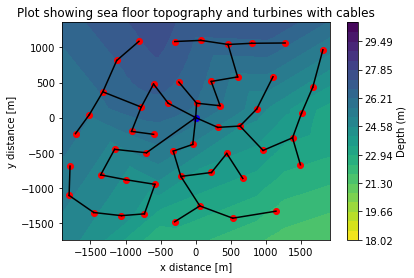

In [53]:
#DISPLAYS OPTIMAL LAYOUT

print('\033[1m'+'\033[4m'+'POST-OPTIMISED LAYOUT INFORMATION'+'\033[0m'+'\033[0m')
print()
plotting_function(smallestpositionlist,smallestindiceslist,MSTweight,data)
print('\033[1m'+'Total Power Output:'+'\033[0m', smallestTotalCost/smallestCostPerWatt, 'W')
print('\033[1m'+'Cost per Watt'+'\033[0m',smallestCostPerWatt,'£/W')

In [54]:
# 8 turbines produce 6MW of output, which is 37.5% of their max output, which is roughly correct.
# If the wind speed decreases by half, power production decreases by a factor of eight.
# On average, therefore, wind turbines do not generate near their capacity.
# Industry estimates project an annual output of 30-40%, but real-world experience shows that
# annual outputs of 15-30% of capacity are more typical in a year. Therefore this improved 37.5% is good.